# 一个没用但有趣的深度学习

这个小项目的目的是构建一个计算图片中角的角度的工具，实现的过程是这样的：

1. 首先，随机生成n张白底黑字的角的图片，每张具有不同的角度，边的长度，顶点也不同。作为数据集；
2. 以图片为输入，角度为输出，搭建卷积神经网络进行训练，最后flatten为一个节点，输出层不使用激活函数；
3. 利用另外一部分数据作为测试集，检验该工具的准确性和稳定性。

## 随机生成角的图片

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import random

#生成训练集，定义数据大小
data_size = 5000
random.seed(1)

# 定义坐标原点，边长范围和角度
X = [random.uniform(0.5,1) for _ in range(data_size)]
Y = [random.uniform(0.5,1) for _ in range(data_size)]
R = [random.uniform(0.5,1) for _ in range(data_size)]
T1 = [random.randint(-180,180) for _ in range(data_size)]
T2 = [random.randint(-180,180) for _ in range(data_size)]

# 利用plt画出角来
cir_no = 10000
for x,y,r,t1,t2 in zip(X,Y,R,T1,T2):
    cir_no += 1
    plt.figure(num=1, figsize=(2,2), dpi=90, frameon=False)#保存为180×180的图片
    plt.plot([x,x+np.sin(t1*np.pi/180)*r],[y,y+np.cos(t1*np.pi/180)*r],color='black',linewidth=1)
    plt.plot([x,x+np.sin(t2*np.pi/180)*r],[y,y+np.cos(t2*np.pi/180)*r],color='black',linewidth=1)
    plt.xlim((-0.5,2))
    plt.ylim((-0.5,2))
    plt.axis('off')
    plt.savefig('angles/angle_'+str(cir_no)+'.jpg')#请先建立相应的文件夹存放训练集图片
    plt.close('all')

X: 
[0.5671821220562006, 0.9237168684686163, 0.8818873094883071, 0.6275345128697108, 0.7477175435459704]
Y: 
[0.8776278216388838, 0.691863589740534, 0.9248110641792802, 0.5943944551164118, 0.5306656112529693]


In [126]:
#生成测试集
test_size = 500
X_t = [random.uniform(0.5,1) for _ in range(test_size)]
Y_t = [random.uniform(0.5,1) for _ in range(test_size)]
R_t = [random.uniform(0.5,1) for _ in range(test_size)]
T1_t = [random.randint(-180,180) for _ in range(test_size)]
T2_t = [random.randint(-180,180) for _ in range(test_size)]
cir_no = 1000
for x_t,y_t,r_t,t1_t,t2_t in zip(X_t,Y_t,R_t,T1_t,T2_t):
    cir_no += 1
    plt.figure(num=1, figsize=(2,2), dpi=90, frameon=False)
    plt.plot([x_t,x_t+np.sin(t1_t*np.pi/180)*r],[y_t,y_t+np.cos(t1_t*np.pi/180)*r],color='black',linewidth=1)
    plt.plot([x_t,x_t+np.sin(t2_t*np.pi/180)*r],[y_t,y_t+np.cos(t2_t*np.pi/180)*r],color='black',linewidth=1)
    plt.xlim((-0.5,2))
    plt.ylim((-0.5,2))
    plt.axis('off')
    plt.savefig('angles_t/anglet_'+str(cir_no)+'.jpg')
    plt.close('all')

## 训练模型

借鉴了[Kjetil Åmdal-Sævik在kaggle比赛中的代码](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/notebook)

In [127]:
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
import os
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
#设置显存使用，防止溢出
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K

In [128]:
# set some parameters
IMG_WIDTH = 180
IMG_HEIGHT = 180
IMG_CHANNELS = 3
TRAIN_PATH = 'angles/'
TEST_PATH = 'angles_t/'

np.random.seed = 1

In [129]:
# Get train and test IDs
train_ids = [i.split('.')[0] for i in next(os.walk(TRAIN_PATH))[2]]
test_ids = [i.split('.')[0] for i in next(os.walk(TEST_PATH))[2]]


In [131]:
# 准备数据集

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.abs(np.array(T1)-np.array(T2))/180
Y_train[Y_train>1] = 2-Y_train[Y_train>1]
print('开始准备训练集')
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    img = imread(TRAIN_PATH+id_+'.jpg')[:,:,:IMG_CHANNELS]
    X_train[n] = img
X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.abs(np.array(T1_t)-np.array(T2_t))/180
Y_test[Y_test>1] = 2-Y_test[Y_test>1]
print('开始准备测试集')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH+id_+'.jpg')[:,:,:IMG_CHANNELS]
    X_test[n] = img
print('数据准备完毕')


开始准备训练集


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1612.21it/s]


开始准备测试集


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1597.76it/s]


数据准备完毕


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


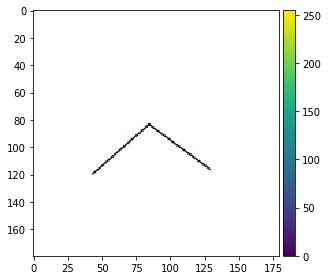

101.0


In [141]:
# 验证一下数据，可以多点选几次
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
print(Y_train[ix]*180)

这里的metric我选择了准确度，预测正确定义为预测结果与真实角度相差10度以内

In [142]:
#定义metrics

def accuracies(y_true, y_pred):
    accu_array = K.cast(K.less_equal(K.abs(y_true-y_pred), 10/180), 'int32')
    accuracies = K.sum(accu_array)/K.shape(accu_array)[0]
    return accuracies

In [162]:
# 搭建模型，三层卷积，1层全连接层，最后输出层为单个神经元，无激活函数

def ag_identy(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x/255)(inputs)
    
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='random_uniform')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='random_uniform')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='random_uniform')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='random_uniform')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='random_uniform')(p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='random_uniform')(c3)
    p3 = MaxPooling2D((3, 3))(c3)
    
#     c4 = Conv2D(48, (5,5), activation='relu', kernel_initializer='random_uniform')(p3)
#     c4 = Conv2D(64, (5,5), activation='relu', kernel_initializer='random_uniform')(c4)
#     c4 = Conv2D(96, (5,5), activation='relu', kernel_initializer='random_uniform')(c4)
    
#     c5 = Conv2D(128, (5,5), activation='relu', kernel_initializer='random_uniform')(c4)
    
    f1 = Flatten()(p3)
    d1 = Dense(128, activation='relu',kernel_initializer='random_uniform')(f1)
    
    dr = Dropout(0.5)(d1)
    
    outputs = Dense(1,kernel_initializer='random_uniform')(dr)
    
    model = Model(inputs=[inputs], outputs=[outputs])
#     adam = optimizers.adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     rmsprop = optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer='rmsprop', loss='mean_absolute_error',metrics=[accuracies])
    
    return model

model = ag_identy(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [163]:
# 模型拟合
def model_fit(X_train,Y_train,model_name,epoch,batch_size,validation_split):
#     earlystopper = EarlyStopping(patience=5,verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train,Y_train,validation_split=validation_split,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[checkpointer])
model_name = 'angle_identify_new'
epochs = 200
batch_size = 32
validation_split = 0.1
model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split)

Train on 4500 samples, validate on 500 samples
Epoch 1/200
4500/4500 [==============================] - ETA: 1:55 - loss: 0.4244 - accuracies: 0.09 - ETA: 1:02 - loss: 0.4164 - accuracies: 0.09 - ETA: 44s - loss: 0.3526 - accuracies: 0.1250 - ETA: 35s - loss: 1.4168 - accuracies: 0.093 - ETA: 30s - loss: 1.1952 - accuracies: 0.106 - ETA: 26s - loss: 1.0377 - accuracies: 0.109 - ETA: 23s - loss: 0.9268 - accuracies: 0.111 - ETA: 21s - loss: 0.8468 - accuracies: 0.105 - ETA: 20s - loss: 0.7762 - accuracies: 0.107 - ETA: 19s - loss: 0.7273 - accuracies: 0.103 - ETA: 18s - loss: 0.6869 - accuracies: 0.096 - ETA: 17s - loss: 0.6565 - accuracies: 0.096 - ETA: 16s - loss: 0.6255 - accuracies: 0.093 - ETA: 15s - loss: 0.6022 - accuracies: 0.091 - ETA: 15s - loss: 0.5775 - accuracies: 0.093 - ETA: 14s - loss: 0.5577 - accuracies: 0.097 - ETA: 14s - loss: 0.5402 - accuracies: 0.099 - ETA: 13s - loss: 0.5274 - accuracies: 0.095 - ETA: 13s - loss: 0.5145 - accuracies: 0.095 - ETA: 13s - loss: 0.50

4500/4500 [==============================] - ETA: 8s - loss: 0.2568 - accuracies: 0.15 - ETA: 10s - loss: 0.2604 - accuracies: 0.093 - ETA: 9s - loss: 0.2609 - accuracies: 0.083 - ETA: 9s - loss: 0.2636 - accuracies: 0.09 - ETA: 9s - loss: 0.2739 - accuracies: 0.08 - ETA: 9s - loss: 0.2739 - accuracies: 0.09 - ETA: 9s - loss: 0.2797 - accuracies: 0.08 - ETA: 9s - loss: 0.2759 - accuracies: 0.09 - ETA: 9s - loss: 0.2783 - accuracies: 0.09 - ETA: 9s - loss: 0.2766 - accuracies: 0.09 - ETA: 9s - loss: 0.2744 - accuracies: 0.09 - ETA: 8s - loss: 0.2724 - accuracies: 0.09 - ETA: 8s - loss: 0.2704 - accuracies: 0.09 - ETA: 8s - loss: 0.2697 - accuracies: 0.09 - ETA: 8s - loss: 0.2712 - accuracies: 0.09 - ETA: 8s - loss: 0.2708 - accuracies: 0.09 - ETA: 8s - loss: 0.2699 - accuracies: 0.09 - ETA: 8s - loss: 0.2699 - accuracies: 0.09 - ETA: 8s - loss: 0.2696 - accuracies: 0.09 - ETA: 8s - loss: 0.2689 - accuracies: 0.09 - ETA: 8s - loss: 0.2704 - accuracies: 0.09 - ETA: 8s - loss: 0.2697 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.2497 - accuracies: 0.15 - ETA: 9s - loss: 0.2440 - accuracies: 0.12 - ETA: 9s - loss: 0.2300 - accuracies: 0.11 - ETA: 9s - loss: 0.2313 - accuracies: 0.10 - ETA: 9s - loss: 0.2413 - accuracies: 0.11 - ETA: 9s - loss: 0.2456 - accuracies: 0.11 - ETA: 9s - loss: 0.2540 - accuracies: 0.11 - ETA: 9s - loss: 0.2570 - accuracies: 0.10 - ETA: 9s - loss: 0.2575 - accuracies: 0.10 - ETA: 9s - loss: 0.2565 - accuracies: 0.10 - ETA: 8s - loss: 0.2584 - accuracies: 0.10 - ETA: 8s - loss: 0.2587 - accuracies: 0.10 - ETA: 8s - loss: 0.2640 - accuracies: 0.09 - ETA: 8s - loss: 0.2648 - accuracies: 0.09 - ETA: 8s - loss: 0.2628 - accuracies: 0.10 - ETA: 8s - loss: 0.2630 - accuracies: 0.10 - ETA: 8s - loss: 0.2631 - accuracies: 0.11 - ETA: 8s - loss: 0.2605 - accuracies: 0.11 - ETA: 8s - loss: 0.2617 - accuracies: 0.12 - ETA: 8s - loss: 0.2620 - accuracies: 0.11 - ETA: 8s - loss: 0.2641 - accuracies: 0.11 - ETA: 8s - loss: 0.2644 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.2592 - accuracies: 0.12 - ETA: 9s - loss: 0.2543 - accuracies: 0.12 - ETA: 9s - loss: 0.2628 - accuracies: 0.10 - ETA: 9s - loss: 0.2575 - accuracies: 0.10 - ETA: 9s - loss: 0.2621 - accuracies: 0.10 - ETA: 8s - loss: 0.2556 - accuracies: 0.11 - ETA: 9s - loss: 0.2590 - accuracies: 0.11 - ETA: 9s - loss: 0.2586 - accuracies: 0.10 - ETA: 9s - loss: 0.2591 - accuracies: 0.10 - ETA: 9s - loss: 0.2599 - accuracies: 0.10 - ETA: 8s - loss: 0.2554 - accuracies: 0.10 - ETA: 8s - loss: 0.2558 - accuracies: 0.10 - ETA: 8s - loss: 0.2533 - accuracies: 0.11 - ETA: 8s - loss: 0.2535 - accuracies: 0.10 - ETA: 8s - loss: 0.2549 - accuracies: 0.11 - ETA: 8s - loss: 0.2547 - accuracies: 0.10 - ETA: 8s - loss: 0.2572 - accuracies: 0.10 - ETA: 8s - loss: 0.2548 - accuracies: 0.10 - ETA: 8s - loss: 0.2542 - accuracies: 0.10 - ETA: 8s - loss: 0.2557 - accuracies: 0.10 - ETA: 8s - loss: 0.2567 - accuracies: 0.10 - ETA: 8s - loss: 0.2556 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.2850 - accuracies: 0.06 - ETA: 8s - loss: 0.2654 - accuracies: 0.06 - ETA: 9s - loss: 0.2569 - accuracies: 0.05 - ETA: 9s - loss: 0.2548 - accuracies: 0.07 - ETA: 9s - loss: 0.2547 - accuracies: 0.07 - ETA: 9s - loss: 0.2563 - accuracies: 0.08 - ETA: 9s - loss: 0.2599 - accuracies: 0.07 - ETA: 9s - loss: 0.2568 - accuracies: 0.08 - ETA: 9s - loss: 0.2593 - accuracies: 0.07 - ETA: 8s - loss: 0.2566 - accuracies: 0.07 - ETA: 8s - loss: 0.2588 - accuracies: 0.07 - ETA: 8s - loss: 0.2559 - accuracies: 0.07 - ETA: 8s - loss: 0.2570 - accuracies: 0.06 - ETA: 8s - loss: 0.2563 - accuracies: 0.07 - ETA: 8s - loss: 0.2529 - accuracies: 0.08 - ETA: 8s - loss: 0.2524 - accuracies: 0.08 - ETA: 8s - loss: 0.2523 - accuracies: 0.08 - ETA: 8s - loss: 0.2532 - accuracies: 0.08 - ETA: 8s - loss: 0.2536 - accuracies: 0.08 - ETA: 8s - loss: 0.2540 - accuracies: 0.08 - ETA: 8s - loss: 0.2548 - accuracies: 0.08 - ETA: 8s - loss: 0.2540 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.2352 - accuracies: 0.12 - ETA: 9s - loss: 0.2589 - accuracies: 0.10 - ETA: 9s - loss: 0.2559 - accuracies: 0.10 - ETA: 9s - loss: 0.2433 - accuracies: 0.10 - ETA: 9s - loss: 0.2420 - accuracies: 0.10 - ETA: 9s - loss: 0.2399 - accuracies: 0.10 - ETA: 9s - loss: 0.2382 - accuracies: 0.12 - ETA: 9s - loss: 0.2375 - accuracies: 0.12 - ETA: 9s - loss: 0.2365 - accuracies: 0.13 - ETA: 9s - loss: 0.2323 - accuracies: 0.14 - ETA: 8s - loss: 0.2257 - accuracies: 0.15 - ETA: 8s - loss: 0.2241 - accuracies: 0.16 - ETA: 8s - loss: 0.2240 - accuracies: 0.16 - ETA: 8s - loss: 0.2231 - accuracies: 0.16 - ETA: 8s - loss: 0.2251 - accuracies: 0.15 - ETA: 8s - loss: 0.2261 - accuracies: 0.16 - ETA: 8s - loss: 0.2275 - accuracies: 0.15 - ETA: 8s - loss: 0.2263 - accuracies: 0.15 - ETA: 8s - loss: 0.2277 - accuracies: 0.15 - ETA: 8s - loss: 0.2286 - accuracies: 0.15 - ETA: 8s - loss: 0.2294 - accuracies: 0.15 - ETA: 8s - loss: 0.2276 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.1730 - accuracies: 0.28 - ETA: 9s - loss: 0.1758 - accuracies: 0.20 - ETA: 9s - loss: 0.1939 - accuracies: 0.18 - ETA: 9s - loss: 0.1985 - accuracies: 0.15 - ETA: 9s - loss: 0.1959 - accuracies: 0.18 - ETA: 9s - loss: 0.1862 - accuracies: 0.18 - ETA: 9s - loss: 0.1797 - accuracies: 0.18 - ETA: 9s - loss: 0.1762 - accuracies: 0.19 - ETA: 8s - loss: 0.1739 - accuracies: 0.21 - ETA: 8s - loss: 0.1682 - accuracies: 0.21 - ETA: 8s - loss: 0.1648 - accuracies: 0.22 - ETA: 8s - loss: 0.1634 - accuracies: 0.23 - ETA: 8s - loss: 0.1621 - accuracies: 0.23 - ETA: 8s - loss: 0.1598 - accuracies: 0.23 - ETA: 8s - loss: 0.1602 - accuracies: 0.23 - ETA: 8s - loss: 0.1606 - accuracies: 0.23 - ETA: 8s - loss: 0.1616 - accuracies: 0.22 - ETA: 8s - loss: 0.1632 - accuracies: 0.22 - ETA: 8s - loss: 0.1626 - accuracies: 0.22 - ETA: 8s - loss: 0.1683 - accuracies: 0.21 - ETA: 8s - loss: 0.1721 - accuracies: 0.21 - ETA: 8s - loss: 0.1737 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.1958 - accuracies: 0.34 - ETA: 9s - loss: 0.1562 - accuracies: 0.34 - ETA: 9s - loss: 0.1499 - accuracies: 0.30 - ETA: 9s - loss: 0.1408 - accuracies: 0.31 - ETA: 9s - loss: 0.1358 - accuracies: 0.33 - ETA: 8s - loss: 0.1334 - accuracies: 0.32 - ETA: 9s - loss: 0.1380 - accuracies: 0.30 - ETA: 9s - loss: 0.1410 - accuracies: 0.30 - ETA: 9s - loss: 0.1403 - accuracies: 0.30 - ETA: 8s - loss: 0.1376 - accuracies: 0.31 - ETA: 8s - loss: 0.1356 - accuracies: 0.31 - ETA: 8s - loss: 0.1331 - accuracies: 0.30 - ETA: 8s - loss: 0.1332 - accuracies: 0.31 - ETA: 8s - loss: 0.1321 - accuracies: 0.32 - ETA: 8s - loss: 0.1326 - accuracies: 0.31 - ETA: 8s - loss: 0.1408 - accuracies: 0.31 - ETA: 8s - loss: 0.1419 - accuracies: 0.30 - ETA: 8s - loss: 0.1406 - accuracies: 0.30 - ETA: 8s - loss: 0.1443 - accuracies: 0.29 - ETA: 8s - loss: 0.1441 - accuracies: 0.30 - ETA: 8s - loss: 0.1422 - accuracies: 0.29 - ETA: 8s - loss: 0.1414 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0860 - accuracies: 0.50 - ETA: 9s - loss: 0.1193 - accuracies: 0.32 - ETA: 9s - loss: 0.1443 - accuracies: 0.32 - ETA: 9s - loss: 0.1401 - accuracies: 0.30 - ETA: 8s - loss: 0.1359 - accuracies: 0.32 - ETA: 9s - loss: 0.1282 - accuracies: 0.33 - ETA: 8s - loss: 0.1261 - accuracies: 0.33 - ETA: 8s - loss: 0.1338 - accuracies: 0.31 - ETA: 8s - loss: 0.1335 - accuracies: 0.32 - ETA: 8s - loss: 0.1322 - accuracies: 0.32 - ETA: 8s - loss: 0.1291 - accuracies: 0.32 - ETA: 8s - loss: 0.1244 - accuracies: 0.34 - ETA: 8s - loss: 0.1224 - accuracies: 0.35 - ETA: 8s - loss: 0.1204 - accuracies: 0.35 - ETA: 8s - loss: 0.1199 - accuracies: 0.35 - ETA: 8s - loss: 0.1188 - accuracies: 0.35 - ETA: 8s - loss: 0.1200 - accuracies: 0.35 - ETA: 8s - loss: 0.1227 - accuracies: 0.34 - ETA: 8s - loss: 0.1252 - accuracies: 0.34 - ETA: 8s - loss: 0.1230 - accuracies: 0.35 - ETA: 8s - loss: 0.1217 - accuracies: 0.35 - ETA: 8s - loss: 0.1222 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.2183 - accuracies: 0.18 - ETA: 9s - loss: 0.2383 - accuracies: 0.10 - ETA: 8s - loss: 0.2625 - accuracies: 0.09 - ETA: 8s - loss: 0.2637 - accuracies: 0.09 - ETA: 9s - loss: 0.2545 - accuracies: 0.10 - ETA: 9s - loss: 0.2494 - accuracies: 0.11 - ETA: 8s - loss: 0.2505 - accuracies: 0.11 - ETA: 8s - loss: 0.2489 - accuracies: 0.10 - ETA: 8s - loss: 0.2473 - accuracies: 0.10 - ETA: 8s - loss: 0.2472 - accuracies: 0.11 - ETA: 8s - loss: 0.2469 - accuracies: 0.11 - ETA: 8s - loss: 0.2485 - accuracies: 0.11 - ETA: 8s - loss: 0.2521 - accuracies: 0.11 - ETA: 8s - loss: 0.2514 - accuracies: 0.12 - ETA: 8s - loss: 0.2508 - accuracies: 0.13 - ETA: 8s - loss: 0.2527 - accuracies: 0.13 - ETA: 8s - loss: 0.2518 - accuracies: 0.13 - ETA: 8s - loss: 0.2507 - accuracies: 0.14 - ETA: 8s - loss: 0.2513 - accuracies: 0.13 - ETA: 8s - loss: 0.2512 - accuracies: 0.13 - ETA: 8s - loss: 0.2530 - accuracies: 0.13 - ETA: 8s - loss: 0.2519 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.2940 - accuracies: 0.12 - ETA: 9s - loss: 0.2726 - accuracies: 0.12 - ETA: 9s - loss: 0.2710 - accuracies: 0.13 - ETA: 9s - loss: 0.2684 - accuracies: 0.13 - ETA: 9s - loss: 0.2694 - accuracies: 0.12 - ETA: 9s - loss: 0.2664 - accuracies: 0.11 - ETA: 9s - loss: 0.2623 - accuracies: 0.12 - ETA: 9s - loss: 0.2576 - accuracies: 0.12 - ETA: 8s - loss: 0.2510 - accuracies: 0.14 - ETA: 8s - loss: 0.2507 - accuracies: 0.13 - ETA: 8s - loss: 0.2540 - accuracies: 0.13 - ETA: 8s - loss: 0.2519 - accuracies: 0.13 - ETA: 8s - loss: 0.2544 - accuracies: 0.12 - ETA: 8s - loss: 0.2537 - accuracies: 0.11 - ETA: 8s - loss: 0.2542 - accuracies: 0.11 - ETA: 8s - loss: 0.2550 - accuracies: 0.11 - ETA: 8s - loss: 0.2537 - accuracies: 0.11 - ETA: 8s - loss: 0.2535 - accuracies: 0.11 - ETA: 8s - loss: 0.2515 - accuracies: 0.11 - ETA: 8s - loss: 0.2513 - accuracies: 0.12 - ETA: 8s - loss: 0.2541 - accuracies: 0.11 - ETA: 8s - loss: 0.2535 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.1633 - accuracies: 0.12 - ETA: 9s - loss: 0.1482 - accuracies: 0.21 - ETA: 9s - loss: 0.1673 - accuracies: 0.19 - ETA: 9s - loss: 0.1654 - accuracies: 0.21 - ETA: 9s - loss: 0.1651 - accuracies: 0.21 - ETA: 9s - loss: 0.1645 - accuracies: 0.22 - ETA: 9s - loss: 0.1666 - accuracies: 0.23 - ETA: 8s - loss: 0.1686 - accuracies: 0.23 - ETA: 8s - loss: 0.1623 - accuracies: 0.23 - ETA: 8s - loss: 0.1656 - accuracies: 0.22 - ETA: 8s - loss: 0.1658 - accuracies: 0.23 - ETA: 8s - loss: 0.1663 - accuracies: 0.23 - ETA: 8s - loss: 0.1681 - accuracies: 0.22 - ETA: 8s - loss: 0.1647 - accuracies: 0.23 - ETA: 8s - loss: 0.1710 - accuracies: 0.22 - ETA: 8s - loss: 0.1715 - accuracies: 0.22 - ETA: 8s - loss: 0.1714 - accuracies: 0.22 - ETA: 8s - loss: 0.1720 - accuracies: 0.21 - ETA: 8s - loss: 0.1705 - accuracies: 0.22 - ETA: 8s - loss: 0.1701 - accuracies: 0.22 - ETA: 8s - loss: 0.1695 - accuracies: 0.22 - ETA: 8s - loss: 0.1689 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.1567 - accuracies: 0.12 - ETA: 8s - loss: 0.1409 - accuracies: 0.18 - ETA: 8s - loss: 0.1604 - accuracies: 0.18 - ETA: 8s - loss: 0.1569 - accuracies: 0.20 - ETA: 8s - loss: 0.1494 - accuracies: 0.21 - ETA: 9s - loss: 0.1509 - accuracies: 0.22 - ETA: 9s - loss: 0.1475 - accuracies: 0.22 - ETA: 8s - loss: 0.1467 - accuracies: 0.21 - ETA: 8s - loss: 0.1427 - accuracies: 0.23 - ETA: 8s - loss: 0.1393 - accuracies: 0.25 - ETA: 8s - loss: 0.1387 - accuracies: 0.24 - ETA: 8s - loss: 0.1408 - accuracies: 0.23 - ETA: 8s - loss: 0.1416 - accuracies: 0.24 - ETA: 8s - loss: 0.1440 - accuracies: 0.24 - ETA: 8s - loss: 0.1412 - accuracies: 0.25 - ETA: 8s - loss: 0.1402 - accuracies: 0.25 - ETA: 8s - loss: 0.1397 - accuracies: 0.25 - ETA: 8s - loss: 0.1392 - accuracies: 0.25 - ETA: 8s - loss: 0.1421 - accuracies: 0.24 - ETA: 8s - loss: 0.1453 - accuracies: 0.24 - ETA: 8s - loss: 0.1459 - accuracies: 0.23 - ETA: 8s - loss: 0.1465 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.1141 - accuracies: 0.34 - ETA: 8s - loss: 0.1102 - accuracies: 0.34 - ETA: 9s - loss: 0.1269 - accuracies: 0.28 - ETA: 9s - loss: 0.1249 - accuracies: 0.31 - ETA: 9s - loss: 0.1205 - accuracies: 0.31 - ETA: 9s - loss: 0.1165 - accuracies: 0.32 - ETA: 8s - loss: 0.1164 - accuracies: 0.33 - ETA: 8s - loss: 0.1174 - accuracies: 0.33 - ETA: 8s - loss: 0.1177 - accuracies: 0.34 - ETA: 8s - loss: 0.1159 - accuracies: 0.34 - ETA: 8s - loss: 0.1154 - accuracies: 0.34 - ETA: 8s - loss: 0.1156 - accuracies: 0.33 - ETA: 8s - loss: 0.1158 - accuracies: 0.33 - ETA: 8s - loss: 0.1211 - accuracies: 0.32 - ETA: 8s - loss: 0.1219 - accuracies: 0.32 - ETA: 8s - loss: 0.1213 - accuracies: 0.32 - ETA: 8s - loss: 0.1210 - accuracies: 0.32 - ETA: 8s - loss: 0.1210 - accuracies: 0.31 - ETA: 8s - loss: 0.1230 - accuracies: 0.31 - ETA: 8s - loss: 0.1215 - accuracies: 0.32 - ETA: 8s - loss: 0.1209 - accuracies: 0.32 - ETA: 8s - loss: 0.1204 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.1026 - accuracies: 0.468 - ETA: 9s - loss: 0.1029 - accuracies: 0.421 - ETA: 9s - loss: 0.0962 - accuracies: 0.41 - ETA: 9s - loss: 0.0951 - accuracies: 0.40 - ETA: 9s - loss: 0.0962 - accuracies: 0.38 - ETA: 9s - loss: 0.0919 - accuracies: 0.39 - ETA: 9s - loss: 0.0990 - accuracies: 0.37 - ETA: 9s - loss: 0.0977 - accuracies: 0.38 - ETA: 9s - loss: 0.0976 - accuracies: 0.38 - ETA: 8s - loss: 0.0968 - accuracies: 0.39 - ETA: 8s - loss: 0.0980 - accuracies: 0.38 - ETA: 8s - loss: 0.1005 - accuracies: 0.37 - ETA: 8s - loss: 0.1019 - accuracies: 0.36 - ETA: 8s - loss: 0.1016 - accuracies: 0.35 - ETA: 8s - loss: 0.1003 - accuracies: 0.37 - ETA: 8s - loss: 0.1005 - accuracies: 0.37 - ETA: 8s - loss: 0.0989 - accuracies: 0.37 - ETA: 8s - loss: 0.1029 - accuracies: 0.36 - ETA: 8s - loss: 0.1021 - accuracies: 0.36 - ETA: 8s - loss: 0.1013 - accuracies: 0.37 - ETA: 8s - loss: 0.1017 - accuracies: 0.38 - ETA: 8s - loss: 0.1012 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0725 - accuracies: 0.43 - ETA: 9s - loss: 0.0966 - accuracies: 0.39 - ETA: 9s - loss: 0.0898 - accuracies: 0.41 - ETA: 9s - loss: 0.0955 - accuracies: 0.35 - ETA: 9s - loss: 0.0896 - accuracies: 0.38 - ETA: 9s - loss: 0.0928 - accuracies: 0.38 - ETA: 9s - loss: 0.0965 - accuracies: 0.36 - ETA: 8s - loss: 0.0919 - accuracies: 0.38 - ETA: 8s - loss: 0.0903 - accuracies: 0.40 - ETA: 8s - loss: 0.0886 - accuracies: 0.41 - ETA: 8s - loss: 0.0888 - accuracies: 0.41 - ETA: 8s - loss: 0.0916 - accuracies: 0.40 - ETA: 8s - loss: 0.0930 - accuracies: 0.40 - ETA: 8s - loss: 0.0949 - accuracies: 0.40 - ETA: 8s - loss: 0.0949 - accuracies: 0.40 - ETA: 8s - loss: 0.0952 - accuracies: 0.40 - ETA: 8s - loss: 0.0939 - accuracies: 0.40 - ETA: 8s - loss: 0.0939 - accuracies: 0.40 - ETA: 8s - loss: 0.0955 - accuracies: 0.40 - ETA: 8s - loss: 0.0943 - accuracies: 0.41 - ETA: 8s - loss: 0.0939 - accuracies: 0.40 - ETA: 8s - loss: 0.0936 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0572 - accuracies: 0.56 - ETA: 8s - loss: 0.0532 - accuracies: 0.57 - ETA: 8s - loss: 0.0832 - accuracies: 0.45 - ETA: 8s - loss: 0.0874 - accuracies: 0.43 - ETA: 9s - loss: 0.0904 - accuracies: 0.43 - ETA: 9s - loss: 0.0891 - accuracies: 0.44 - ETA: 9s - loss: 0.0915 - accuracies: 0.41 - ETA: 8s - loss: 0.0923 - accuracies: 0.39 - ETA: 8s - loss: 0.0932 - accuracies: 0.39 - ETA: 8s - loss: 0.0926 - accuracies: 0.39 - ETA: 8s - loss: 0.0908 - accuracies: 0.39 - ETA: 8s - loss: 0.0899 - accuracies: 0.40 - ETA: 8s - loss: 0.0907 - accuracies: 0.40 - ETA: 8s - loss: 0.0915 - accuracies: 0.39 - ETA: 8s - loss: 0.0908 - accuracies: 0.40 - ETA: 8s - loss: 0.0891 - accuracies: 0.40 - ETA: 8s - loss: 0.0896 - accuracies: 0.40 - ETA: 8s - loss: 0.0885 - accuracies: 0.41 - ETA: 8s - loss: 0.0889 - accuracies: 0.41 - ETA: 8s - loss: 0.0880 - accuracies: 0.42 - ETA: 8s - loss: 0.0883 - accuracies: 0.41 - ETA: 8s - loss: 0.0881 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0707 - accuracies: 0.46 - ETA: 8s - loss: 0.0720 - accuracies: 0.51 - ETA: 8s - loss: 0.0773 - accuracies: 0.48 - ETA: 8s - loss: 0.0797 - accuracies: 0.47 - ETA: 8s - loss: 0.0764 - accuracies: 0.48 - ETA: 8s - loss: 0.0765 - accuracies: 0.48 - ETA: 9s - loss: 0.0775 - accuracies: 0.50 - ETA: 9s - loss: 0.0778 - accuracies: 0.51 - ETA: 8s - loss: 0.0761 - accuracies: 0.52 - ETA: 8s - loss: 0.0754 - accuracies: 0.51 - ETA: 8s - loss: 0.0735 - accuracies: 0.52 - ETA: 8s - loss: 0.0770 - accuracies: 0.50 - ETA: 8s - loss: 0.0775 - accuracies: 0.49 - ETA: 8s - loss: 0.0764 - accuracies: 0.50 - ETA: 8s - loss: 0.0747 - accuracies: 0.50 - ETA: 8s - loss: 0.0765 - accuracies: 0.50 - ETA: 8s - loss: 0.0769 - accuracies: 0.49 - ETA: 8s - loss: 0.0797 - accuracies: 0.47 - ETA: 8s - loss: 0.0800 - accuracies: 0.47 - ETA: 8s - loss: 0.0803 - accuracies: 0.47 - ETA: 8s - loss: 0.0801 - accuracies: 0.47 - ETA: 8s - loss: 0.0795 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0742 - accuracies: 0.50 - ETA: 9s - loss: 0.0708 - accuracies: 0.45 - ETA: 9s - loss: 0.0783 - accuracies: 0.38 - ETA: 9s - loss: 0.0810 - accuracies: 0.39 - ETA: 9s - loss: 0.0782 - accuracies: 0.41 - ETA: 9s - loss: 0.0863 - accuracies: 0.38 - ETA: 9s - loss: 0.0893 - accuracies: 0.36 - ETA: 8s - loss: 0.0866 - accuracies: 0.38 - ETA: 8s - loss: 0.0822 - accuracies: 0.41 - ETA: 8s - loss: 0.0810 - accuracies: 0.43 - ETA: 8s - loss: 0.0803 - accuracies: 0.44 - ETA: 8s - loss: 0.0792 - accuracies: 0.43 - ETA: 8s - loss: 0.0814 - accuracies: 0.43 - ETA: 8s - loss: 0.0817 - accuracies: 0.43 - ETA: 8s - loss: 0.0804 - accuracies: 0.43 - ETA: 8s - loss: 0.0813 - accuracies: 0.43 - ETA: 8s - loss: 0.0821 - accuracies: 0.43 - ETA: 8s - loss: 0.0813 - accuracies: 0.43 - ETA: 8s - loss: 0.0812 - accuracies: 0.43 - ETA: 8s - loss: 0.0802 - accuracies: 0.44 - ETA: 8s - loss: 0.0804 - accuracies: 0.44 - ETA: 8s - loss: 0.0800 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0642 - accuracies: 0.62 - ETA: 8s - loss: 0.0790 - accuracies: 0.46 - ETA: 9s - loss: 0.0885 - accuracies: 0.42 - ETA: 9s - loss: 0.0841 - accuracies: 0.42 - ETA: 9s - loss: 0.0781 - accuracies: 0.47 - ETA: 9s - loss: 0.0737 - accuracies: 0.51 - ETA: 9s - loss: 0.0712 - accuracies: 0.52 - ETA: 8s - loss: 0.0704 - accuracies: 0.53 - ETA: 8s - loss: 0.0698 - accuracies: 0.53 - ETA: 8s - loss: 0.0701 - accuracies: 0.53 - ETA: 8s - loss: 0.0714 - accuracies: 0.51 - ETA: 8s - loss: 0.0702 - accuracies: 0.52 - ETA: 8s - loss: 0.0696 - accuracies: 0.52 - ETA: 8s - loss: 0.0715 - accuracies: 0.51 - ETA: 8s - loss: 0.0720 - accuracies: 0.50 - ETA: 8s - loss: 0.0719 - accuracies: 0.51 - ETA: 8s - loss: 0.0727 - accuracies: 0.50 - ETA: 8s - loss: 0.0733 - accuracies: 0.50 - ETA: 8s - loss: 0.0751 - accuracies: 0.50 - ETA: 8s - loss: 0.0743 - accuracies: 0.50 - ETA: 8s - loss: 0.0752 - accuracies: 0.50 - ETA: 8s - loss: 0.0750 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0651 - accuracies: 0.53 - ETA: 9s - loss: 0.0678 - accuracies: 0.53 - ETA: 9s - loss: 0.0659 - accuracies: 0.52 - ETA: 9s - loss: 0.0732 - accuracies: 0.47 - ETA: 9s - loss: 0.0684 - accuracies: 0.51 - ETA: 9s - loss: 0.0695 - accuracies: 0.51 - ETA: 8s - loss: 0.0694 - accuracies: 0.51 - ETA: 8s - loss: 0.0695 - accuracies: 0.51 - ETA: 8s - loss: 0.0706 - accuracies: 0.50 - ETA: 8s - loss: 0.0723 - accuracies: 0.48 - ETA: 8s - loss: 0.0709 - accuracies: 0.48 - ETA: 8s - loss: 0.0715 - accuracies: 0.48 - ETA: 8s - loss: 0.0698 - accuracies: 0.49 - ETA: 8s - loss: 0.0693 - accuracies: 0.49 - ETA: 8s - loss: 0.0693 - accuracies: 0.49 - ETA: 8s - loss: 0.0696 - accuracies: 0.50 - ETA: 8s - loss: 0.0689 - accuracies: 0.50 - ETA: 8s - loss: 0.0691 - accuracies: 0.50 - ETA: 8s - loss: 0.0678 - accuracies: 0.51 - ETA: 8s - loss: 0.0678 - accuracies: 0.51 - ETA: 8s - loss: 0.0667 - accuracies: 0.52 - ETA: 8s - loss: 0.0664 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0499 - accuracies: 0.687 - ETA: 9s - loss: 0.0595 - accuracies: 0.609 - ETA: 9s - loss: 0.0655 - accuracies: 0.57 - ETA: 9s - loss: 0.0662 - accuracies: 0.53 - ETA: 9s - loss: 0.0625 - accuracies: 0.55 - ETA: 9s - loss: 0.0592 - accuracies: 0.58 - ETA: 8s - loss: 0.0578 - accuracies: 0.60 - ETA: 9s - loss: 0.0610 - accuracies: 0.58 - ETA: 8s - loss: 0.0612 - accuracies: 0.58 - ETA: 8s - loss: 0.0627 - accuracies: 0.58 - ETA: 8s - loss: 0.0641 - accuracies: 0.56 - ETA: 8s - loss: 0.0639 - accuracies: 0.57 - ETA: 8s - loss: 0.0627 - accuracies: 0.57 - ETA: 8s - loss: 0.0645 - accuracies: 0.56 - ETA: 8s - loss: 0.0656 - accuracies: 0.55 - ETA: 8s - loss: 0.0654 - accuracies: 0.55 - ETA: 8s - loss: 0.0641 - accuracies: 0.56 - ETA: 8s - loss: 0.0626 - accuracies: 0.58 - ETA: 8s - loss: 0.0625 - accuracies: 0.58 - ETA: 8s - loss: 0.0629 - accuracies: 0.57 - ETA: 8s - loss: 0.0627 - accuracies: 0.58 - ETA: 8s - loss: 0.0635 - acc

4500/4500 [==============================] - ETA: 7s - loss: 0.0764 - accuracies: 0.62 - ETA: 8s - loss: 0.0685 - accuracies: 0.57 - ETA: 9s - loss: 0.0685 - accuracies: 0.57 - ETA: 9s - loss: 0.0689 - accuracies: 0.55 - ETA: 9s - loss: 0.0699 - accuracies: 0.53 - ETA: 9s - loss: 0.0702 - accuracies: 0.51 - ETA: 8s - loss: 0.0719 - accuracies: 0.49 - ETA: 8s - loss: 0.0727 - accuracies: 0.48 - ETA: 8s - loss: 0.0708 - accuracies: 0.48 - ETA: 8s - loss: 0.0682 - accuracies: 0.50 - ETA: 8s - loss: 0.0693 - accuracies: 0.49 - ETA: 8s - loss: 0.0668 - accuracies: 0.51 - ETA: 8s - loss: 0.0671 - accuracies: 0.51 - ETA: 8s - loss: 0.0678 - accuracies: 0.51 - ETA: 8s - loss: 0.0679 - accuracies: 0.51 - ETA: 8s - loss: 0.0672 - accuracies: 0.50 - ETA: 8s - loss: 0.0665 - accuracies: 0.51 - ETA: 8s - loss: 0.0667 - accuracies: 0.51 - ETA: 8s - loss: 0.0657 - accuracies: 0.52 - ETA: 8s - loss: 0.0662 - accuracies: 0.52 - ETA: 8s - loss: 0.0664 - accuracies: 0.52 - ETA: 8s - loss: 0.0660 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0673 - accuracies: 0.59 - ETA: 9s - loss: 0.0638 - accuracies: 0.57 - ETA: 9s - loss: 0.0625 - accuracies: 0.57 - ETA: 9s - loss: 0.0662 - accuracies: 0.57 - ETA: 9s - loss: 0.0711 - accuracies: 0.51 - ETA: 9s - loss: 0.0706 - accuracies: 0.50 - ETA: 9s - loss: 0.0698 - accuracies: 0.51 - ETA: 9s - loss: 0.0693 - accuracies: 0.51 - ETA: 8s - loss: 0.0694 - accuracies: 0.51 - ETA: 8s - loss: 0.0677 - accuracies: 0.52 - ETA: 8s - loss: 0.0676 - accuracies: 0.52 - ETA: 8s - loss: 0.0675 - accuracies: 0.52 - ETA: 8s - loss: 0.0672 - accuracies: 0.52 - ETA: 8s - loss: 0.0657 - accuracies: 0.53 - ETA: 8s - loss: 0.0657 - accuracies: 0.53 - ETA: 8s - loss: 0.0658 - accuracies: 0.53 - ETA: 8s - loss: 0.0655 - accuracies: 0.54 - ETA: 8s - loss: 0.0666 - accuracies: 0.53 - ETA: 8s - loss: 0.0659 - accuracies: 0.53 - ETA: 8s - loss: 0.0657 - accuracies: 0.54 - ETA: 8s - loss: 0.0653 - accuracies: 0.55 - ETA: 8s - loss: 0.0658 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0498 - accuracies: 0.56 - ETA: 9s - loss: 0.0539 - accuracies: 0.53 - ETA: 9s - loss: 0.0510 - accuracies: 0.61 - ETA: 9s - loss: 0.0550 - accuracies: 0.57 - ETA: 9s - loss: 0.0561 - accuracies: 0.59 - ETA: 9s - loss: 0.0606 - accuracies: 0.57 - ETA: 9s - loss: 0.0609 - accuracies: 0.58 - ETA: 9s - loss: 0.0605 - accuracies: 0.57 - ETA: 9s - loss: 0.0606 - accuracies: 0.57 - ETA: 8s - loss: 0.0613 - accuracies: 0.58 - ETA: 8s - loss: 0.0623 - accuracies: 0.58 - ETA: 8s - loss: 0.0617 - accuracies: 0.58 - ETA: 8s - loss: 0.0609 - accuracies: 0.59 - ETA: 8s - loss: 0.0605 - accuracies: 0.59 - ETA: 8s - loss: 0.0606 - accuracies: 0.59 - ETA: 8s - loss: 0.0628 - accuracies: 0.57 - ETA: 8s - loss: 0.0631 - accuracies: 0.57 - ETA: 8s - loss: 0.0629 - accuracies: 0.57 - ETA: 8s - loss: 0.0624 - accuracies: 0.58 - ETA: 8s - loss: 0.0626 - accuracies: 0.57 - ETA: 8s - loss: 0.0621 - accuracies: 0.57 - ETA: 8s - loss: 0.0619 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0552 - accuracies: 0.593 - ETA: 9s - loss: 0.0614 - accuracies: 0.609 - ETA: 8s - loss: 0.0590 - accuracies: 0.63 - ETA: 9s - loss: 0.0611 - accuracies: 0.60 - ETA: 9s - loss: 0.0568 - accuracies: 0.61 - ETA: 9s - loss: 0.0565 - accuracies: 0.60 - ETA: 9s - loss: 0.0552 - accuracies: 0.62 - ETA: 9s - loss: 0.0554 - accuracies: 0.62 - ETA: 9s - loss: 0.0555 - accuracies: 0.62 - ETA: 9s - loss: 0.0565 - accuracies: 0.61 - ETA: 8s - loss: 0.0558 - accuracies: 0.61 - ETA: 8s - loss: 0.0546 - accuracies: 0.63 - ETA: 8s - loss: 0.0558 - accuracies: 0.61 - ETA: 8s - loss: 0.0568 - accuracies: 0.60 - ETA: 8s - loss: 0.0567 - accuracies: 0.60 - ETA: 8s - loss: 0.0580 - accuracies: 0.58 - ETA: 8s - loss: 0.0591 - accuracies: 0.58 - ETA: 8s - loss: 0.0595 - accuracies: 0.57 - ETA: 8s - loss: 0.0592 - accuracies: 0.57 - ETA: 8s - loss: 0.0590 - accuracies: 0.57 - ETA: 8s - loss: 0.0592 - accuracies: 0.57 - ETA: 8s - loss: 0.0591 - acc

4500/4500 [==============================] - ETA: 8s - loss: 0.0720 - accuracies: 0.46 - ETA: 8s - loss: 0.0591 - accuracies: 0.59 - ETA: 9s - loss: 0.0636 - accuracies: 0.58 - ETA: 8s - loss: 0.0620 - accuracies: 0.57 - ETA: 8s - loss: 0.0608 - accuracies: 0.56 - ETA: 8s - loss: 0.0584 - accuracies: 0.57 - ETA: 9s - loss: 0.0580 - accuracies: 0.58 - ETA: 8s - loss: 0.0574 - accuracies: 0.58 - ETA: 8s - loss: 0.0589 - accuracies: 0.56 - ETA: 8s - loss: 0.0578 - accuracies: 0.58 - ETA: 8s - loss: 0.0572 - accuracies: 0.58 - ETA: 8s - loss: 0.0573 - accuracies: 0.58 - ETA: 8s - loss: 0.0574 - accuracies: 0.57 - ETA: 8s - loss: 0.0574 - accuracies: 0.58 - ETA: 8s - loss: 0.0576 - accuracies: 0.58 - ETA: 8s - loss: 0.0564 - accuracies: 0.59 - ETA: 8s - loss: 0.0571 - accuracies: 0.59 - ETA: 8s - loss: 0.0585 - accuracies: 0.57 - ETA: 8s - loss: 0.0595 - accuracies: 0.56 - ETA: 8s - loss: 0.0598 - accuracies: 0.57 - ETA: 8s - loss: 0.0598 - accuracies: 0.57 - ETA: 8s - loss: 0.0593 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0488 - accuracies: 0.65 - ETA: 9s - loss: 0.0615 - accuracies: 0.57 - ETA: 9s - loss: 0.0586 - accuracies: 0.57 - ETA: 9s - loss: 0.0588 - accuracies: 0.56 - ETA: 9s - loss: 0.0600 - accuracies: 0.55 - ETA: 9s - loss: 0.0571 - accuracies: 0.58 - ETA: 9s - loss: 0.0574 - accuracies: 0.60 - ETA: 9s - loss: 0.0558 - accuracies: 0.61 - ETA: 9s - loss: 0.0553 - accuracies: 0.62 - ETA: 8s - loss: 0.0543 - accuracies: 0.63 - ETA: 8s - loss: 0.0544 - accuracies: 0.62 - ETA: 8s - loss: 0.0552 - accuracies: 0.62 - ETA: 8s - loss: 0.0567 - accuracies: 0.61 - ETA: 8s - loss: 0.0562 - accuracies: 0.61 - ETA: 8s - loss: 0.0566 - accuracies: 0.61 - ETA: 8s - loss: 0.0572 - accuracies: 0.61 - ETA: 8s - loss: 0.0569 - accuracies: 0.61 - ETA: 8s - loss: 0.0564 - accuracies: 0.61 - ETA: 8s - loss: 0.0564 - accuracies: 0.61 - ETA: 8s - loss: 0.0571 - accuracies: 0.60 - ETA: 8s - loss: 0.0589 - accuracies: 0.59 - ETA: 8s - loss: 0.0591 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0611 - accuracies: 0.56 - ETA: 8s - loss: 0.0594 - accuracies: 0.57 - ETA: 9s - loss: 0.0552 - accuracies: 0.61 - ETA: 9s - loss: 0.0572 - accuracies: 0.60 - ETA: 9s - loss: 0.0600 - accuracies: 0.58 - ETA: 9s - loss: 0.0575 - accuracies: 0.59 - ETA: 9s - loss: 0.0577 - accuracies: 0.59 - ETA: 9s - loss: 0.0574 - accuracies: 0.59 - ETA: 8s - loss: 0.0584 - accuracies: 0.57 - ETA: 8s - loss: 0.0558 - accuracies: 0.60 - ETA: 8s - loss: 0.0550 - accuracies: 0.61 - ETA: 8s - loss: 0.0547 - accuracies: 0.62 - ETA: 8s - loss: 0.0551 - accuracies: 0.61 - ETA: 8s - loss: 0.0553 - accuracies: 0.60 - ETA: 8s - loss: 0.0554 - accuracies: 0.60 - ETA: 8s - loss: 0.0544 - accuracies: 0.61 - ETA: 8s - loss: 0.0557 - accuracies: 0.61 - ETA: 8s - loss: 0.0550 - accuracies: 0.61 - ETA: 8s - loss: 0.0549 - accuracies: 0.61 - ETA: 8s - loss: 0.0549 - accuracies: 0.60 - ETA: 8s - loss: 0.0551 - accuracies: 0.61 - ETA: 8s - loss: 0.0548 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0572 - accuracies: 0.50 - ETA: 9s - loss: 0.0684 - accuracies: 0.48 - ETA: 9s - loss: 0.0585 - accuracies: 0.56 - ETA: 9s - loss: 0.0606 - accuracies: 0.59 - ETA: 9s - loss: 0.0592 - accuracies: 0.58 - ETA: 9s - loss: 0.0572 - accuracies: 0.61 - ETA: 9s - loss: 0.0573 - accuracies: 0.61 - ETA: 8s - loss: 0.0563 - accuracies: 0.62 - ETA: 8s - loss: 0.0562 - accuracies: 0.62 - ETA: 8s - loss: 0.0556 - accuracies: 0.63 - ETA: 8s - loss: 0.0556 - accuracies: 0.63 - ETA: 8s - loss: 0.0547 - accuracies: 0.64 - ETA: 8s - loss: 0.0558 - accuracies: 0.62 - ETA: 8s - loss: 0.0569 - accuracies: 0.62 - ETA: 8s - loss: 0.0570 - accuracies: 0.61 - ETA: 8s - loss: 0.0575 - accuracies: 0.61 - ETA: 8s - loss: 0.0567 - accuracies: 0.61 - ETA: 8s - loss: 0.0573 - accuracies: 0.60 - ETA: 8s - loss: 0.0576 - accuracies: 0.60 - ETA: 8s - loss: 0.0573 - accuracies: 0.60 - ETA: 8s - loss: 0.0569 - accuracies: 0.61 - ETA: 8s - loss: 0.0582 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0509 - accuracies: 0.65 - ETA: 9s - loss: 0.0588 - accuracies: 0.56 - ETA: 9s - loss: 0.0639 - accuracies: 0.48 - ETA: 9s - loss: 0.0628 - accuracies: 0.50 - ETA: 9s - loss: 0.0602 - accuracies: 0.53 - ETA: 9s - loss: 0.0602 - accuracies: 0.54 - ETA: 8s - loss: 0.0597 - accuracies: 0.54 - ETA: 9s - loss: 0.0573 - accuracies: 0.57 - ETA: 9s - loss: 0.0574 - accuracies: 0.58 - ETA: 8s - loss: 0.0564 - accuracies: 0.59 - ETA: 8s - loss: 0.0549 - accuracies: 0.61 - ETA: 8s - loss: 0.0549 - accuracies: 0.61 - ETA: 8s - loss: 0.0549 - accuracies: 0.62 - ETA: 8s - loss: 0.0554 - accuracies: 0.61 - ETA: 8s - loss: 0.0560 - accuracies: 0.61 - ETA: 8s - loss: 0.0559 - accuracies: 0.61 - ETA: 8s - loss: 0.0557 - accuracies: 0.62 - ETA: 8s - loss: 0.0566 - accuracies: 0.61 - ETA: 8s - loss: 0.0566 - accuracies: 0.61 - ETA: 8s - loss: 0.0567 - accuracies: 0.61 - ETA: 8s - loss: 0.0565 - accuracies: 0.60 - ETA: 8s - loss: 0.0568 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0492 - accuracies: 0.71 - ETA: 8s - loss: 0.0627 - accuracies: 0.56 - ETA: 9s - loss: 0.0560 - accuracies: 0.60 - ETA: 9s - loss: 0.0579 - accuracies: 0.57 - ETA: 8s - loss: 0.0567 - accuracies: 0.59 - ETA: 9s - loss: 0.0576 - accuracies: 0.57 - ETA: 8s - loss: 0.0580 - accuracies: 0.58 - ETA: 8s - loss: 0.0574 - accuracies: 0.57 - ETA: 8s - loss: 0.0567 - accuracies: 0.57 - ETA: 8s - loss: 0.0561 - accuracies: 0.58 - ETA: 8s - loss: 0.0570 - accuracies: 0.58 - ETA: 8s - loss: 0.0570 - accuracies: 0.58 - ETA: 8s - loss: 0.0564 - accuracies: 0.59 - ETA: 8s - loss: 0.0557 - accuracies: 0.60 - ETA: 8s - loss: 0.0553 - accuracies: 0.60 - ETA: 8s - loss: 0.0555 - accuracies: 0.60 - ETA: 8s - loss: 0.0553 - accuracies: 0.60 - ETA: 8s - loss: 0.0552 - accuracies: 0.60 - ETA: 8s - loss: 0.0556 - accuracies: 0.60 - ETA: 8s - loss: 0.0552 - accuracies: 0.61 - ETA: 8s - loss: 0.0552 - accuracies: 0.61 - ETA: 8s - loss: 0.0547 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0543 - accuracies: 0.75 - ETA: 9s - loss: 0.0597 - accuracies: 0.65 - ETA: 9s - loss: 0.0578 - accuracies: 0.61 - ETA: 9s - loss: 0.0576 - accuracies: 0.60 - ETA: 9s - loss: 0.0558 - accuracies: 0.61 - ETA: 9s - loss: 0.0545 - accuracies: 0.61 - ETA: 9s - loss: 0.0541 - accuracies: 0.62 - ETA: 9s - loss: 0.0545 - accuracies: 0.62 - ETA: 9s - loss: 0.0560 - accuracies: 0.61 - ETA: 8s - loss: 0.0546 - accuracies: 0.62 - ETA: 8s - loss: 0.0542 - accuracies: 0.62 - ETA: 8s - loss: 0.0555 - accuracies: 0.62 - ETA: 8s - loss: 0.0561 - accuracies: 0.61 - ETA: 8s - loss: 0.0560 - accuracies: 0.60 - ETA: 8s - loss: 0.0551 - accuracies: 0.61 - ETA: 8s - loss: 0.0544 - accuracies: 0.62 - ETA: 8s - loss: 0.0542 - accuracies: 0.62 - ETA: 8s - loss: 0.0546 - accuracies: 0.62 - ETA: 8s - loss: 0.0542 - accuracies: 0.62 - ETA: 8s - loss: 0.0545 - accuracies: 0.61 - ETA: 8s - loss: 0.0544 - accuracies: 0.61 - ETA: 8s - loss: 0.0550 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0984 - accuracies: 0.40 - ETA: 9s - loss: 0.0819 - accuracies: 0.42 - ETA: 9s - loss: 0.0701 - accuracies: 0.48 - ETA: 9s - loss: 0.0654 - accuracies: 0.53 - ETA: 8s - loss: 0.0664 - accuracies: 0.51 - ETA: 9s - loss: 0.0642 - accuracies: 0.52 - ETA: 9s - loss: 0.0657 - accuracies: 0.52 - ETA: 8s - loss: 0.0670 - accuracies: 0.51 - ETA: 8s - loss: 0.0660 - accuracies: 0.52 - ETA: 8s - loss: 0.0656 - accuracies: 0.53 - ETA: 8s - loss: 0.0645 - accuracies: 0.53 - ETA: 8s - loss: 0.0637 - accuracies: 0.54 - ETA: 8s - loss: 0.0630 - accuracies: 0.55 - ETA: 8s - loss: 0.0617 - accuracies: 0.56 - ETA: 8s - loss: 0.0611 - accuracies: 0.56 - ETA: 8s - loss: 0.0606 - accuracies: 0.57 - ETA: 8s - loss: 0.0602 - accuracies: 0.57 - ETA: 8s - loss: 0.0596 - accuracies: 0.58 - ETA: 8s - loss: 0.0598 - accuracies: 0.57 - ETA: 8s - loss: 0.0592 - accuracies: 0.58 - ETA: 8s - loss: 0.0594 - accuracies: 0.58 - ETA: 8s - loss: 0.0592 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0411 - accuracies: 0.68 - ETA: 9s - loss: 0.0591 - accuracies: 0.54 - ETA: 9s - loss: 0.0565 - accuracies: 0.60 - ETA: 9s - loss: 0.0552 - accuracies: 0.61 - ETA: 9s - loss: 0.0560 - accuracies: 0.60 - ETA: 9s - loss: 0.0543 - accuracies: 0.61 - ETA: 9s - loss: 0.0527 - accuracies: 0.63 - ETA: 9s - loss: 0.0516 - accuracies: 0.64 - ETA: 9s - loss: 0.0501 - accuracies: 0.65 - ETA: 9s - loss: 0.0503 - accuracies: 0.65 - ETA: 8s - loss: 0.0507 - accuracies: 0.64 - ETA: 8s - loss: 0.0508 - accuracies: 0.64 - ETA: 8s - loss: 0.0501 - accuracies: 0.66 - ETA: 8s - loss: 0.0505 - accuracies: 0.65 - ETA: 8s - loss: 0.0496 - accuracies: 0.66 - ETA: 8s - loss: 0.0494 - accuracies: 0.65 - ETA: 8s - loss: 0.0497 - accuracies: 0.65 - ETA: 8s - loss: 0.0533 - accuracies: 0.63 - ETA: 8s - loss: 0.0534 - accuracies: 0.63 - ETA: 8s - loss: 0.0530 - accuracies: 0.63 - ETA: 8s - loss: 0.0527 - accuracies: 0.63 - ETA: 8s - loss: 0.0521 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0636 - accuracies: 0.50 - ETA: 9s - loss: 0.0626 - accuracies: 0.56 - ETA: 9s - loss: 0.0584 - accuracies: 0.59 - ETA: 9s - loss: 0.0526 - accuracies: 0.66 - ETA: 9s - loss: 0.0536 - accuracies: 0.66 - ETA: 9s - loss: 0.0530 - accuracies: 0.67 - ETA: 9s - loss: 0.0515 - accuracies: 0.68 - ETA: 9s - loss: 0.0515 - accuracies: 0.67 - ETA: 9s - loss: 0.0514 - accuracies: 0.68 - ETA: 9s - loss: 0.0526 - accuracies: 0.67 - ETA: 8s - loss: 0.0531 - accuracies: 0.66 - ETA: 8s - loss: 0.0526 - accuracies: 0.66 - ETA: 8s - loss: 0.0524 - accuracies: 0.66 - ETA: 8s - loss: 0.0521 - accuracies: 0.66 - ETA: 8s - loss: 0.0523 - accuracies: 0.66 - ETA: 8s - loss: 0.0515 - accuracies: 0.66 - ETA: 8s - loss: 0.0516 - accuracies: 0.66 - ETA: 8s - loss: 0.0515 - accuracies: 0.65 - ETA: 8s - loss: 0.0518 - accuracies: 0.65 - ETA: 8s - loss: 0.0522 - accuracies: 0.65 - ETA: 8s - loss: 0.0521 - accuracies: 0.65 - ETA: 8s - loss: 0.0522 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0353 - accuracies: 0.81 - ETA: 8s - loss: 0.0503 - accuracies: 0.65 - ETA: 9s - loss: 0.0495 - accuracies: 0.67 - ETA: 9s - loss: 0.0501 - accuracies: 0.67 - ETA: 8s - loss: 0.0523 - accuracies: 0.65 - ETA: 8s - loss: 0.0502 - accuracies: 0.68 - ETA: 8s - loss: 0.0525 - accuracies: 0.66 - ETA: 8s - loss: 0.0525 - accuracies: 0.66 - ETA: 8s - loss: 0.0533 - accuracies: 0.65 - ETA: 8s - loss: 0.0525 - accuracies: 0.66 - ETA: 8s - loss: 0.0521 - accuracies: 0.66 - ETA: 8s - loss: 0.0520 - accuracies: 0.66 - ETA: 8s - loss: 0.0515 - accuracies: 0.66 - ETA: 8s - loss: 0.0515 - accuracies: 0.66 - ETA: 8s - loss: 0.0516 - accuracies: 0.66 - ETA: 8s - loss: 0.0514 - accuracies: 0.66 - ETA: 8s - loss: 0.0514 - accuracies: 0.66 - ETA: 8s - loss: 0.0516 - accuracies: 0.67 - ETA: 8s - loss: 0.0520 - accuracies: 0.67 - ETA: 8s - loss: 0.0521 - accuracies: 0.67 - ETA: 8s - loss: 0.0520 - accuracies: 0.66 - ETA: 8s - loss: 0.0527 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0620 - accuracies: 0.53 - ETA: 8s - loss: 0.0541 - accuracies: 0.60 - ETA: 9s - loss: 0.0550 - accuracies: 0.58 - ETA: 9s - loss: 0.0574 - accuracies: 0.58 - ETA: 9s - loss: 0.0548 - accuracies: 0.61 - ETA: 9s - loss: 0.0523 - accuracies: 0.63 - ETA: 9s - loss: 0.0509 - accuracies: 0.64 - ETA: 9s - loss: 0.0490 - accuracies: 0.66 - ETA: 9s - loss: 0.0500 - accuracies: 0.66 - ETA: 9s - loss: 0.0501 - accuracies: 0.65 - ETA: 9s - loss: 0.0498 - accuracies: 0.65 - ETA: 8s - loss: 0.0507 - accuracies: 0.65 - ETA: 8s - loss: 0.0521 - accuracies: 0.64 - ETA: 8s - loss: 0.0523 - accuracies: 0.64 - ETA: 8s - loss: 0.0521 - accuracies: 0.64 - ETA: 8s - loss: 0.0523 - accuracies: 0.64 - ETA: 8s - loss: 0.0513 - accuracies: 0.65 - ETA: 8s - loss: 0.0517 - accuracies: 0.64 - ETA: 8s - loss: 0.0527 - accuracies: 0.63 - ETA: 8s - loss: 0.0525 - accuracies: 0.63 - ETA: 8s - loss: 0.0523 - accuracies: 0.63 - ETA: 8s - loss: 0.0519 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0494 - accuracies: 0.62 - ETA: 9s - loss: 0.0549 - accuracies: 0.60 - ETA: 9s - loss: 0.0534 - accuracies: 0.61 - ETA: 8s - loss: 0.0514 - accuracies: 0.63 - ETA: 9s - loss: 0.0520 - accuracies: 0.62 - ETA: 9s - loss: 0.0597 - accuracies: 0.56 - ETA: 9s - loss: 0.0730 - accuracies: 0.50 - ETA: 9s - loss: 0.0734 - accuracies: 0.49 - ETA: 9s - loss: 0.0714 - accuracies: 0.50 - ETA: 8s - loss: 0.0699 - accuracies: 0.52 - ETA: 8s - loss: 0.0696 - accuracies: 0.52 - ETA: 8s - loss: 0.0684 - accuracies: 0.53 - ETA: 8s - loss: 0.0671 - accuracies: 0.54 - ETA: 8s - loss: 0.0664 - accuracies: 0.55 - ETA: 8s - loss: 0.0661 - accuracies: 0.55 - ETA: 8s - loss: 0.0656 - accuracies: 0.55 - ETA: 8s - loss: 0.0643 - accuracies: 0.55 - ETA: 8s - loss: 0.0635 - accuracies: 0.56 - ETA: 8s - loss: 0.0630 - accuracies: 0.56 - ETA: 8s - loss: 0.0617 - accuracies: 0.57 - ETA: 8s - loss: 0.0607 - accuracies: 0.58 - ETA: 8s - loss: 0.0604 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0460 - accuracies: 0.71 - ETA: 9s - loss: 0.0431 - accuracies: 0.76 - ETA: 9s - loss: 0.0450 - accuracies: 0.73 - ETA: 9s - loss: 0.0474 - accuracies: 0.71 - ETA: 9s - loss: 0.0487 - accuracies: 0.68 - ETA: 9s - loss: 0.0502 - accuracies: 0.66 - ETA: 9s - loss: 0.0513 - accuracies: 0.64 - ETA: 9s - loss: 0.0510 - accuracies: 0.66 - ETA: 9s - loss: 0.0495 - accuracies: 0.66 - ETA: 9s - loss: 0.0500 - accuracies: 0.65 - ETA: 9s - loss: 0.0501 - accuracies: 0.65 - ETA: 8s - loss: 0.0490 - accuracies: 0.66 - ETA: 8s - loss: 0.0498 - accuracies: 0.65 - ETA: 8s - loss: 0.0491 - accuracies: 0.66 - ETA: 8s - loss: 0.0500 - accuracies: 0.66 - ETA: 8s - loss: 0.0498 - accuracies: 0.66 - ETA: 8s - loss: 0.0494 - accuracies: 0.66 - ETA: 8s - loss: 0.0502 - accuracies: 0.65 - ETA: 8s - loss: 0.0506 - accuracies: 0.65 - ETA: 8s - loss: 0.0501 - accuracies: 0.65 - ETA: 8s - loss: 0.0503 - accuracies: 0.65 - ETA: 8s - loss: 0.0505 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0569 - accuracies: 0.62 - ETA: 9s - loss: 0.0546 - accuracies: 0.67 - ETA: 9s - loss: 0.0530 - accuracies: 0.64 - ETA: 9s - loss: 0.0547 - accuracies: 0.63 - ETA: 9s - loss: 0.0539 - accuracies: 0.61 - ETA: 9s - loss: 0.0545 - accuracies: 0.61 - ETA: 9s - loss: 0.0554 - accuracies: 0.60 - ETA: 9s - loss: 0.0543 - accuracies: 0.60 - ETA: 8s - loss: 0.0568 - accuracies: 0.59 - ETA: 8s - loss: 0.0565 - accuracies: 0.59 - ETA: 8s - loss: 0.0562 - accuracies: 0.59 - ETA: 8s - loss: 0.0552 - accuracies: 0.61 - ETA: 8s - loss: 0.0542 - accuracies: 0.62 - ETA: 8s - loss: 0.0535 - accuracies: 0.63 - ETA: 8s - loss: 0.0528 - accuracies: 0.63 - ETA: 8s - loss: 0.0522 - accuracies: 0.64 - ETA: 8s - loss: 0.0520 - accuracies: 0.64 - ETA: 8s - loss: 0.0517 - accuracies: 0.64 - ETA: 8s - loss: 0.0518 - accuracies: 0.64 - ETA: 8s - loss: 0.0513 - accuracies: 0.64 - ETA: 8s - loss: 0.0511 - accuracies: 0.64 - ETA: 8s - loss: 0.0515 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0490 - accuracies: 0.62 - ETA: 9s - loss: 0.0482 - accuracies: 0.64 - ETA: 9s - loss: 0.0459 - accuracies: 0.66 - ETA: 9s - loss: 0.0474 - accuracies: 0.63 - ETA: 9s - loss: 0.0487 - accuracies: 0.64 - ETA: 9s - loss: 0.0493 - accuracies: 0.63 - ETA: 9s - loss: 0.0506 - accuracies: 0.62 - ETA: 9s - loss: 0.0522 - accuracies: 0.61 - ETA: 9s - loss: 0.0523 - accuracies: 0.61 - ETA: 9s - loss: 0.0514 - accuracies: 0.62 - ETA: 8s - loss: 0.0524 - accuracies: 0.61 - ETA: 8s - loss: 0.0522 - accuracies: 0.61 - ETA: 8s - loss: 0.0519 - accuracies: 0.62 - ETA: 8s - loss: 0.0520 - accuracies: 0.62 - ETA: 8s - loss: 0.0511 - accuracies: 0.62 - ETA: 8s - loss: 0.0516 - accuracies: 0.61 - ETA: 8s - loss: 0.0516 - accuracies: 0.61 - ETA: 8s - loss: 0.0507 - accuracies: 0.62 - ETA: 8s - loss: 0.0511 - accuracies: 0.62 - ETA: 8s - loss: 0.0510 - accuracies: 0.62 - ETA: 8s - loss: 0.0508 - accuracies: 0.62 - ETA: 8s - loss: 0.0508 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0512 - accuracies: 0.62 - ETA: 9s - loss: 0.0468 - accuracies: 0.68 - ETA: 9s - loss: 0.0514 - accuracies: 0.64 - ETA: 9s - loss: 0.0467 - accuracies: 0.70 - ETA: 9s - loss: 0.0470 - accuracies: 0.68 - ETA: 9s - loss: 0.0482 - accuracies: 0.67 - ETA: 9s - loss: 0.0487 - accuracies: 0.67 - ETA: 9s - loss: 0.0468 - accuracies: 0.69 - ETA: 9s - loss: 0.0458 - accuracies: 0.70 - ETA: 9s - loss: 0.0457 - accuracies: 0.70 - ETA: 9s - loss: 0.0457 - accuracies: 0.69 - ETA: 8s - loss: 0.0457 - accuracies: 0.69 - ETA: 8s - loss: 0.0461 - accuracies: 0.69 - ETA: 8s - loss: 0.0470 - accuracies: 0.68 - ETA: 8s - loss: 0.0479 - accuracies: 0.67 - ETA: 8s - loss: 0.0480 - accuracies: 0.67 - ETA: 8s - loss: 0.0480 - accuracies: 0.67 - ETA: 8s - loss: 0.0475 - accuracies: 0.67 - ETA: 8s - loss: 0.0472 - accuracies: 0.68 - ETA: 8s - loss: 0.0478 - accuracies: 0.68 - ETA: 8s - loss: 0.0474 - accuracies: 0.68 - ETA: 8s - loss: 0.0469 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0469 - accuracies: 0.687 - ETA: 10s - loss: 0.0447 - accuracies: 0.671 - ETA: 10s - loss: 0.0500 - accuracies: 0.656 - ETA: 10s - loss: 0.0504 - accuracies: 0.640 - ETA: 10s - loss: 0.0500 - accuracies: 0.650 - ETA: 10s - loss: 0.0486 - accuracies: 0.671 - ETA: 10s - loss: 0.0495 - accuracies: 0.656 - ETA: 10s - loss: 0.0510 - accuracies: 0.644 - ETA: 10s - loss: 0.0514 - accuracies: 0.638 - ETA: 10s - loss: 0.0503 - accuracies: 0.650 - ETA: 9s - loss: 0.0502 - accuracies: 0.656 - ETA: 9s - loss: 0.0497 - accuracies: 0.65 - ETA: 9s - loss: 0.0480 - accuracies: 0.67 - ETA: 9s - loss: 0.0473 - accuracies: 0.67 - ETA: 9s - loss: 0.0472 - accuracies: 0.68 - ETA: 9s - loss: 0.0471 - accuracies: 0.68 - ETA: 9s - loss: 0.0476 - accuracies: 0.68 - ETA: 9s - loss: 0.0472 - accuracies: 0.68 - ETA: 9s - loss: 0.0476 - accuracies: 0.68 - ETA: 9s - loss: 0.0478 - accuracies: 0.68 - ETA: 9s - loss: 0.0484 - accuracies: 0.68 - ETA: 9s - 

4500/4500 [==============================] - ETA: 10s - loss: 0.0439 - accuracies: 0.718 - ETA: 9s - loss: 0.0470 - accuracies: 0.718 - ETA: 9s - loss: 0.0461 - accuracies: 0.71 - ETA: 9s - loss: 0.0463 - accuracies: 0.68 - ETA: 9s - loss: 0.0499 - accuracies: 0.66 - ETA: 9s - loss: 0.0510 - accuracies: 0.64 - ETA: 9s - loss: 0.0493 - accuracies: 0.66 - ETA: 9s - loss: 0.0495 - accuracies: 0.65 - ETA: 9s - loss: 0.0492 - accuracies: 0.65 - ETA: 8s - loss: 0.0487 - accuracies: 0.66 - ETA: 8s - loss: 0.0484 - accuracies: 0.66 - ETA: 8s - loss: 0.0490 - accuracies: 0.65 - ETA: 8s - loss: 0.0493 - accuracies: 0.65 - ETA: 8s - loss: 0.0502 - accuracies: 0.64 - ETA: 8s - loss: 0.0508 - accuracies: 0.62 - ETA: 8s - loss: 0.0503 - accuracies: 0.63 - ETA: 8s - loss: 0.0504 - accuracies: 0.63 - ETA: 8s - loss: 0.0501 - accuracies: 0.64 - ETA: 8s - loss: 0.0496 - accuracies: 0.64 - ETA: 8s - loss: 0.0493 - accuracies: 0.64 - ETA: 8s - loss: 0.0490 - accuracies: 0.65 - ETA: 8s - loss: 0.0489 - acc

4500/4500 [==============================] - ETA: 8s - loss: 0.0667 - accuracies: 0.34 - ETA: 9s - loss: 0.0581 - accuracies: 0.48 - ETA: 9s - loss: 0.0521 - accuracies: 0.57 - ETA: 9s - loss: 0.0475 - accuracies: 0.62 - ETA: 9s - loss: 0.0478 - accuracies: 0.63 - ETA: 9s - loss: 0.0472 - accuracies: 0.64 - ETA: 9s - loss: 0.0500 - accuracies: 0.61 - ETA: 8s - loss: 0.0494 - accuracies: 0.63 - ETA: 8s - loss: 0.0492 - accuracies: 0.64 - ETA: 8s - loss: 0.0485 - accuracies: 0.65 - ETA: 8s - loss: 0.0497 - accuracies: 0.65 - ETA: 8s - loss: 0.0493 - accuracies: 0.65 - ETA: 8s - loss: 0.0484 - accuracies: 0.65 - ETA: 8s - loss: 0.0492 - accuracies: 0.65 - ETA: 8s - loss: 0.0485 - accuracies: 0.66 - ETA: 8s - loss: 0.0492 - accuracies: 0.65 - ETA: 8s - loss: 0.0500 - accuracies: 0.65 - ETA: 8s - loss: 0.0505 - accuracies: 0.64 - ETA: 8s - loss: 0.0497 - accuracies: 0.65 - ETA: 8s - loss: 0.0501 - accuracies: 0.64 - ETA: 8s - loss: 0.0505 - accuracies: 0.64 - ETA: 8s - loss: 0.0503 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0386 - accuracies: 0.71 - ETA: 9s - loss: 0.0421 - accuracies: 0.70 - ETA: 9s - loss: 0.0461 - accuracies: 0.65 - ETA: 9s - loss: 0.0447 - accuracies: 0.68 - ETA: 9s - loss: 0.0485 - accuracies: 0.66 - ETA: 9s - loss: 0.0456 - accuracies: 0.69 - ETA: 9s - loss: 0.0456 - accuracies: 0.69 - ETA: 9s - loss: 0.0468 - accuracies: 0.67 - ETA: 9s - loss: 0.0473 - accuracies: 0.66 - ETA: 8s - loss: 0.0472 - accuracies: 0.66 - ETA: 8s - loss: 0.0474 - accuracies: 0.67 - ETA: 8s - loss: 0.0481 - accuracies: 0.66 - ETA: 8s - loss: 0.0478 - accuracies: 0.67 - ETA: 8s - loss: 0.0487 - accuracies: 0.66 - ETA: 8s - loss: 0.0480 - accuracies: 0.66 - ETA: 8s - loss: 0.0479 - accuracies: 0.67 - ETA: 8s - loss: 0.0484 - accuracies: 0.66 - ETA: 8s - loss: 0.0475 - accuracies: 0.67 - ETA: 8s - loss: 0.0475 - accuracies: 0.67 - ETA: 8s - loss: 0.0472 - accuracies: 0.67 - ETA: 8s - loss: 0.0477 - accuracies: 0.66 - ETA: 8s - loss: 0.0485 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0473 - accuracies: 0.68 - ETA: 8s - loss: 0.0450 - accuracies: 0.70 - ETA: 8s - loss: 0.0454 - accuracies: 0.69 - ETA: 9s - loss: 0.0435 - accuracies: 0.71 - ETA: 9s - loss: 0.0438 - accuracies: 0.71 - ETA: 9s - loss: 0.0432 - accuracies: 0.72 - ETA: 8s - loss: 0.0438 - accuracies: 0.72 - ETA: 8s - loss: 0.0441 - accuracies: 0.72 - ETA: 8s - loss: 0.0444 - accuracies: 0.72 - ETA: 8s - loss: 0.0436 - accuracies: 0.72 - ETA: 8s - loss: 0.0437 - accuracies: 0.73 - ETA: 8s - loss: 0.0455 - accuracies: 0.71 - ETA: 8s - loss: 0.0462 - accuracies: 0.69 - ETA: 8s - loss: 0.0460 - accuracies: 0.70 - ETA: 8s - loss: 0.0471 - accuracies: 0.69 - ETA: 8s - loss: 0.0470 - accuracies: 0.69 - ETA: 8s - loss: 0.0466 - accuracies: 0.70 - ETA: 8s - loss: 0.0466 - accuracies: 0.69 - ETA: 8s - loss: 0.0468 - accuracies: 0.68 - ETA: 8s - loss: 0.0473 - accuracies: 0.68 - ETA: 8s - loss: 0.0468 - accuracies: 0.69 - ETA: 8s - loss: 0.0465 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0552 - accuracies: 0.62 - ETA: 9s - loss: 0.0550 - accuracies: 0.62 - ETA: 8s - loss: 0.0570 - accuracies: 0.61 - ETA: 9s - loss: 0.0557 - accuracies: 0.60 - ETA: 8s - loss: 0.0535 - accuracies: 0.63 - ETA: 9s - loss: 0.0522 - accuracies: 0.62 - ETA: 8s - loss: 0.0503 - accuracies: 0.65 - ETA: 9s - loss: 0.0492 - accuracies: 0.66 - ETA: 8s - loss: 0.0480 - accuracies: 0.68 - ETA: 8s - loss: 0.0484 - accuracies: 0.68 - ETA: 8s - loss: 0.0509 - accuracies: 0.66 - ETA: 8s - loss: 0.0501 - accuracies: 0.67 - ETA: 8s - loss: 0.0506 - accuracies: 0.66 - ETA: 8s - loss: 0.0514 - accuracies: 0.66 - ETA: 8s - loss: 0.0509 - accuracies: 0.66 - ETA: 8s - loss: 0.0509 - accuracies: 0.66 - ETA: 8s - loss: 0.0510 - accuracies: 0.66 - ETA: 8s - loss: 0.0507 - accuracies: 0.66 - ETA: 8s - loss: 0.0507 - accuracies: 0.66 - ETA: 8s - loss: 0.0504 - accuracies: 0.66 - ETA: 8s - loss: 0.0499 - accuracies: 0.66 - ETA: 8s - loss: 0.0496 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0400 - accuracies: 0.81 - ETA: 8s - loss: 0.0444 - accuracies: 0.73 - ETA: 9s - loss: 0.0455 - accuracies: 0.70 - ETA: 8s - loss: 0.0450 - accuracies: 0.71 - ETA: 8s - loss: 0.0433 - accuracies: 0.73 - ETA: 9s - loss: 0.0443 - accuracies: 0.71 - ETA: 9s - loss: 0.0450 - accuracies: 0.71 - ETA: 8s - loss: 0.0454 - accuracies: 0.71 - ETA: 8s - loss: 0.0466 - accuracies: 0.70 - ETA: 8s - loss: 0.0477 - accuracies: 0.68 - ETA: 8s - loss: 0.0476 - accuracies: 0.68 - ETA: 8s - loss: 0.0474 - accuracies: 0.68 - ETA: 8s - loss: 0.0468 - accuracies: 0.69 - ETA: 8s - loss: 0.0482 - accuracies: 0.68 - ETA: 8s - loss: 0.0479 - accuracies: 0.69 - ETA: 8s - loss: 0.0488 - accuracies: 0.68 - ETA: 8s - loss: 0.0482 - accuracies: 0.69 - ETA: 8s - loss: 0.0480 - accuracies: 0.69 - ETA: 8s - loss: 0.0481 - accuracies: 0.69 - ETA: 8s - loss: 0.0479 - accuracies: 0.69 - ETA: 8s - loss: 0.0474 - accuracies: 0.69 - ETA: 8s - loss: 0.0475 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0485 - accuracies: 0.65 - ETA: 8s - loss: 0.0468 - accuracies: 0.67 - ETA: 9s - loss: 0.0444 - accuracies: 0.69 - ETA: 9s - loss: 0.0443 - accuracies: 0.70 - ETA: 9s - loss: 0.0433 - accuracies: 0.70 - ETA: 9s - loss: 0.0434 - accuracies: 0.71 - ETA: 9s - loss: 0.0422 - accuracies: 0.72 - ETA: 8s - loss: 0.0431 - accuracies: 0.72 - ETA: 8s - loss: 0.0427 - accuracies: 0.72 - ETA: 8s - loss: 0.0430 - accuracies: 0.72 - ETA: 8s - loss: 0.0425 - accuracies: 0.73 - ETA: 8s - loss: 0.0429 - accuracies: 0.71 - ETA: 8s - loss: 0.0447 - accuracies: 0.70 - ETA: 8s - loss: 0.0461 - accuracies: 0.69 - ETA: 8s - loss: 0.0456 - accuracies: 0.69 - ETA: 8s - loss: 0.0458 - accuracies: 0.69 - ETA: 8s - loss: 0.0461 - accuracies: 0.68 - ETA: 8s - loss: 0.0463 - accuracies: 0.68 - ETA: 8s - loss: 0.0467 - accuracies: 0.68 - ETA: 8s - loss: 0.0466 - accuracies: 0.68 - ETA: 8s - loss: 0.0465 - accuracies: 0.68 - ETA: 8s - loss: 0.0465 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0505 - accuracies: 0.59 - ETA: 9s - loss: 0.0530 - accuracies: 0.57 - ETA: 9s - loss: 0.0516 - accuracies: 0.62 - ETA: 9s - loss: 0.0505 - accuracies: 0.63 - ETA: 8s - loss: 0.0501 - accuracies: 0.63 - ETA: 9s - loss: 0.0520 - accuracies: 0.61 - ETA: 8s - loss: 0.0499 - accuracies: 0.64 - ETA: 8s - loss: 0.0486 - accuracies: 0.66 - ETA: 8s - loss: 0.0487 - accuracies: 0.66 - ETA: 8s - loss: 0.0581 - accuracies: 0.63 - ETA: 8s - loss: 0.0565 - accuracies: 0.64 - ETA: 8s - loss: 0.0553 - accuracies: 0.65 - ETA: 8s - loss: 0.0540 - accuracies: 0.66 - ETA: 8s - loss: 0.0529 - accuracies: 0.67 - ETA: 8s - loss: 0.0520 - accuracies: 0.67 - ETA: 8s - loss: 0.0518 - accuracies: 0.67 - ETA: 8s - loss: 0.0514 - accuracies: 0.67 - ETA: 8s - loss: 0.0511 - accuracies: 0.67 - ETA: 8s - loss: 0.0517 - accuracies: 0.67 - ETA: 8s - loss: 0.0506 - accuracies: 0.68 - ETA: 8s - loss: 0.0509 - accuracies: 0.67 - ETA: 8s - loss: 0.0512 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0522 - accuracies: 0.62 - ETA: 9s - loss: 0.0618 - accuracies: 0.57 - ETA: 9s - loss: 0.0527 - accuracies: 0.65 - ETA: 9s - loss: 0.0513 - accuracies: 0.65 - ETA: 9s - loss: 0.0499 - accuracies: 0.67 - ETA: 9s - loss: 0.0482 - accuracies: 0.68 - ETA: 9s - loss: 0.0472 - accuracies: 0.69 - ETA: 9s - loss: 0.0485 - accuracies: 0.67 - ETA: 9s - loss: 0.0486 - accuracies: 0.67 - ETA: 9s - loss: 0.0487 - accuracies: 0.67 - ETA: 8s - loss: 0.0485 - accuracies: 0.67 - ETA: 8s - loss: 0.0472 - accuracies: 0.69 - ETA: 8s - loss: 0.0457 - accuracies: 0.71 - ETA: 8s - loss: 0.0460 - accuracies: 0.70 - ETA: 8s - loss: 0.0461 - accuracies: 0.69 - ETA: 8s - loss: 0.0464 - accuracies: 0.68 - ETA: 8s - loss: 0.0464 - accuracies: 0.68 - ETA: 8s - loss: 0.0471 - accuracies: 0.68 - ETA: 8s - loss: 0.0473 - accuracies: 0.67 - ETA: 8s - loss: 0.0466 - accuracies: 0.68 - ETA: 8s - loss: 0.0466 - accuracies: 0.68 - ETA: 8s - loss: 0.0468 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0488 - accuracies: 0.65 - ETA: 9s - loss: 0.0407 - accuracies: 0.76 - ETA: 9s - loss: 0.0440 - accuracies: 0.72 - ETA: 9s - loss: 0.0446 - accuracies: 0.71 - ETA: 9s - loss: 0.0495 - accuracies: 0.65 - ETA: 9s - loss: 0.0494 - accuracies: 0.65 - ETA: 8s - loss: 0.0507 - accuracies: 0.63 - ETA: 8s - loss: 0.0502 - accuracies: 0.64 - ETA: 8s - loss: 0.0496 - accuracies: 0.65 - ETA: 8s - loss: 0.0491 - accuracies: 0.66 - ETA: 8s - loss: 0.0488 - accuracies: 0.67 - ETA: 8s - loss: 0.0494 - accuracies: 0.66 - ETA: 8s - loss: 0.0489 - accuracies: 0.67 - ETA: 8s - loss: 0.0487 - accuracies: 0.67 - ETA: 8s - loss: 0.0481 - accuracies: 0.67 - ETA: 8s - loss: 0.0475 - accuracies: 0.68 - ETA: 8s - loss: 0.0484 - accuracies: 0.67 - ETA: 8s - loss: 0.0477 - accuracies: 0.68 - ETA: 8s - loss: 0.0482 - accuracies: 0.67 - ETA: 8s - loss: 0.0479 - accuracies: 0.68 - ETA: 8s - loss: 0.0477 - accuracies: 0.68 - ETA: 8s - loss: 0.0475 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0564 - accuracies: 0.50 - ETA: 8s - loss: 0.0589 - accuracies: 0.53 - ETA: 8s - loss: 0.0553 - accuracies: 0.57 - ETA: 9s - loss: 0.0541 - accuracies: 0.56 - ETA: 9s - loss: 0.0512 - accuracies: 0.60 - ETA: 8s - loss: 0.0489 - accuracies: 0.62 - ETA: 8s - loss: 0.0494 - accuracies: 0.63 - ETA: 8s - loss: 0.0483 - accuracies: 0.65 - ETA: 9s - loss: 0.0466 - accuracies: 0.66 - ETA: 8s - loss: 0.0465 - accuracies: 0.66 - ETA: 8s - loss: 0.0457 - accuracies: 0.67 - ETA: 8s - loss: 0.0454 - accuracies: 0.67 - ETA: 8s - loss: 0.0448 - accuracies: 0.68 - ETA: 8s - loss: 0.0451 - accuracies: 0.68 - ETA: 8s - loss: 0.0447 - accuracies: 0.69 - ETA: 8s - loss: 0.0450 - accuracies: 0.69 - ETA: 8s - loss: 0.0457 - accuracies: 0.68 - ETA: 8s - loss: 0.0461 - accuracies: 0.67 - ETA: 8s - loss: 0.0464 - accuracies: 0.67 - ETA: 8s - loss: 0.0458 - accuracies: 0.67 - ETA: 8s - loss: 0.0452 - accuracies: 0.68 - ETA: 8s - loss: 0.0460 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0514 - accuracies: 0.625 - ETA: 10s - loss: 0.0452 - accuracies: 0.671 - ETA: 9s - loss: 0.0467 - accuracies: 0.666 - ETA: 9s - loss: 0.0467 - accuracies: 0.65 - ETA: 9s - loss: 0.0461 - accuracies: 0.65 - ETA: 9s - loss: 0.0450 - accuracies: 0.66 - ETA: 9s - loss: 0.0450 - accuracies: 0.67 - ETA: 9s - loss: 0.0432 - accuracies: 0.69 - ETA: 9s - loss: 0.0435 - accuracies: 0.69 - ETA: 9s - loss: 0.0438 - accuracies: 0.69 - ETA: 8s - loss: 0.0436 - accuracies: 0.70 - ETA: 8s - loss: 0.0436 - accuracies: 0.70 - ETA: 8s - loss: 0.0439 - accuracies: 0.70 - ETA: 8s - loss: 0.0437 - accuracies: 0.70 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0426 - accuracies: 0.72 - ETA: 8s - loss: 0.0435 - accuracies: 0.71 - ETA: 8s - loss: 0.0434 - accuracies: 0.72 - ETA: 8s - loss: 0.0435 - accuracies: 0.72 - ETA: 8s - loss: 0.0439 - accuracies: 0.71 - ETA: 8s - loss: 0.0441 - accuracies: 0.71 - ETA: 8s - loss: 0.0442 - a

4500/4500 [==============================] - ETA: 9s - loss: 0.0528 - accuracies: 0.59 - ETA: 9s - loss: 0.0508 - accuracies: 0.60 - ETA: 8s - loss: 0.0458 - accuracies: 0.67 - ETA: 9s - loss: 0.0446 - accuracies: 0.70 - ETA: 9s - loss: 0.0464 - accuracies: 0.68 - ETA: 8s - loss: 0.0482 - accuracies: 0.66 - ETA: 9s - loss: 0.0487 - accuracies: 0.65 - ETA: 9s - loss: 0.0488 - accuracies: 0.65 - ETA: 8s - loss: 0.0491 - accuracies: 0.64 - ETA: 8s - loss: 0.0486 - accuracies: 0.65 - ETA: 8s - loss: 0.0479 - accuracies: 0.66 - ETA: 8s - loss: 0.0479 - accuracies: 0.66 - ETA: 8s - loss: 0.0469 - accuracies: 0.68 - ETA: 8s - loss: 0.0470 - accuracies: 0.68 - ETA: 8s - loss: 0.0473 - accuracies: 0.68 - ETA: 8s - loss: 0.0478 - accuracies: 0.67 - ETA: 8s - loss: 0.0484 - accuracies: 0.67 - ETA: 8s - loss: 0.0484 - accuracies: 0.67 - ETA: 8s - loss: 0.0489 - accuracies: 0.66 - ETA: 8s - loss: 0.0489 - accuracies: 0.67 - ETA: 8s - loss: 0.0485 - accuracies: 0.67 - ETA: 8s - loss: 0.0482 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0411 - accuracies: 0.75 - ETA: 8s - loss: 0.0437 - accuracies: 0.70 - ETA: 8s - loss: 0.0444 - accuracies: 0.71 - ETA: 8s - loss: 0.0452 - accuracies: 0.70 - ETA: 8s - loss: 0.0448 - accuracies: 0.70 - ETA: 8s - loss: 0.0457 - accuracies: 0.68 - ETA: 8s - loss: 0.0469 - accuracies: 0.68 - ETA: 8s - loss: 0.0468 - accuracies: 0.67 - ETA: 8s - loss: 0.0470 - accuracies: 0.68 - ETA: 8s - loss: 0.0475 - accuracies: 0.68 - ETA: 8s - loss: 0.0470 - accuracies: 0.69 - ETA: 8s - loss: 0.0475 - accuracies: 0.69 - ETA: 8s - loss: 0.0470 - accuracies: 0.69 - ETA: 8s - loss: 0.0464 - accuracies: 0.69 - ETA: 8s - loss: 0.0460 - accuracies: 0.70 - ETA: 8s - loss: 0.0456 - accuracies: 0.70 - ETA: 8s - loss: 0.0455 - accuracies: 0.70 - ETA: 8s - loss: 0.0452 - accuracies: 0.70 - ETA: 8s - loss: 0.0451 - accuracies: 0.71 - ETA: 8s - loss: 0.0450 - accuracies: 0.71 - ETA: 8s - loss: 0.0453 - accuracies: 0.71 - ETA: 8s - loss: 0.0447 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0394 - accuracies: 0.71 - ETA: 9s - loss: 0.0425 - accuracies: 0.68 - ETA: 9s - loss: 0.0442 - accuracies: 0.67 - ETA: 9s - loss: 0.0475 - accuracies: 0.66 - ETA: 9s - loss: 0.0458 - accuracies: 0.67 - ETA: 9s - loss: 0.0457 - accuracies: 0.69 - ETA: 9s - loss: 0.0455 - accuracies: 0.69 - ETA: 8s - loss: 0.0477 - accuracies: 0.67 - ETA: 8s - loss: 0.0475 - accuracies: 0.66 - ETA: 8s - loss: 0.0474 - accuracies: 0.66 - ETA: 8s - loss: 0.0470 - accuracies: 0.67 - ETA: 8s - loss: 0.0471 - accuracies: 0.66 - ETA: 8s - loss: 0.0472 - accuracies: 0.67 - ETA: 8s - loss: 0.0466 - accuracies: 0.67 - ETA: 8s - loss: 0.0463 - accuracies: 0.67 - ETA: 8s - loss: 0.0472 - accuracies: 0.66 - ETA: 8s - loss: 0.0469 - accuracies: 0.67 - ETA: 8s - loss: 0.0465 - accuracies: 0.67 - ETA: 8s - loss: 0.0463 - accuracies: 0.67 - ETA: 8s - loss: 0.0464 - accuracies: 0.67 - ETA: 8s - loss: 0.0459 - accuracies: 0.68 - ETA: 8s - loss: 0.0458 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0556 - accuracies: 0.687 - ETA: 9s - loss: 0.0483 - accuracies: 0.687 - ETA: 9s - loss: 0.0462 - accuracies: 0.67 - ETA: 9s - loss: 0.0433 - accuracies: 0.72 - ETA: 9s - loss: 0.0424 - accuracies: 0.72 - ETA: 9s - loss: 0.0449 - accuracies: 0.70 - ETA: 9s - loss: 0.0444 - accuracies: 0.71 - ETA: 9s - loss: 0.0443 - accuracies: 0.70 - ETA: 9s - loss: 0.0438 - accuracies: 0.70 - ETA: 9s - loss: 0.0453 - accuracies: 0.69 - ETA: 8s - loss: 0.0462 - accuracies: 0.67 - ETA: 8s - loss: 0.0469 - accuracies: 0.67 - ETA: 8s - loss: 0.0473 - accuracies: 0.66 - ETA: 8s - loss: 0.0475 - accuracies: 0.66 - ETA: 8s - loss: 0.0473 - accuracies: 0.66 - ETA: 8s - loss: 0.0475 - accuracies: 0.66 - ETA: 8s - loss: 0.0471 - accuracies: 0.66 - ETA: 8s - loss: 0.0471 - accuracies: 0.66 - ETA: 8s - loss: 0.0470 - accuracies: 0.66 - ETA: 8s - loss: 0.0475 - accuracies: 0.66 - ETA: 8s - loss: 0.0482 - accuracies: 0.65 - ETA: 8s - loss: 0.0478 - acc

4500/4500 [==============================] - ETA: 7s - loss: 0.0415 - accuracies: 0.71 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0485 - accuracies: 0.65 - ETA: 8s - loss: 0.0489 - accuracies: 0.67 - ETA: 9s - loss: 0.0504 - accuracies: 0.65 - ETA: 8s - loss: 0.0488 - accuracies: 0.67 - ETA: 8s - loss: 0.0481 - accuracies: 0.68 - ETA: 8s - loss: 0.0483 - accuracies: 0.67 - ETA: 8s - loss: 0.0473 - accuracies: 0.68 - ETA: 8s - loss: 0.0459 - accuracies: 0.69 - ETA: 8s - loss: 0.0464 - accuracies: 0.68 - ETA: 8s - loss: 0.0460 - accuracies: 0.68 - ETA: 8s - loss: 0.0460 - accuracies: 0.69 - ETA: 8s - loss: 0.0459 - accuracies: 0.69 - ETA: 8s - loss: 0.0460 - accuracies: 0.69 - ETA: 8s - loss: 0.0454 - accuracies: 0.70 - ETA: 8s - loss: 0.0450 - accuracies: 0.70 - ETA: 8s - loss: 0.0441 - accuracies: 0.71 - ETA: 8s - loss: 0.0437 - accuracies: 0.71 - ETA: 8s - loss: 0.0441 - accuracies: 0.71 - ETA: 8s - loss: 0.0443 - accuracies: 0.71 - ETA: 7s - loss: 0.0440 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0366 - accuracies: 0.68 - ETA: 9s - loss: 0.0368 - accuracies: 0.75 - ETA: 9s - loss: 0.0410 - accuracies: 0.71 - ETA: 9s - loss: 0.0440 - accuracies: 0.68 - ETA: 9s - loss: 0.0431 - accuracies: 0.68 - ETA: 8s - loss: 0.0417 - accuracies: 0.70 - ETA: 8s - loss: 0.0418 - accuracies: 0.69 - ETA: 8s - loss: 0.0418 - accuracies: 0.69 - ETA: 8s - loss: 0.0420 - accuracies: 0.70 - ETA: 8s - loss: 0.0437 - accuracies: 0.67 - ETA: 8s - loss: 0.0441 - accuracies: 0.67 - ETA: 8s - loss: 0.0444 - accuracies: 0.67 - ETA: 8s - loss: 0.0440 - accuracies: 0.68 - ETA: 8s - loss: 0.0439 - accuracies: 0.68 - ETA: 8s - loss: 0.0439 - accuracies: 0.68 - ETA: 8s - loss: 0.0444 - accuracies: 0.68 - ETA: 8s - loss: 0.0448 - accuracies: 0.68 - ETA: 8s - loss: 0.0444 - accuracies: 0.68 - ETA: 8s - loss: 0.0442 - accuracies: 0.68 - ETA: 8s - loss: 0.0442 - accuracies: 0.68 - ETA: 8s - loss: 0.0444 - accuracies: 0.68 - ETA: 7s - loss: 0.0451 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0348 - accuracies: 0.81 - ETA: 8s - loss: 0.0366 - accuracies: 0.81 - ETA: 9s - loss: 0.0385 - accuracies: 0.79 - ETA: 8s - loss: 0.0381 - accuracies: 0.78 - ETA: 9s - loss: 0.0410 - accuracies: 0.75 - ETA: 9s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0403 - accuracies: 0.75 - ETA: 8s - loss: 0.0400 - accuracies: 0.76 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 8s - loss: 0.0422 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0424 - accuracies: 0.72 - ETA: 8s - loss: 0.0426 - accuracies: 0.71 - ETA: 8s - loss: 0.0431 - accuracies: 0.71 - ETA: 8s - loss: 0.0427 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 8s - loss: 0.0431 - accuracies: 0.71 - ETA: 8s - loss: 0.0432 - accuracies: 0.70 - ETA: 8s - loss: 0.0427 - accuracies: 0.71 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 7s - loss: 0.0433 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0446 - accuracies: 0.68 - ETA: 8s - loss: 0.0483 - accuracies: 0.62 - ETA: 8s - loss: 0.0512 - accuracies: 0.59 - ETA: 9s - loss: 0.0472 - accuracies: 0.63 - ETA: 8s - loss: 0.0453 - accuracies: 0.65 - ETA: 8s - loss: 0.0450 - accuracies: 0.67 - ETA: 8s - loss: 0.0430 - accuracies: 0.69 - ETA: 8s - loss: 0.0424 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0433 - accuracies: 0.69 - ETA: 8s - loss: 0.0433 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0433 - accuracies: 0.69 - ETA: 8s - loss: 0.0434 - accuracies: 0.69 - ETA: 8s - loss: 0.0435 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0442 - accuracies: 0.70 - ETA: 8s - loss: 0.0446 - accuracies: 0.69 - ETA: 8s - loss: 0.0451 - accuracies: 0.68 - ETA: 8s - loss: 0.0448 - accuracies: 0.69 - ETA: 8s - loss: 0.0447 - accuracies: 0.69 - ETA: 7s - loss: 0.0455 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0363 - accuracies: 0.81 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0423 - accuracies: 0.73 - ETA: 9s - loss: 0.0424 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.75 - ETA: 8s - loss: 0.0401 - accuracies: 0.76 - ETA: 8s - loss: 0.0402 - accuracies: 0.77 - ETA: 8s - loss: 0.0394 - accuracies: 0.78 - ETA: 8s - loss: 0.0423 - accuracies: 0.76 - ETA: 8s - loss: 0.0419 - accuracies: 0.75 - ETA: 8s - loss: 0.0426 - accuracies: 0.74 - ETA: 8s - loss: 0.0419 - accuracies: 0.74 - ETA: 8s - loss: 0.0429 - accuracies: 0.74 - ETA: 8s - loss: 0.0429 - accuracies: 0.73 - ETA: 8s - loss: 0.0432 - accuracies: 0.72 - ETA: 8s - loss: 0.0429 - accuracies: 0.72 - ETA: 8s - loss: 0.0431 - accuracies: 0.72 - ETA: 8s - loss: 0.0429 - accuracies: 0.72 - ETA: 8s - loss: 0.0425 - accuracies: 0.73 - ETA: 8s - loss: 0.0424 - accuracies: 0.72 - ETA: 7s - loss: 0.0421 - accuracies: 0.73 - ETA: 7s - loss: 0.0419 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0438 - accuracies: 0.68 - ETA: 9s - loss: 0.0396 - accuracies: 0.75 - ETA: 9s - loss: 0.0387 - accuracies: 0.77 - ETA: 9s - loss: 0.0370 - accuracies: 0.78 - ETA: 9s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0421 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.70 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 8s - loss: 0.0432 - accuracies: 0.70 - ETA: 8s - loss: 0.0437 - accuracies: 0.71 - ETA: 8s - loss: 0.0437 - accuracies: 0.71 - ETA: 8s - loss: 0.0434 - accuracies: 0.71 - ETA: 8s - loss: 0.0445 - accuracies: 0.70 - ETA: 8s - loss: 0.0449 - accuracies: 0.69 - ETA: 8s - loss: 0.0446 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0534 - accuracies: 0.50 - ETA: 9s - loss: 0.0502 - accuracies: 0.59 - ETA: 9s - loss: 0.0515 - accuracies: 0.59 - ETA: 9s - loss: 0.0493 - accuracies: 0.63 - ETA: 9s - loss: 0.0486 - accuracies: 0.65 - ETA: 9s - loss: 0.0457 - accuracies: 0.68 - ETA: 9s - loss: 0.0468 - accuracies: 0.66 - ETA: 9s - loss: 0.0454 - accuracies: 0.68 - ETA: 8s - loss: 0.0447 - accuracies: 0.69 - ETA: 8s - loss: 0.0443 - accuracies: 0.70 - ETA: 8s - loss: 0.0433 - accuracies: 0.69 - ETA: 8s - loss: 0.0433 - accuracies: 0.70 - ETA: 8s - loss: 0.0430 - accuracies: 0.70 - ETA: 8s - loss: 0.0428 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0436 - accuracies: 0.69 - ETA: 8s - loss: 0.0429 - accuracies: 0.70 - ETA: 8s - loss: 0.0427 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.70 - ETA: 8s - loss: 0.0439 - accuracies: 0.70 - ETA: 8s - loss: 0.0441 - accuracies: 0.69 - ETA: 8s - loss: 0.0439 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0599 - accuracies: 0.62 - ETA: 8s - loss: 0.0510 - accuracies: 0.65 - ETA: 9s - loss: 0.0498 - accuracies: 0.66 - ETA: 9s - loss: 0.0496 - accuracies: 0.67 - ETA: 9s - loss: 0.0466 - accuracies: 0.69 - ETA: 9s - loss: 0.0461 - accuracies: 0.69 - ETA: 8s - loss: 0.0458 - accuracies: 0.70 - ETA: 9s - loss: 0.0459 - accuracies: 0.69 - ETA: 8s - loss: 0.0445 - accuracies: 0.70 - ETA: 8s - loss: 0.0458 - accuracies: 0.69 - ETA: 8s - loss: 0.0462 - accuracies: 0.69 - ETA: 8s - loss: 0.0468 - accuracies: 0.68 - ETA: 8s - loss: 0.0468 - accuracies: 0.68 - ETA: 8s - loss: 0.0476 - accuracies: 0.68 - ETA: 8s - loss: 0.0468 - accuracies: 0.68 - ETA: 8s - loss: 0.0465 - accuracies: 0.68 - ETA: 8s - loss: 0.0462 - accuracies: 0.68 - ETA: 8s - loss: 0.0459 - accuracies: 0.69 - ETA: 8s - loss: 0.0454 - accuracies: 0.69 - ETA: 8s - loss: 0.0455 - accuracies: 0.69 - ETA: 8s - loss: 0.0455 - accuracies: 0.69 - ETA: 8s - loss: 0.0456 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0353 - accuracies: 0.75 - ETA: 9s - loss: 0.0393 - accuracies: 0.76 - ETA: 9s - loss: 0.0434 - accuracies: 0.71 - ETA: 9s - loss: 0.0397 - accuracies: 0.75 - ETA: 9s - loss: 0.0411 - accuracies: 0.75 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 9s - loss: 0.0412 - accuracies: 0.75 - ETA: 9s - loss: 0.0410 - accuracies: 0.75 - ETA: 8s - loss: 0.0405 - accuracies: 0.76 - ETA: 8s - loss: 0.0413 - accuracies: 0.75 - ETA: 8s - loss: 0.0413 - accuracies: 0.75 - ETA: 8s - loss: 0.0419 - accuracies: 0.74 - ETA: 8s - loss: 0.0419 - accuracies: 0.75 - ETA: 8s - loss: 0.0418 - accuracies: 0.74 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0418 - accuracies: 0.74 - ETA: 8s - loss: 0.0421 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.73 - ETA: 8s - loss: 0.0415 - accuracies: 0.74 - ETA: 8s - loss: 0.0423 - accuracies: 0.73 - ETA: 8s - loss: 0.0420 - accuracies: 0.73 - ETA: 8s - loss: 0.0421 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0329 - accuracies: 0.84 - ETA: 9s - loss: 0.0388 - accuracies: 0.78 - ETA: 9s - loss: 0.0373 - accuracies: 0.76 - ETA: 9s - loss: 0.0384 - accuracies: 0.75 - ETA: 9s - loss: 0.0378 - accuracies: 0.76 - ETA: 9s - loss: 0.0393 - accuracies: 0.73 - ETA: 9s - loss: 0.0392 - accuracies: 0.74 - ETA: 9s - loss: 0.0400 - accuracies: 0.73 - ETA: 9s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.74 - ETA: 8s - loss: 0.0406 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.74 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.72 - ETA: 8s - loss: 0.0409 - accuracies: 0.73 - ETA: 8s - loss: 0.0409 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.72 - ETA: 8s - loss: 0.0409 - accuracies: 0.72 - ETA: 8s - loss: 0.0410 - accuracies: 0.72 - ETA: 8s - loss: 0.0414 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 9s - loss: 0.0383 - accuracies: 0.75 - ETA: 9s - loss: 0.1069 - accuracies: 0.53 - ETA: 9s - loss: 0.0928 - accuracies: 0.57 - ETA: 9s - loss: 0.0833 - accuracies: 0.59 - ETA: 9s - loss: 0.0780 - accuracies: 0.60 - ETA: 9s - loss: 0.0712 - accuracies: 0.63 - ETA: 8s - loss: 0.0706 - accuracies: 0.61 - ETA: 8s - loss: 0.0674 - accuracies: 0.63 - ETA: 8s - loss: 0.0663 - accuracies: 0.62 - ETA: 8s - loss: 0.0644 - accuracies: 0.63 - ETA: 8s - loss: 0.0622 - accuracies: 0.64 - ETA: 8s - loss: 0.0612 - accuracies: 0.64 - ETA: 8s - loss: 0.0601 - accuracies: 0.64 - ETA: 8s - loss: 0.0590 - accuracies: 0.65 - ETA: 8s - loss: 0.0575 - accuracies: 0.66 - ETA: 8s - loss: 0.0565 - accuracies: 0.67 - ETA: 8s - loss: 0.0555 - accuracies: 0.67 - ETA: 8s - loss: 0.0545 - accuracies: 0.68 - ETA: 8s - loss: 0.0541 - accuracies: 0.68 - ETA: 8s - loss: 0.0537 - accuracies: 0.68 - ETA: 8s - loss: 0.0531 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0439 - accuracies: 0.68 - ETA: 9s - loss: 0.0436 - accuracies: 0.71 - ETA: 9s - loss: 0.0421 - accuracies: 0.75 - ETA: 9s - loss: 0.0397 - accuracies: 0.76 - ETA: 9s - loss: 0.0388 - accuracies: 0.78 - ETA: 9s - loss: 0.0392 - accuracies: 0.78 - ETA: 9s - loss: 0.0396 - accuracies: 0.77 - ETA: 8s - loss: 0.0399 - accuracies: 0.76 - ETA: 8s - loss: 0.0400 - accuracies: 0.76 - ETA: 8s - loss: 0.0391 - accuracies: 0.77 - ETA: 8s - loss: 0.0403 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0395 - accuracies: 0.76 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 8s - loss: 0.0409 - accuracies: 0.75 - ETA: 8s - loss: 0.0418 - accuracies: 0.74 - ETA: 8s - loss: 0.0425 - accuracies: 0.73 - ETA: 8s - loss: 0.0420 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.74 - ETA: 8s - loss: 0.0416 - accuracies: 0.74 - ETA: 8s - loss: 0.0414 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0409 - accuracies: 0.81 - ETA: 9s - loss: 0.0404 - accuracies: 0.73 - ETA: 9s - loss: 0.0365 - accuracies: 0.78 - ETA: 9s - loss: 0.0363 - accuracies: 0.78 - ETA: 9s - loss: 0.0375 - accuracies: 0.76 - ETA: 9s - loss: 0.0373 - accuracies: 0.77 - ETA: 9s - loss: 0.0427 - accuracies: 0.71 - ETA: 8s - loss: 0.0431 - accuracies: 0.71 - ETA: 8s - loss: 0.0425 - accuracies: 0.71 - ETA: 8s - loss: 0.0426 - accuracies: 0.71 - ETA: 8s - loss: 0.0424 - accuracies: 0.71 - ETA: 8s - loss: 0.0427 - accuracies: 0.71 - ETA: 8s - loss: 0.0429 - accuracies: 0.70 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.70 - ETA: 8s - loss: 0.0429 - accuracies: 0.71 - ETA: 8s - loss: 0.0429 - accuracies: 0.71 - ETA: 8s - loss: 0.0433 - accuracies: 0.71 - ETA: 8s - loss: 0.0447 - accuracies: 0.70 - ETA: 8s - loss: 0.0445 - accuracies: 0.70 - ETA: 8s - loss: 0.0440 - accuracies: 0.71 - ETA: 8s - loss: 0.0445 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0434 - accuracies: 0.75 - ETA: 9s - loss: 0.0385 - accuracies: 0.79 - ETA: 9s - loss: 0.0388 - accuracies: 0.77 - ETA: 9s - loss: 0.0402 - accuracies: 0.75 - ETA: 9s - loss: 0.0483 - accuracies: 0.68 - ETA: 9s - loss: 0.0475 - accuracies: 0.68 - ETA: 9s - loss: 0.0478 - accuracies: 0.67 - ETA: 9s - loss: 0.0478 - accuracies: 0.67 - ETA: 8s - loss: 0.0468 - accuracies: 0.67 - ETA: 8s - loss: 0.0475 - accuracies: 0.66 - ETA: 8s - loss: 0.0475 - accuracies: 0.66 - ETA: 8s - loss: 0.0467 - accuracies: 0.67 - ETA: 8s - loss: 0.0458 - accuracies: 0.68 - ETA: 8s - loss: 0.0449 - accuracies: 0.69 - ETA: 8s - loss: 0.0454 - accuracies: 0.68 - ETA: 8s - loss: 0.0452 - accuracies: 0.69 - ETA: 8s - loss: 0.0444 - accuracies: 0.69 - ETA: 8s - loss: 0.0458 - accuracies: 0.68 - ETA: 8s - loss: 0.0461 - accuracies: 0.68 - ETA: 8s - loss: 0.0459 - accuracies: 0.69 - ETA: 8s - loss: 0.0459 - accuracies: 0.69 - ETA: 8s - loss: 0.0455 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0465 - accuracies: 0.59 - ETA: 8s - loss: 0.0442 - accuracies: 0.70 - ETA: 8s - loss: 0.0408 - accuracies: 0.72 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.73 - ETA: 8s - loss: 0.0404 - accuracies: 0.72 - ETA: 8s - loss: 0.0434 - accuracies: 0.71 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0425 - accuracies: 0.72 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0434 - accuracies: 0.71 - ETA: 8s - loss: 0.0439 - accuracies: 0.70 - ETA: 8s - loss: 0.0443 - accuracies: 0.70 - ETA: 8s - loss: 0.0442 - accuracies: 0.70 - ETA: 8s - loss: 0.0439 - accuracies: 0.70 - ETA: 8s - loss: 0.0443 - accuracies: 0.70 - ETA: 8s - loss: 0.0441 - accuracies: 0.70 - ETA: 8s - loss: 0.0441 - accuracies: 0.70 - ETA: 8s - loss: 0.0439 - accuracies: 0.70 - ETA: 7s - loss: 0.0440 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0515 - accuracies: 0.62 - ETA: 8s - loss: 0.0473 - accuracies: 0.71 - ETA: 8s - loss: 0.0453 - accuracies: 0.75 - ETA: 9s - loss: 0.0450 - accuracies: 0.74 - ETA: 9s - loss: 0.0441 - accuracies: 0.73 - ETA: 8s - loss: 0.0418 - accuracies: 0.75 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 8s - loss: 0.0419 - accuracies: 0.73 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0401 - accuracies: 0.75 - ETA: 8s - loss: 0.0417 - accuracies: 0.74 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 8s - loss: 0.0419 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.73 - ETA: 8s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0415 - accuracies: 0.73 - ETA: 8s - loss: 0.0420 - accuracies: 0.72 - ETA: 7s - loss: 0.0417 - accuracies: 0.73 - ETA: 7s - loss: 0.0413 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0360 - accuracies: 0.84 - ETA: 8s - loss: 0.0352 - accuracies: 0.85 - ETA: 8s - loss: 0.0396 - accuracies: 0.80 - ETA: 8s - loss: 0.0401 - accuracies: 0.79 - ETA: 8s - loss: 0.0398 - accuracies: 0.80 - ETA: 8s - loss: 0.0397 - accuracies: 0.79 - ETA: 8s - loss: 0.0389 - accuracies: 0.79 - ETA: 8s - loss: 0.0387 - accuracies: 0.78 - ETA: 8s - loss: 0.0393 - accuracies: 0.77 - ETA: 8s - loss: 0.0417 - accuracies: 0.76 - ETA: 8s - loss: 0.0421 - accuracies: 0.75 - ETA: 8s - loss: 0.0424 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0425 - accuracies: 0.73 - ETA: 8s - loss: 0.0437 - accuracies: 0.72 - ETA: 8s - loss: 0.0438 - accuracies: 0.71 - ETA: 8s - loss: 0.0435 - accuracies: 0.72 - ETA: 8s - loss: 0.0431 - accuracies: 0.73 - ETA: 8s - loss: 0.0428 - accuracies: 0.73 - ETA: 8s - loss: 0.0431 - accuracies: 0.73 - ETA: 8s - loss: 0.0432 - accuracies: 0.73 - ETA: 7s - loss: 0.0443 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0423 - accuracies: 0.71 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 8s - loss: 0.0407 - accuracies: 0.73 - ETA: 8s - loss: 0.0398 - accuracies: 0.72 - ETA: 8s - loss: 0.0387 - accuracies: 0.73 - ETA: 8s - loss: 0.0395 - accuracies: 0.72 - ETA: 8s - loss: 0.0398 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.73 - ETA: 8s - loss: 0.0398 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0401 - accuracies: 0.72 - ETA: 8s - loss: 0.0397 - accuracies: 0.73 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0408 - accuracies: 0.72 - ETA: 8s - loss: 0.0414 - accuracies: 0.72 - ETA: 8s - loss: 0.0411 - accuracies: 0.72 - ETA: 8s - loss: 0.0415 - accuracies: 0.72 - ETA: 8s - loss: 0.0415 - accuracies: 0.72 - ETA: 8s - loss: 0.0419 - accuracies: 0.72 - ETA: 8s - loss: 0.0423 - accuracies: 0.71 - ETA: 7s - loss: 0.0421 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0548 - accuracies: 0.56 - ETA: 8s - loss: 0.0565 - accuracies: 0.59 - ETA: 8s - loss: 0.0552 - accuracies: 0.61 - ETA: 8s - loss: 0.0529 - accuracies: 0.62 - ETA: 9s - loss: 0.0495 - accuracies: 0.66 - ETA: 8s - loss: 0.0484 - accuracies: 0.67 - ETA: 8s - loss: 0.0480 - accuracies: 0.66 - ETA: 8s - loss: 0.0481 - accuracies: 0.67 - ETA: 8s - loss: 0.0478 - accuracies: 0.67 - ETA: 8s - loss: 0.0465 - accuracies: 0.68 - ETA: 8s - loss: 0.0460 - accuracies: 0.68 - ETA: 8s - loss: 0.0447 - accuracies: 0.69 - ETA: 8s - loss: 0.0452 - accuracies: 0.69 - ETA: 8s - loss: 0.0451 - accuracies: 0.69 - ETA: 8s - loss: 0.0452 - accuracies: 0.68 - ETA: 8s - loss: 0.0440 - accuracies: 0.70 - ETA: 8s - loss: 0.0438 - accuracies: 0.70 - ETA: 8s - loss: 0.0441 - accuracies: 0.70 - ETA: 8s - loss: 0.0438 - accuracies: 0.70 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 7s - loss: 0.0431 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0436 - accuracies: 0.78 - ETA: 9s - loss: 0.0409 - accuracies: 0.79 - ETA: 8s - loss: 0.0426 - accuracies: 0.76 - ETA: 8s - loss: 0.0405 - accuracies: 0.78 - ETA: 8s - loss: 0.0407 - accuracies: 0.77 - ETA: 8s - loss: 0.0405 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.79 - ETA: 8s - loss: 0.0382 - accuracies: 0.78 - ETA: 8s - loss: 0.0383 - accuracies: 0.78 - ETA: 8s - loss: 0.0384 - accuracies: 0.78 - ETA: 8s - loss: 0.0382 - accuracies: 0.78 - ETA: 8s - loss: 0.0392 - accuracies: 0.78 - ETA: 8s - loss: 0.0389 - accuracies: 0.78 - ETA: 8s - loss: 0.0392 - accuracies: 0.77 - ETA: 8s - loss: 0.0391 - accuracies: 0.77 - ETA: 8s - loss: 0.0398 - accuracies: 0.76 - ETA: 8s - loss: 0.0401 - accuracies: 0.76 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0419 - accuracies: 0.74 - ETA: 8s - loss: 0.0419 - accuracies: 0.74 - ETA: 8s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0420 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0490 - accuracies: 0.62 - ETA: 8s - loss: 0.0459 - accuracies: 0.68 - ETA: 9s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0437 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 9s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0408 - accuracies: 0.73 - ETA: 8s - loss: 0.0405 - accuracies: 0.73 - ETA: 8s - loss: 0.0401 - accuracies: 0.74 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.74 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.75 - ETA: 7s - loss: 0.0402 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0474 - accuracies: 0.70 - ETA: 9s - loss: 0.0504 - accuracies: 0.70 - ETA: 8s - loss: 0.0473 - accuracies: 0.73 - ETA: 8s - loss: 0.0472 - accuracies: 0.70 - ETA: 9s - loss: 0.0460 - accuracies: 0.71 - ETA: 8s - loss: 0.0447 - accuracies: 0.72 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.75 - ETA: 8s - loss: 0.0409 - accuracies: 0.75 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0403 - accuracies: 0.75 - ETA: 8s - loss: 0.0402 - accuracies: 0.75 - ETA: 8s - loss: 0.0400 - accuracies: 0.75 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0398 - accuracies: 0.76 - ETA: 7s - loss: 0.0404 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0418 - accuracies: 0.68 - ETA: 8s - loss: 0.0439 - accuracies: 0.65 - ETA: 8s - loss: 0.0407 - accuracies: 0.70 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.74 - ETA: 8s - loss: 0.0408 - accuracies: 0.72 - ETA: 8s - loss: 0.0418 - accuracies: 0.72 - ETA: 8s - loss: 0.0408 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.72 - ETA: 8s - loss: 0.0409 - accuracies: 0.73 - ETA: 8s - loss: 0.0409 - accuracies: 0.73 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0408 - accuracies: 0.74 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.73 - ETA: 8s - loss: 0.0412 - accuracies: 0.73 - ETA: 7s - loss: 0.0408 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0297 - accuracies: 0.90 - ETA: 8s - loss: 0.0338 - accuracies: 0.85 - ETA: 9s - loss: 0.0345 - accuracies: 0.81 - ETA: 9s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0362 - accuracies: 0.78 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 7s - loss: 0.0380 - accuracies: 0.76 - ETA: 7s - loss: 0.0379 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0345 - accuracies: 0.81 - ETA: 7s - loss: 0.0392 - accuracies: 0.73 - ETA: 9s - loss: 0.0415 - accuracies: 0.72 - ETA: 8s - loss: 0.0434 - accuracies: 0.72 - ETA: 8s - loss: 0.0428 - accuracies: 0.72 - ETA: 8s - loss: 0.0423 - accuracies: 0.72 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.71 - ETA: 8s - loss: 0.0423 - accuracies: 0.72 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0431 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0439 - accuracies: 0.70 - ETA: 8s - loss: 0.0435 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0430 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0424 - accuracies: 0.71 - ETA: 8s - loss: 0.0433 - accuracies: 0.70 - ETA: 8s - loss: 0.0435 - accuracies: 0.70 - ETA: 7s - loss: 0.0432 - accuracies: 0.70 - ETA: 7s - loss: 0.0429 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0385 - accuracies: 0.75 - ETA: 9s - loss: 0.0369 - accuracies: 0.75 - ETA: 8s - loss: 0.0413 - accuracies: 0.72 - ETA: 9s - loss: 0.0399 - accuracies: 0.74 - ETA: 9s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0409 - accuracies: 0.74 - ETA: 8s - loss: 0.0410 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.75 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0406 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0417 - accuracies: 0.73 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0414 - accuracies: 0.72 - ETA: 8s - loss: 0.0417 - accuracies: 0.72 - ETA: 8s - loss: 0.0424 - accuracies: 0.72 - ETA: 7s - loss: 0.0423 - accuracies: 0.72 - ETA: 7s - loss: 0.0427 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0326 - accuracies: 0.75 - ETA: 8s - loss: 0.0424 - accuracies: 0.70 - ETA: 8s - loss: 0.0447 - accuracies: 0.68 - ETA: 8s - loss: 0.0451 - accuracies: 0.66 - ETA: 8s - loss: 0.0446 - accuracies: 0.66 - ETA: 8s - loss: 0.0452 - accuracies: 0.67 - ETA: 8s - loss: 0.0445 - accuracies: 0.68 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0416 - accuracies: 0.71 - ETA: 8s - loss: 0.0408 - accuracies: 0.72 - ETA: 8s - loss: 0.0403 - accuracies: 0.72 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0404 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 7s - loss: 0.0399 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0379 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.79 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0394 - accuracies: 0.77 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.77 - ETA: 8s - loss: 0.0385 - accuracies: 0.77 - ETA: 8s - loss: 0.0388 - accuracies: 0.77 - ETA: 8s - loss: 0.0381 - accuracies: 0.78 - ETA: 8s - loss: 0.0383 - accuracies: 0.78 - ETA: 8s - loss: 0.0381 - accuracies: 0.78 - ETA: 8s - loss: 0.0384 - accuracies: 0.78 - ETA: 8s - loss: 0.0385 - accuracies: 0.77 - ETA: 8s - loss: 0.0385 - accuracies: 0.78 - ETA: 8s - loss: 0.0386 - accuracies: 0.78 - ETA: 8s - loss: 0.0388 - accuracies: 0.78 - ETA: 7s - loss: 0.0392 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0444 - accuracies: 0.68 - ETA: 8s - loss: 0.0433 - accuracies: 0.71 - ETA: 8s - loss: 0.0444 - accuracies: 0.72 - ETA: 8s - loss: 0.0452 - accuracies: 0.71 - ETA: 9s - loss: 0.0451 - accuracies: 0.71 - ETA: 8s - loss: 0.0434 - accuracies: 0.72 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 8s - loss: 0.0518 - accuracies: 0.68 - ETA: 8s - loss: 0.0537 - accuracies: 0.67 - ETA: 8s - loss: 0.0527 - accuracies: 0.66 - ETA: 8s - loss: 0.0510 - accuracies: 0.67 - ETA: 8s - loss: 0.0503 - accuracies: 0.67 - ETA: 8s - loss: 0.0492 - accuracies: 0.68 - ETA: 8s - loss: 0.0479 - accuracies: 0.69 - ETA: 8s - loss: 0.0473 - accuracies: 0.70 - ETA: 8s - loss: 0.0470 - accuracies: 0.70 - ETA: 8s - loss: 0.0465 - accuracies: 0.70 - ETA: 8s - loss: 0.0462 - accuracies: 0.70 - ETA: 8s - loss: 0.0457 - accuracies: 0.71 - ETA: 8s - loss: 0.0458 - accuracies: 0.71 - ETA: 8s - loss: 0.0459 - accuracies: 0.71 - ETA: 7s - loss: 0.0456 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0444 - accuracies: 0.71 - ETA: 8s - loss: 0.0416 - accuracies: 0.75 - ETA: 8s - loss: 0.0409 - accuracies: 0.75 - ETA: 9s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0412 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0400 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.73 - ETA: 8s - loss: 0.0401 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0401 - accuracies: 0.74 - ETA: 8s - loss: 0.0398 - accuracies: 0.74 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0391 - accuracies: 0.74 - ETA: 7s - loss: 0.0390 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0288 - accuracies: 0.87 - ETA: 9s - loss: 0.0441 - accuracies: 0.71 - ETA: 8s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0407 - accuracies: 0.76 - ETA: 8s - loss: 0.0398 - accuracies: 0.77 - ETA: 8s - loss: 0.0388 - accuracies: 0.78 - ETA: 8s - loss: 0.0384 - accuracies: 0.78 - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0391 - accuracies: 0.77 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.76 - ETA: 8s - loss: 0.0402 - accuracies: 0.76 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0410 - accuracies: 0.75 - ETA: 8s - loss: 0.0409 - accuracies: 0.75 - ETA: 8s - loss: 0.0412 - accuracies: 0.75 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 7s - loss: 0.0414 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0461 - accuracies: 0.65 - ETA: 9s - loss: 0.0477 - accuracies: 0.62 - ETA: 9s - loss: 0.0499 - accuracies: 0.63 - ETA: 9s - loss: 0.0488 - accuracies: 0.64 - ETA: 9s - loss: 0.0465 - accuracies: 0.67 - ETA: 8s - loss: 0.0442 - accuracies: 0.70 - ETA: 8s - loss: 0.0434 - accuracies: 0.71 - ETA: 8s - loss: 0.0429 - accuracies: 0.71 - ETA: 8s - loss: 0.0419 - accuracies: 0.71 - ETA: 8s - loss: 0.0421 - accuracies: 0.71 - ETA: 8s - loss: 0.0434 - accuracies: 0.70 - ETA: 8s - loss: 0.0443 - accuracies: 0.69 - ETA: 8s - loss: 0.0437 - accuracies: 0.69 - ETA: 8s - loss: 0.0432 - accuracies: 0.70 - ETA: 8s - loss: 0.0433 - accuracies: 0.70 - ETA: 8s - loss: 0.0429 - accuracies: 0.71 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0426 - accuracies: 0.72 - ETA: 8s - loss: 0.0425 - accuracies: 0.72 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0445 - accuracies: 0.70 - ETA: 7s - loss: 0.0445 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0462 - accuracies: 0.68 - ETA: 9s - loss: 0.0464 - accuracies: 0.68 - ETA: 9s - loss: 0.0437 - accuracies: 0.69 - ETA: 9s - loss: 0.0451 - accuracies: 0.67 - ETA: 9s - loss: 0.0462 - accuracies: 0.65 - ETA: 8s - loss: 0.0455 - accuracies: 0.67 - ETA: 8s - loss: 0.0457 - accuracies: 0.66 - ETA: 8s - loss: 0.0447 - accuracies: 0.67 - ETA: 8s - loss: 0.0437 - accuracies: 0.69 - ETA: 8s - loss: 0.0435 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0428 - accuracies: 0.70 - ETA: 8s - loss: 0.0435 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0428 - accuracies: 0.70 - ETA: 8s - loss: 0.0423 - accuracies: 0.71 - ETA: 8s - loss: 0.0422 - accuracies: 0.71 - ETA: 8s - loss: 0.0419 - accuracies: 0.71 - ETA: 8s - loss: 0.0418 - accuracies: 0.71 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0417 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0418 - accuracies: 0.75 - ETA: 9s - loss: 0.0393 - accuracies: 0.79 - ETA: 9s - loss: 0.0363 - accuracies: 0.82 - ETA: 8s - loss: 0.0338 - accuracies: 0.83 - ETA: 9s - loss: 0.0353 - accuracies: 0.81 - ETA: 8s - loss: 0.0354 - accuracies: 0.82 - ETA: 8s - loss: 0.0359 - accuracies: 0.81 - ETA: 8s - loss: 0.0372 - accuracies: 0.79 - ETA: 8s - loss: 0.0394 - accuracies: 0.77 - ETA: 8s - loss: 0.0398 - accuracies: 0.76 - ETA: 8s - loss: 0.0398 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.77 - ETA: 8s - loss: 0.0396 - accuracies: 0.78 - ETA: 8s - loss: 0.0395 - accuracies: 0.77 - ETA: 8s - loss: 0.0396 - accuracies: 0.77 - ETA: 8s - loss: 0.0435 - accuracies: 0.74 - ETA: 8s - loss: 0.0440 - accuracies: 0.73 - ETA: 8s - loss: 0.0435 - accuracies: 0.73 - ETA: 8s - loss: 0.0435 - accuracies: 0.73 - ETA: 8s - loss: 0.0434 - accuracies: 0.73 - ETA: 8s - loss: 0.0434 - accuracies: 0.73 - ETA: 7s - loss: 0.0432 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0341 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 9s - loss: 0.0390 - accuracies: 0.77 - ETA: 9s - loss: 0.0388 - accuracies: 0.78 - ETA: 9s - loss: 0.0393 - accuracies: 0.78 - ETA: 8s - loss: 0.0396 - accuracies: 0.78 - ETA: 8s - loss: 0.0395 - accuracies: 0.78 - ETA: 8s - loss: 0.0394 - accuracies: 0.78 - ETA: 8s - loss: 0.0393 - accuracies: 0.77 - ETA: 8s - loss: 0.0390 - accuracies: 0.78 - ETA: 8s - loss: 0.0392 - accuracies: 0.77 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0398 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.76 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 7s - loss: 0.0390 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0466 - accuracies: 0.65 - ETA: 9s - loss: 0.0424 - accuracies: 0.67 - ETA: 8s - loss: 0.0414 - accuracies: 0.71 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 9s - loss: 0.0412 - accuracies: 0.73 - ETA: 8s - loss: 0.0420 - accuracies: 0.72 - ETA: 8s - loss: 0.0423 - accuracies: 0.70 - ETA: 8s - loss: 0.0430 - accuracies: 0.70 - ETA: 8s - loss: 0.0421 - accuracies: 0.72 - ETA: 8s - loss: 0.0423 - accuracies: 0.72 - ETA: 8s - loss: 0.0422 - accuracies: 0.72 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0409 - accuracies: 0.73 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0408 - accuracies: 0.74 - ETA: 8s - loss: 0.0412 - accuracies: 0.73 - ETA: 8s - loss: 0.0409 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 7s - loss: 0.0409 - accuracies: 0.74 - ETA: 7s - loss: 0.0408 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0440 - accuracies: 0.62 - ETA: 9s - loss: 0.0442 - accuracies: 0.68 - ETA: 9s - loss: 0.0422 - accuracies: 0.73 - ETA: 9s - loss: 0.0394 - accuracies: 0.77 - ETA: 9s - loss: 0.0395 - accuracies: 0.76 - ETA: 9s - loss: 0.0421 - accuracies: 0.73 - ETA: 9s - loss: 0.0415 - accuracies: 0.75 - ETA: 9s - loss: 0.0411 - accuracies: 0.74 - ETA: 9s - loss: 0.0419 - accuracies: 0.72 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.73 - ETA: 8s - loss: 0.0408 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0408 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0518 - accuracies: 0.68 - ETA: 9s - loss: 0.0421 - accuracies: 0.76 - ETA: 9s - loss: 0.0402 - accuracies: 0.75 - ETA: 9s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0362 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.80 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0367 - accuracies: 0.77 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0466 - accuracies: 0.68 - ETA: 9s - loss: 0.0421 - accuracies: 0.70 - ETA: 8s - loss: 0.0420 - accuracies: 0.69 - ETA: 8s - loss: 0.0430 - accuracies: 0.68 - ETA: 8s - loss: 0.0426 - accuracies: 0.70 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0405 - accuracies: 0.72 - ETA: 8s - loss: 0.0394 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.72 - ETA: 8s - loss: 0.0391 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.72 - ETA: 8s - loss: 0.0395 - accuracies: 0.72 - ETA: 8s - loss: 0.0393 - accuracies: 0.72 - ETA: 8s - loss: 0.0390 - accuracies: 0.73 - ETA: 8s - loss: 0.0393 - accuracies: 0.73 - ETA: 8s - loss: 0.0388 - accuracies: 0.73 - ETA: 8s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 8s - loss: 0.0386 - accuracies: 0.74 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 7s - loss: 0.0382 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0374 - accuracies: 0.78 - ETA: 9s - loss: 0.0381 - accuracies: 0.81 - ETA: 9s - loss: 0.0358 - accuracies: 0.81 - ETA: 9s - loss: 0.0366 - accuracies: 0.78 - ETA: 9s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.79 - ETA: 9s - loss: 0.0367 - accuracies: 0.76 - ETA: 9s - loss: 0.0360 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.77 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0427 - accuracies: 0.73 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 9s - loss: 0.0440 - accuracies: 0.70 - ETA: 8s - loss: 0.0419 - accuracies: 0.73 - ETA: 8s - loss: 0.0395 - accuracies: 0.77 - ETA: 8s - loss: 0.0387 - accuracies: 0.78 - ETA: 8s - loss: 0.0395 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.77 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.77 - ETA: 8s - loss: 0.0387 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.77 - ETA: 8s - loss: 0.0386 - accuracies: 0.77 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 7s - loss: 0.0384 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0363 - accuracies: 0.87 - ETA: 8s - loss: 0.0380 - accuracies: 0.81 - ETA: 8s - loss: 0.0356 - accuracies: 0.79 - ETA: 9s - loss: 0.0367 - accuracies: 0.78 - ETA: 9s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.75 - ETA: 8s - loss: 0.0366 - accuracies: 0.76 - ETA: 8s - loss: 0.0367 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.74 - ETA: 8s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0383 - accuracies: 0.74 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 7s - loss: 0.0401 - accuracies: 0.73 - ETA: 7s - loss: 0.0395 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0422 - accuracies: 0.68 - ETA: 9s - loss: 0.0344 - accuracies: 0.78 - ETA: 9s - loss: 0.0347 - accuracies: 0.77 - ETA: 9s - loss: 0.0368 - accuracies: 0.76 - ETA: 9s - loss: 0.0364 - accuracies: 0.76 - ETA: 8s - loss: 0.0350 - accuracies: 0.78 - ETA: 8s - loss: 0.0362 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 7s - loss: 0.0388 - accuracies: 0.75 - ETA: 7s - loss: 0.0390 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0388 - accuracies: 0.78 - ETA: 9s - loss: 0.0376 - accuracies: 0.79 - ETA: 8s - loss: 0.0401 - accuracies: 0.77 - ETA: 8s - loss: 0.0400 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.77 - ETA: 8s - loss: 0.0405 - accuracies: 0.77 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0411 - accuracies: 0.75 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0410 - accuracies: 0.75 - ETA: 8s - loss: 0.0409 - accuracies: 0.74 - ETA: 8s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.75 - ETA: 8s - loss: 0.0406 - accuracies: 0.75 - ETA: 8s - loss: 0.0404 - accuracies: 0.75 - ETA: 8s - loss: 0.0400 - accuracies: 0.76 - ETA: 8s - loss: 0.0400 - accuracies: 0.76 - ETA: 8s - loss: 0.0404 - accuracies: 0.75 - ETA: 8s - loss: 0.0401 - accuracies: 0.76 - ETA: 8s - loss: 0.0401 - accuracies: 0.75 - ETA: 8s - loss: 0.0406 - accuracies: 0.75 - ETA: 7s - loss: 0.0404 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0477 - accuracies: 0.62 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0356 - accuracies: 0.79 - ETA: 9s - loss: 0.0345 - accuracies: 0.78 - ETA: 8s - loss: 0.0355 - accuracies: 0.76 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.79 - ETA: 8s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0362 - accuracies: 0.79 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 7s - loss: 0.0384 - accuracies: 0.76 - ETA: 7s - loss: 0.0382 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0368 - accuracies: 0.75 - ETA: 9s - loss: 0.0398 - accuracies: 0.71 - ETA: 8s - loss: 0.0357 - accuracies: 0.77 - ETA: 9s - loss: 0.0361 - accuracies: 0.77 - ETA: 9s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.74 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.74 - ETA: 7s - loss: 0.0395 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0488 - accuracies: 0.71 - ETA: 8s - loss: 0.0464 - accuracies: 0.71 - ETA: 8s - loss: 0.0445 - accuracies: 0.72 - ETA: 9s - loss: 0.0435 - accuracies: 0.72 - ETA: 8s - loss: 0.0445 - accuracies: 0.69 - ETA: 8s - loss: 0.0438 - accuracies: 0.70 - ETA: 8s - loss: 0.0425 - accuracies: 0.72 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0423 - accuracies: 0.72 - ETA: 8s - loss: 0.0421 - accuracies: 0.73 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0419 - accuracies: 0.73 - ETA: 8s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.72 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0412 - accuracies: 0.74 - ETA: 8s - loss: 0.0410 - accuracies: 0.74 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0412 - accuracies: 0.73 - ETA: 8s - loss: 0.0415 - accuracies: 0.73 - ETA: 7s - loss: 0.0411 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0528 - accuracies: 0.62 - ETA: 8s - loss: 0.0400 - accuracies: 0.79 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 7s - loss: 0.0393 - accuracies: 0.76 - ETA: 7s - loss: 0.0393 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0431 - accuracies: 0.78 - ETA: 8s - loss: 0.0393 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.81 - ETA: 8s - loss: 0.0369 - accuracies: 0.82 - ETA: 8s - loss: 0.0372 - accuracies: 0.81 - ETA: 9s - loss: 0.0362 - accuracies: 0.81 - ETA: 8s - loss: 0.0366 - accuracies: 0.81 - ETA: 8s - loss: 0.0370 - accuracies: 0.81 - ETA: 8s - loss: 0.0374 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.80 - ETA: 8s - loss: 0.0365 - accuracies: 0.80 - ETA: 8s - loss: 0.0365 - accuracies: 0.79 - ETA: 8s - loss: 0.0365 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.80 - ETA: 8s - loss: 0.0356 - accuracies: 0.80 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0362 - accuracies: 0.79 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 7s - loss: 0.0370 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0383 - accuracies: 0.750 - ETA: 10s - loss: 0.0398 - accuracies: 0.734 - ETA: 9s - loss: 0.0405 - accuracies: 0.729 - ETA: 9s - loss: 0.0389 - accuracies: 0.75 - ETA: 9s - loss: 0.0371 - accuracies: 0.77 - ETA: 9s - loss: 0.0387 - accuracies: 0.76 - ETA: 9s - loss: 0.0381 - accuracies: 0.75 - ETA: 9s - loss: 0.0385 - accuracies: 0.75 - ETA: 9s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 9s - loss: 0.0379 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - a

4500/4500 [==============================] - ETA: 8s - loss: 0.0424 - accuracies: 0.78 - ETA: 8s - loss: 0.0368 - accuracies: 0.75 - ETA: 8s - loss: 0.0425 - accuracies: 0.68 - ETA: 8s - loss: 0.0431 - accuracies: 0.70 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0428 - accuracies: 0.71 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.74 - ETA: 8s - loss: 0.0414 - accuracies: 0.72 - ETA: 8s - loss: 0.0411 - accuracies: 0.72 - ETA: 8s - loss: 0.0406 - accuracies: 0.73 - ETA: 8s - loss: 0.0405 - accuracies: 0.73 - ETA: 8s - loss: 0.0399 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 7s - loss: 0.0393 - accuracies: 0.75 - ETA: 7s - loss: 0.0392 - accuracies: 0.75 - ETA: 7s - loss: 0.0397 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0325 - accuracies: 0.84 - ETA: 9s - loss: 0.0374 - accuracies: 0.76 - ETA: 9s - loss: 0.0359 - accuracies: 0.76 - ETA: 9s - loss: 0.0358 - accuracies: 0.78 - ETA: 9s - loss: 0.0366 - accuracies: 0.76 - ETA: 9s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0406 - accuracies: 0.72 - ETA: 8s - loss: 0.0397 - accuracies: 0.73 - ETA: 8s - loss: 0.0390 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.73 - ETA: 8s - loss: 0.0398 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.74 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 7s - loss: 0.0397 - accuracies: 0.74 - ETA: 7s - loss: 0.0394 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.71 - ETA: 9s - loss: 0.0374 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.73 - ETA: 9s - loss: 0.0369 - accuracies: 0.74 - ETA: 8s - loss: 0.0378 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.73 - ETA: 8s - loss: 0.0386 - accuracies: 0.73 - ETA: 8s - loss: 0.0392 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.72 - ETA: 8s - loss: 0.0390 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.73 - ETA: 8s - loss: 0.0386 - accuracies: 0.74 - ETA: 8s - loss: 0.0386 - accuracies: 0.73 - ETA: 8s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0377 - accuracies: 0.74 - ETA: 8s - loss: 0.0381 - accuracies: 0.74 - ETA: 8s - loss: 0.0378 - accuracies: 0.74 - ETA: 8s - loss: 0.0382 - accuracies: 0.74 - ETA: 8s - loss: 0.0382 - accuracies: 0.74 - ETA: 7s - loss: 0.0381 - accuracies: 0.75 - ETA: 7s - loss: 0.0388 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0368 - accuracies: 0.750 - ETA: 9s - loss: 0.0386 - accuracies: 0.796 - ETA: 9s - loss: 0.0394 - accuracies: 0.73 - ETA: 8s - loss: 0.0407 - accuracies: 0.71 - ETA: 8s - loss: 0.0402 - accuracies: 0.70 - ETA: 8s - loss: 0.0388 - accuracies: 0.72 - ETA: 9s - loss: 0.0382 - accuracies: 0.74 - ETA: 9s - loss: 0.0372 - accuracies: 0.75 - ETA: 8s - loss: 0.0364 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0386 - accuracies: 0.74 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 7s - loss: 0.0387 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0357 - accuracies: 0.81 - ETA: 9s - loss: 0.0373 - accuracies: 0.78 - ETA: 9s - loss: 0.0388 - accuracies: 0.77 - ETA: 9s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0350 - accuracies: 0.78 - ETA: 8s - loss: 0.0351 - accuracies: 0.79 - ETA: 8s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0346 - accuracies: 0.80 - ETA: 8s - loss: 0.0342 - accuracies: 0.80 - ETA: 8s - loss: 0.0350 - accuracies: 0.80 - ETA: 8s - loss: 0.0348 - accuracies: 0.80 - ETA: 8s - loss: 0.0350 - accuracies: 0.81 - ETA: 8s - loss: 0.0354 - accuracies: 0.80 - ETA: 8s - loss: 0.0358 - accuracies: 0.80 - ETA: 8s - loss: 0.0358 - accuracies: 0.80 - ETA: 8s - loss: 0.0362 - accuracies: 0.80 - ETA: 8s - loss: 0.0371 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.79 - ETA: 7s - loss: 0.0374 - accuracies: 0.78 - ETA: 7s - loss: 0.0376 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0427 - accuracies: 0.68 - ETA: 8s - loss: 0.0424 - accuracies: 0.73 - ETA: 9s - loss: 0.0453 - accuracies: 0.70 - ETA: 9s - loss: 0.0439 - accuracies: 0.72 - ETA: 9s - loss: 0.0428 - accuracies: 0.73 - ETA: 9s - loss: 0.0433 - accuracies: 0.72 - ETA: 8s - loss: 0.0428 - accuracies: 0.72 - ETA: 8s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0424 - accuracies: 0.72 - ETA: 8s - loss: 0.0418 - accuracies: 0.72 - ETA: 8s - loss: 0.0410 - accuracies: 0.73 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0404 - accuracies: 0.75 - ETA: 8s - loss: 0.0409 - accuracies: 0.74 - ETA: 8s - loss: 0.0408 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0406 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0408 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0404 - accuracies: 0.74 - ETA: 7s - loss: 0.0398 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0431 - accuracies: 0.78 - ETA: 9s - loss: 0.0467 - accuracies: 0.71 - ETA: 9s - loss: 0.0435 - accuracies: 0.73 - ETA: 9s - loss: 0.0428 - accuracies: 0.74 - ETA: 8s - loss: 0.0434 - accuracies: 0.73 - ETA: 9s - loss: 0.0420 - accuracies: 0.72 - ETA: 9s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0447 - accuracies: 0.71 - ETA: 8s - loss: 0.0576 - accuracies: 0.65 - ETA: 8s - loss: 0.0567 - accuracies: 0.65 - ETA: 8s - loss: 0.0558 - accuracies: 0.65 - ETA: 8s - loss: 0.0542 - accuracies: 0.66 - ETA: 8s - loss: 0.0525 - accuracies: 0.68 - ETA: 8s - loss: 0.0512 - accuracies: 0.69 - ETA: 8s - loss: 0.0501 - accuracies: 0.70 - ETA: 8s - loss: 0.0496 - accuracies: 0.70 - ETA: 8s - loss: 0.0490 - accuracies: 0.70 - ETA: 8s - loss: 0.0480 - accuracies: 0.71 - ETA: 8s - loss: 0.0475 - accuracies: 0.72 - ETA: 8s - loss: 0.0469 - accuracies: 0.71 - ETA: 8s - loss: 0.0462 - accuracies: 0.72 - ETA: 8s - loss: 0.0461 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0398 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.71 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0410 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.73 - ETA: 8s - loss: 0.0404 - accuracies: 0.72 - ETA: 8s - loss: 0.0409 - accuracies: 0.72 - ETA: 8s - loss: 0.0407 - accuracies: 0.72 - ETA: 8s - loss: 0.0404 - accuracies: 0.73 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.73 - ETA: 8s - loss: 0.0391 - accuracies: 0.74 - ETA: 8s - loss: 0.0398 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.73 - ETA: 7s - loss: 0.0392 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0422 - accuracies: 0.71 - ETA: 8s - loss: 0.0329 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0336 - accuracies: 0.81 - ETA: 8s - loss: 0.0345 - accuracies: 0.80 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0391 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.77 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 7s - loss: 0.0383 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0354 - accuracies: 0.78 - ETA: 9s - loss: 0.0366 - accuracies: 0.76 - ETA: 9s - loss: 0.0367 - accuracies: 0.73 - ETA: 9s - loss: 0.0387 - accuracies: 0.74 - ETA: 9s - loss: 0.0398 - accuracies: 0.74 - ETA: 9s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 8s - loss: 0.0384 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.78 - ETA: 7s - loss: 0.0380 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0397 - accuracies: 0.71 - ETA: 9s - loss: 0.0438 - accuracies: 0.68 - ETA: 9s - loss: 0.0406 - accuracies: 0.72 - ETA: 8s - loss: 0.0410 - accuracies: 0.73 - ETA: 9s - loss: 0.0404 - accuracies: 0.75 - ETA: 9s - loss: 0.0409 - accuracies: 0.75 - ETA: 8s - loss: 0.0410 - accuracies: 0.74 - ETA: 8s - loss: 0.0416 - accuracies: 0.74 - ETA: 8s - loss: 0.0412 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0419 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.74 - ETA: 8s - loss: 0.0408 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 7s - loss: 0.0389 - accuracies: 0.75 - ETA: 7s - loss: 0.0387 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0351 - accuracies: 0.84 - ETA: 9s - loss: 0.0329 - accuracies: 0.84 - ETA: 9s - loss: 0.0368 - accuracies: 0.78 - ETA: 9s - loss: 0.0368 - accuracies: 0.77 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0356 - accuracies: 0.77 - ETA: 9s - loss: 0.0362 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0366 - accuracies: 0.76 - ETA: 8s - loss: 0.0364 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0401 - accuracies: 0.75 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.75 - ETA: 8s - loss: 0.0402 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.74 - ETA: 8s - loss: 0.0401 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0411 - accuracies: 0.75 - ETA: 9s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 9s - loss: 0.0419 - accuracies: 0.72 - ETA: 9s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0404 - accuracies: 0.75 - ETA: 8s - loss: 0.0407 - accuracies: 0.75 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 8s - loss: 0.0406 - accuracies: 0.75 - ETA: 8s - loss: 0.0404 - accuracies: 0.75 - ETA: 8s - loss: 0.0404 - accuracies: 0.75 - ETA: 8s - loss: 0.0403 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.76 - ETA: 8s - loss: 0.0403 - accuracies: 0.75 - ETA: 8s - loss: 0.0408 - accuracies: 0.75 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 7s - loss: 0.0406 - accuracies: 0.75 - ETA: 7s - loss: 0.0412 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0342 - accuracies: 0.78 - ETA: 8s - loss: 0.0333 - accuracies: 0.84 - ETA: 9s - loss: 0.0314 - accuracies: 0.85 - ETA: 9s - loss: 0.0320 - accuracies: 0.84 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0384 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 7s - loss: 0.0394 - accuracies: 0.76 - ETA: 7s - loss: 0.0400 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0415 - accuracies: 0.75 - ETA: 8s - loss: 0.0434 - accuracies: 0.68 - ETA: 8s - loss: 0.0425 - accuracies: 0.69 - ETA: 8s - loss: 0.0385 - accuracies: 0.74 - ETA: 9s - loss: 0.0428 - accuracies: 0.70 - ETA: 8s - loss: 0.0428 - accuracies: 0.70 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 7s - loss: 0.0385 - accuracies: 0.77 - ETA: 7s - loss: 0.0385 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0397 - accuracies: 0.71 - ETA: 9s - loss: 0.0386 - accuracies: 0.70 - ETA: 9s - loss: 0.0420 - accuracies: 0.69 - ETA: 8s - loss: 0.0413 - accuracies: 0.71 - ETA: 8s - loss: 0.0409 - accuracies: 0.71 - ETA: 8s - loss: 0.0396 - accuracies: 0.73 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0406 - accuracies: 0.78 - ETA: 9s - loss: 0.0450 - accuracies: 0.71 - ETA: 8s - loss: 0.0447 - accuracies: 0.71 - ETA: 8s - loss: 0.0417 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0409 - accuracies: 0.75 - ETA: 8s - loss: 0.0404 - accuracies: 0.74 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.74 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0396 - accuracies: 0.73 - ETA: 8s - loss: 0.0397 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.73 - ETA: 7s - loss: 0.0398 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0287 - accuracies: 0.84 - ETA: 8s - loss: 0.0288 - accuracies: 0.84 - ETA: 8s - loss: 0.0316 - accuracies: 0.80 - ETA: 8s - loss: 0.0335 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - accuracies: 0.76 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.75 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 7s - loss: 0.0369 - accuracies: 0.77 - ETA: 7s - loss: 0.0368 - accuracies: 0.77 - ETA: 7s - loss: 0.0371 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0494 - accuracies: 0.625 - ETA: 9s - loss: 0.0430 - accuracies: 0.718 - ETA: 9s - loss: 0.0424 - accuracies: 0.72 - ETA: 9s - loss: 0.0421 - accuracies: 0.73 - ETA: 9s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0417 - accuracies: 0.72 - ETA: 9s - loss: 0.0411 - accuracies: 0.72 - ETA: 9s - loss: 0.0407 - accuracies: 0.72 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0404 - accuracies: 0.73 - ETA: 8s - loss: 0.0401 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0410 - accuracies: 0.72 - ETA: 8s - loss: 0.0416 - accuracies: 0.72 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0419 - accuracies: 0.71 - ETA: 7s - loss: 0.0416 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0300 - accuracies: 0.84 - ETA: 9s - loss: 0.0312 - accuracies: 0.81 - ETA: 9s - loss: 0.0410 - accuracies: 0.72 - ETA: 9s - loss: 0.0451 - accuracies: 0.65 - ETA: 9s - loss: 0.0448 - accuracies: 0.65 - ETA: 9s - loss: 0.0442 - accuracies: 0.66 - ETA: 8s - loss: 0.0444 - accuracies: 0.65 - ETA: 9s - loss: 0.0443 - accuracies: 0.66 - ETA: 8s - loss: 0.0424 - accuracies: 0.68 - ETA: 8s - loss: 0.0415 - accuracies: 0.69 - ETA: 8s - loss: 0.0423 - accuracies: 0.69 - ETA: 8s - loss: 0.0418 - accuracies: 0.70 - ETA: 8s - loss: 0.0412 - accuracies: 0.71 - ETA: 8s - loss: 0.0414 - accuracies: 0.71 - ETA: 8s - loss: 0.0418 - accuracies: 0.71 - ETA: 8s - loss: 0.0409 - accuracies: 0.72 - ETA: 8s - loss: 0.0407 - accuracies: 0.72 - ETA: 8s - loss: 0.0406 - accuracies: 0.72 - ETA: 8s - loss: 0.0400 - accuracies: 0.72 - ETA: 8s - loss: 0.0400 - accuracies: 0.72 - ETA: 8s - loss: 0.0398 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0439 - accuracies: 0.65 - ETA: 9s - loss: 0.0435 - accuracies: 0.68 - ETA: 9s - loss: 0.0412 - accuracies: 0.71 - ETA: 9s - loss: 0.0429 - accuracies: 0.71 - ETA: 9s - loss: 0.0401 - accuracies: 0.73 - ETA: 9s - loss: 0.0402 - accuracies: 0.72 - ETA: 8s - loss: 0.0393 - accuracies: 0.73 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.74 - ETA: 8s - loss: 0.0398 - accuracies: 0.73 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.73 - ETA: 8s - loss: 0.0390 - accuracies: 0.74 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0309 - accuracies: 0.81 - ETA: 9s - loss: 0.0381 - accuracies: 0.78 - ETA: 9s - loss: 0.0408 - accuracies: 0.76 - ETA: 9s - loss: 0.0382 - accuracies: 0.77 - ETA: 9s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0382 - accuracies: 0.78 - ETA: 8s - loss: 0.0397 - accuracies: 0.77 - ETA: 8s - loss: 0.0393 - accuracies: 0.77 - ETA: 8s - loss: 0.0393 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0386 - accuracies: 0.77 - ETA: 8s - loss: 0.0390 - accuracies: 0.77 - ETA: 8s - loss: 0.0401 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.77 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0395 - accuracies: 0.71 - ETA: 9s - loss: 0.0352 - accuracies: 0.76 - ETA: 9s - loss: 0.0354 - accuracies: 0.77 - ETA: 9s - loss: 0.0374 - accuracies: 0.73 - ETA: 9s - loss: 0.0397 - accuracies: 0.71 - ETA: 9s - loss: 0.0403 - accuracies: 0.72 - ETA: 8s - loss: 0.0406 - accuracies: 0.71 - ETA: 9s - loss: 0.0404 - accuracies: 0.71 - ETA: 8s - loss: 0.0390 - accuracies: 0.73 - ETA: 8s - loss: 0.0381 - accuracies: 0.74 - ETA: 8s - loss: 0.0378 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.74 - ETA: 8s - loss: 0.0382 - accuracies: 0.74 - ETA: 8s - loss: 0.0376 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.75 - ETA: 8s - loss: 0.0373 - accuracies: 0.75 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.77 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0518 - accuracies: 0.56 - ETA: 9s - loss: 0.0483 - accuracies: 0.65 - ETA: 9s - loss: 0.0463 - accuracies: 0.68 - ETA: 9s - loss: 0.0460 - accuracies: 0.67 - ETA: 9s - loss: 0.0451 - accuracies: 0.69 - ETA: 8s - loss: 0.0445 - accuracies: 0.68 - ETA: 8s - loss: 0.0432 - accuracies: 0.70 - ETA: 8s - loss: 0.0436 - accuracies: 0.69 - ETA: 8s - loss: 0.0418 - accuracies: 0.71 - ETA: 8s - loss: 0.0413 - accuracies: 0.72 - ETA: 8s - loss: 0.0401 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0398 - accuracies: 0.75 - ETA: 9s - loss: 0.0410 - accuracies: 0.71 - ETA: 9s - loss: 0.0391 - accuracies: 0.77 - ETA: 9s - loss: 0.0398 - accuracies: 0.76 - ETA: 9s - loss: 0.0403 - accuracies: 0.76 - ETA: 9s - loss: 0.0403 - accuracies: 0.76 - ETA: 8s - loss: 0.0395 - accuracies: 0.76 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0391 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 7s - loss: 0.0381 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0374 - accuracies: 0.71 - ETA: 9s - loss: 0.0347 - accuracies: 0.78 - ETA: 9s - loss: 0.0334 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.76 - ETA: 9s - loss: 0.0360 - accuracies: 0.76 - ETA: 9s - loss: 0.0358 - accuracies: 0.76 - ETA: 8s - loss: 0.0359 - accuracies: 0.76 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.76 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.75 - ETA: 8s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.74 - ETA: 8s - loss: 0.0382 - accuracies: 0.74 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.74 - ETA: 8s - loss: 0.0387 - accuracies: 0.73 - ETA: 8s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0384 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0420 - accuracies: 0.68 - ETA: 9s - loss: 0.0456 - accuracies: 0.67 - ETA: 9s - loss: 0.0443 - accuracies: 0.68 - ETA: 9s - loss: 0.0414 - accuracies: 0.71 - ETA: 9s - loss: 0.0406 - accuracies: 0.73 - ETA: 8s - loss: 0.0420 - accuracies: 0.69 - ETA: 9s - loss: 0.0409 - accuracies: 0.72 - ETA: 8s - loss: 0.0401 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.73 - ETA: 8s - loss: 0.0390 - accuracies: 0.74 - ETA: 8s - loss: 0.0390 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.73 - ETA: 8s - loss: 0.0398 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0328 - accuracies: 0.81 - ETA: 8s - loss: 0.0395 - accuracies: 0.73 - ETA: 8s - loss: 0.0412 - accuracies: 0.70 - ETA: 8s - loss: 0.0395 - accuracies: 0.72 - ETA: 9s - loss: 0.0402 - accuracies: 0.72 - ETA: 9s - loss: 0.0388 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.74 - ETA: 8s - loss: 0.0381 - accuracies: 0.74 - ETA: 8s - loss: 0.0379 - accuracies: 0.74 - ETA: 8s - loss: 0.0388 - accuracies: 0.74 - ETA: 8s - loss: 0.0396 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.74 - ETA: 8s - loss: 0.0386 - accuracies: 0.74 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0379 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 7s - loss: 0.0380 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.81 - ETA: 8s - loss: 0.0378 - accuracies: 0.79 - ETA: 8s - loss: 0.0381 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0404 - accuracies: 0.72 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.77 - ETA: 8s - loss: 0.0381 - accuracies: 0.77 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 7s - loss: 0.0382 - accuracies: 0.75 - ETA: 7s - loss: 0.0384 - accuracies: 0.75 - ETA: 7s - loss: 0.0383 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0479 - accuracies: 0.65 - ETA: 9s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.75 - ETA: 9s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.76 - ETA: 8s - loss: 0.0367 - accuracies: 0.76 - ETA: 7s - loss: 0.0368 - accuracies: 0.76 - ETA: 7s - loss: 0.0370 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0435 - accuracies: 0.71 - ETA: 8s - loss: 0.0384 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.71 - ETA: 8s - loss: 0.0412 - accuracies: 0.70 - ETA: 8s - loss: 0.0392 - accuracies: 0.71 - ETA: 8s - loss: 0.0368 - accuracies: 0.74 - ETA: 8s - loss: 0.0357 - accuracies: 0.75 - ETA: 8s - loss: 0.0362 - accuracies: 0.74 - ETA: 8s - loss: 0.0359 - accuracies: 0.75 - ETA: 8s - loss: 0.0359 - accuracies: 0.75 - ETA: 8s - loss: 0.0363 - accuracies: 0.75 - ETA: 8s - loss: 0.0363 - accuracies: 0.76 - ETA: 8s - loss: 0.0365 - accuracies: 0.76 - ETA: 8s - loss: 0.0366 - accuracies: 0.75 - ETA: 8s - loss: 0.0366 - accuracies: 0.76 - ETA: 8s - loss: 0.0363 - accuracies: 0.76 - ETA: 8s - loss: 0.0365 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 7s - loss: 0.0370 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0560 - accuracies: 0.53 - ETA: 8s - loss: 0.0482 - accuracies: 0.64 - ETA: 8s - loss: 0.0443 - accuracies: 0.68 - ETA: 8s - loss: 0.0425 - accuracies: 0.70 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0455 - accuracies: 0.69 - ETA: 8s - loss: 0.0450 - accuracies: 0.69 - ETA: 8s - loss: 0.0447 - accuracies: 0.69 - ETA: 8s - loss: 0.0436 - accuracies: 0.70 - ETA: 8s - loss: 0.0433 - accuracies: 0.70 - ETA: 8s - loss: 0.0421 - accuracies: 0.71 - ETA: 8s - loss: 0.0419 - accuracies: 0.71 - ETA: 8s - loss: 0.0407 - accuracies: 0.72 - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0415 - accuracies: 0.71 - ETA: 8s - loss: 0.0406 - accuracies: 0.72 - ETA: 8s - loss: 0.0404 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0405 - accuracies: 0.72 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 7s - loss: 0.0397 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0281 - accuracies: 0.84 - ETA: 9s - loss: 0.0285 - accuracies: 0.84 - ETA: 9s - loss: 0.0306 - accuracies: 0.81 - ETA: 9s - loss: 0.0329 - accuracies: 0.82 - ETA: 9s - loss: 0.0328 - accuracies: 0.82 - ETA: 9s - loss: 0.0344 - accuracies: 0.80 - ETA: 9s - loss: 0.0342 - accuracies: 0.81 - ETA: 9s - loss: 0.0345 - accuracies: 0.81 - ETA: 8s - loss: 0.0344 - accuracies: 0.80 - ETA: 8s - loss: 0.0349 - accuracies: 0.80 - ETA: 8s - loss: 0.0348 - accuracies: 0.80 - ETA: 8s - loss: 0.0358 - accuracies: 0.80 - ETA: 8s - loss: 0.0364 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0366 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0349 - accuracies: 0.71 - ETA: 8s - loss: 0.0356 - accuracies: 0.75 - ETA: 9s - loss: 0.0359 - accuracies: 0.76 - ETA: 9s - loss: 0.0352 - accuracies: 0.78 - ETA: 9s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.77 - ETA: 8s - loss: 0.0365 - accuracies: 0.76 - ETA: 8s - loss: 0.0353 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.79 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0357 - accuracies: 0.77 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 7s - loss: 0.0359 - accuracies: 0.78 - ETA: 7s - loss: 0.0357 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0519 - accuracies: 0.718 - ETA: 9s - loss: 0.0409 - accuracies: 0.781 - ETA: 9s - loss: 0.0396 - accuracies: 0.77 - ETA: 9s - loss: 0.0408 - accuracies: 0.75 - ETA: 9s - loss: 0.0406 - accuracies: 0.76 - ETA: 8s - loss: 0.0406 - accuracies: 0.76 - ETA: 8s - loss: 0.0396 - accuracies: 0.77 - ETA: 9s - loss: 0.0391 - accuracies: 0.77 - ETA: 9s - loss: 0.0402 - accuracies: 0.76 - ETA: 8s - loss: 0.0395 - accuracies: 0.76 - ETA: 8s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0402 - accuracies: 0.74 - ETA: 8s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0405 - accuracies: 0.74 - ETA: 8s - loss: 0.0407 - accuracies: 0.74 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 7s - loss: 0.0390 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0291 - accuracies: 0.84 - ETA: 9s - loss: 0.0355 - accuracies: 0.78 - ETA: 9s - loss: 0.0357 - accuracies: 0.79 - ETA: 9s - loss: 0.0343 - accuracies: 0.78 - ETA: 8s - loss: 0.0348 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0360 - accuracies: 0.77 - ETA: 8s - loss: 0.0359 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 7s - loss: 0.0379 - accuracies: 0.76 - ETA: 7s - loss: 0.0382 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0274 - accuracies: 0.84 - ETA: 8s - loss: 0.0276 - accuracies: 0.85 - ETA: 9s - loss: 0.0290 - accuracies: 0.86 - ETA: 8s - loss: 0.0322 - accuracies: 0.82 - ETA: 8s - loss: 0.0335 - accuracies: 0.80 - ETA: 8s - loss: 0.0337 - accuracies: 0.80 - ETA: 8s - loss: 0.0334 - accuracies: 0.80 - ETA: 8s - loss: 0.0344 - accuracies: 0.80 - ETA: 8s - loss: 0.0349 - accuracies: 0.79 - ETA: 8s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0354 - accuracies: 0.79 - ETA: 8s - loss: 0.0356 - accuracies: 0.79 - ETA: 8s - loss: 0.0356 - accuracies: 0.80 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 7s - loss: 0.0366 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0441 - accuracies: 0.68 - ETA: 9s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.76 - ETA: 9s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.74 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 7s - loss: 0.0381 - accuracies: 0.76 - ETA: 7s - loss: 0.0381 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0353 - accuracies: 0.81 - ETA: 8s - loss: 0.0311 - accuracies: 0.82 - ETA: 9s - loss: 0.0331 - accuracies: 0.81 - ETA: 8s - loss: 0.0334 - accuracies: 0.79 - ETA: 8s - loss: 0.0350 - accuracies: 0.78 - ETA: 8s - loss: 0.0339 - accuracies: 0.78 - ETA: 8s - loss: 0.0352 - accuracies: 0.77 - ETA: 8s - loss: 0.0343 - accuracies: 0.78 - ETA: 8s - loss: 0.0345 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0363 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.77 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 7s - loss: 0.0368 - accuracies: 0.77 - ETA: 7s - loss: 0.0365 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0417 - accuracies: 0.71 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 8s - loss: 0.0413 - accuracies: 0.75 - ETA: 9s - loss: 0.0392 - accuracies: 0.75 - ETA: 9s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.74 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 7s - loss: 0.0372 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0309 - accuracies: 0.87 - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0350 - accuracies: 0.77 - ETA: 9s - loss: 0.0343 - accuracies: 0.80 - ETA: 8s - loss: 0.0337 - accuracies: 0.82 - ETA: 8s - loss: 0.0350 - accuracies: 0.81 - ETA: 8s - loss: 0.0354 - accuracies: 0.79 - ETA: 8s - loss: 0.0350 - accuracies: 0.79 - ETA: 8s - loss: 0.0351 - accuracies: 0.79 - ETA: 8s - loss: 0.0348 - accuracies: 0.79 - ETA: 8s - loss: 0.0349 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0358 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.77 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accuracies: 0.77 - ETA: 7s - loss: 0.0368 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0252 - accuracies: 0.96 - ETA: 8s - loss: 0.0327 - accuracies: 0.81 - ETA: 8s - loss: 0.0337 - accuracies: 0.80 - ETA: 8s - loss: 0.0346 - accuracies: 0.79 - ETA: 8s - loss: 0.0338 - accuracies: 0.80 - ETA: 8s - loss: 0.0344 - accuracies: 0.79 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 8s - loss: 0.0350 - accuracies: 0.79 - ETA: 8s - loss: 0.0351 - accuracies: 0.79 - ETA: 8s - loss: 0.0354 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 8s - loss: 0.0346 - accuracies: 0.80 - ETA: 8s - loss: 0.0343 - accuracies: 0.80 - ETA: 8s - loss: 0.0336 - accuracies: 0.81 - ETA: 8s - loss: 0.0346 - accuracies: 0.80 - ETA: 8s - loss: 0.0345 - accuracies: 0.80 - ETA: 8s - loss: 0.0349 - accuracies: 0.79 - ETA: 8s - loss: 0.0351 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 7s - loss: 0.0360 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0492 - accuracies: 0.656 - ETA: 9s - loss: 0.0464 - accuracies: 0.687 - ETA: 9s - loss: 0.0429 - accuracies: 0.71 - ETA: 9s - loss: 0.0406 - accuracies: 0.73 - ETA: 9s - loss: 0.0397 - accuracies: 0.75 - ETA: 9s - loss: 0.0400 - accuracies: 0.75 - ETA: 9s - loss: 0.0379 - accuracies: 0.77 - ETA: 9s - loss: 0.0359 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.77 - ETA: 8s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0364 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0317 - accuracies: 0.87 - ETA: 9s - loss: 0.0339 - accuracies: 0.82 - ETA: 9s - loss: 0.0328 - accuracies: 0.83 - ETA: 9s - loss: 0.0361 - accuracies: 0.78 - ETA: 9s - loss: 0.0363 - accuracies: 0.79 - ETA: 9s - loss: 0.0374 - accuracies: 0.78 - ETA: 9s - loss: 0.0382 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0404 - accuracies: 0.74 - ETA: 8s - loss: 0.0399 - accuracies: 0.74 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0397 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 8s - loss: 0.0388 - accuracies: 0.74 - ETA: 8s - loss: 0.0387 - accuracies: 0.74 - ETA: 8s - loss: 0.0388 - accuracies: 0.74 - ETA: 8s - loss: 0.0386 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 9s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.77 - ETA: 9s - loss: 0.0390 - accuracies: 0.75 - ETA: 9s - loss: 0.0379 - accuracies: 0.75 - ETA: 9s - loss: 0.0380 - accuracies: 0.75 - ETA: 9s - loss: 0.0386 - accuracies: 0.74 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0394 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0391 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.73 - ETA: 8s - loss: 0.0396 - accuracies: 0.74 - ETA: 8s - loss: 0.0393 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0358 - accuracies: 0.78 - ETA: 8s - loss: 0.0414 - accuracies: 0.73 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0369 - accuracies: 0.80 - ETA: 9s - loss: 0.0375 - accuracies: 0.79 - ETA: 9s - loss: 0.0377 - accuracies: 0.79 - ETA: 8s - loss: 0.0386 - accuracies: 0.77 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 7s - loss: 0.0368 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0424 - accuracies: 0.68 - ETA: 8s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.71 - ETA: 9s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 8s - loss: 0.0356 - accuracies: 0.80 - ETA: 8s - loss: 0.0347 - accuracies: 0.81 - ETA: 8s - loss: 0.0339 - accuracies: 0.82 - ETA: 8s - loss: 0.0343 - accuracies: 0.82 - ETA: 8s - loss: 0.0352 - accuracies: 0.81 - ETA: 8s - loss: 0.0360 - accuracies: 0.80 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 7s - loss: 0.0375 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0274 - accuracies: 0.84 - ETA: 8s - loss: 0.0347 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.76 - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0406 - accuracies: 0.73 - ETA: 8s - loss: 0.0402 - accuracies: 0.74 - ETA: 8s - loss: 0.0401 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0389 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0381 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 7s - loss: 0.0376 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0346 - accuracies: 0.78 - ETA: 9s - loss: 0.0428 - accuracies: 0.70 - ETA: 9s - loss: 0.0402 - accuracies: 0.73 - ETA: 9s - loss: 0.0387 - accuracies: 0.76 - ETA: 9s - loss: 0.0393 - accuracies: 0.76 - ETA: 9s - loss: 0.0398 - accuracies: 0.76 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0393 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.77 - ETA: 8s - loss: 0.0383 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.79 - ETA: 8s - loss: 0.0368 - accuracies: 0.80 - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 8s - loss: 0.0381 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.79 - ETA: 8s - loss: 0.0372 - accuracies: 0.79 - ETA: 8s - loss: 0.0370 - accuracies: 0.78 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 8s - loss: 0.0370 - accuracies: 0.79 - ETA: 7s - loss: 0.0365 - accuracies: 0.79 - ETA: 7s - loss: 0.0363 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0261 - accuracies: 0.84 - ETA: 9s - loss: 0.0312 - accuracies: 0.79 - ETA: 8s - loss: 0.0294 - accuracies: 0.85 - ETA: 8s - loss: 0.0281 - accuracies: 0.88 - ETA: 9s - loss: 0.0302 - accuracies: 0.87 - ETA: 8s - loss: 0.0308 - accuracies: 0.85 - ETA: 8s - loss: 0.0312 - accuracies: 0.84 - ETA: 8s - loss: 0.0313 - accuracies: 0.84 - ETA: 8s - loss: 0.0317 - accuracies: 0.84 - ETA: 8s - loss: 0.0319 - accuracies: 0.83 - ETA: 8s - loss: 0.0326 - accuracies: 0.82 - ETA: 8s - loss: 0.0332 - accuracies: 0.82 - ETA: 8s - loss: 0.0332 - accuracies: 0.81 - ETA: 8s - loss: 0.0328 - accuracies: 0.81 - ETA: 8s - loss: 0.0330 - accuracies: 0.81 - ETA: 8s - loss: 0.0331 - accuracies: 0.81 - ETA: 8s - loss: 0.0331 - accuracies: 0.81 - ETA: 8s - loss: 0.0329 - accuracies: 0.81 - ETA: 8s - loss: 0.0330 - accuracies: 0.81 - ETA: 8s - loss: 0.0326 - accuracies: 0.81 - ETA: 8s - loss: 0.0328 - accuracies: 0.81 - ETA: 7s - loss: 0.0328 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0558 - accuracies: 0.65 - ETA: 9s - loss: 0.0453 - accuracies: 0.70 - ETA: 9s - loss: 0.0422 - accuracies: 0.75 - ETA: 9s - loss: 0.0409 - accuracies: 0.75 - ETA: 8s - loss: 0.0407 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 8s - loss: 0.0383 - accuracies: 0.78 - ETA: 8s - loss: 0.0377 - accuracies: 0.79 - ETA: 8s - loss: 0.0371 - accuracies: 0.79 - ETA: 8s - loss: 0.0377 - accuracies: 0.78 - ETA: 8s - loss: 0.0373 - accuracies: 0.79 - ETA: 8s - loss: 0.0387 - accuracies: 0.77 - ETA: 8s - loss: 0.0385 - accuracies: 0.78 - ETA: 8s - loss: 0.0387 - accuracies: 0.77 - ETA: 8s - loss: 0.0388 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0387 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 7s - loss: 0.0381 - accuracies: 0.77 - ETA: 7s - loss: 0.0385 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0432 - accuracies: 0.62 - ETA: 9s - loss: 0.0372 - accuracies: 0.71 - ETA: 9s - loss: 0.0394 - accuracies: 0.72 - ETA: 8s - loss: 0.0430 - accuracies: 0.70 - ETA: 9s - loss: 0.0413 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 9s - loss: 0.0384 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 7s - loss: 0.0376 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0344 - accuracies: 0.906 - ETA: 9s - loss: 0.0377 - accuracies: 0.843 - ETA: 9s - loss: 0.0408 - accuracies: 0.81 - ETA: 9s - loss: 0.0378 - accuracies: 0.84 - ETA: 8s - loss: 0.0366 - accuracies: 0.84 - ETA: 8s - loss: 0.0364 - accuracies: 0.83 - ETA: 9s - loss: 0.0352 - accuracies: 0.84 - ETA: 9s - loss: 0.0354 - accuracies: 0.83 - ETA: 9s - loss: 0.0357 - accuracies: 0.82 - ETA: 8s - loss: 0.0361 - accuracies: 0.81 - ETA: 8s - loss: 0.0356 - accuracies: 0.81 - ETA: 8s - loss: 0.0348 - accuracies: 0.82 - ETA: 8s - loss: 0.0343 - accuracies: 0.82 - ETA: 8s - loss: 0.0348 - accuracies: 0.82 - ETA: 8s - loss: 0.0350 - accuracies: 0.81 - ETA: 8s - loss: 0.0352 - accuracies: 0.81 - ETA: 8s - loss: 0.0357 - accuracies: 0.80 - ETA: 8s - loss: 0.0361 - accuracies: 0.80 - ETA: 8s - loss: 0.0358 - accuracies: 0.80 - ETA: 8s - loss: 0.0356 - accuracies: 0.80 - ETA: 8s - loss: 0.0350 - accuracies: 0.81 - ETA: 8s - loss: 0.0349 - acc

4500/4500 [==============================] - ETA: 10s - loss: 0.0378 - accuracies: 0.750 - ETA: 10s - loss: 0.0357 - accuracies: 0.765 - ETA: 9s - loss: 0.0350 - accuracies: 0.791 - ETA: 9s - loss: 0.0342 - accuracies: 0.79 - ETA: 9s - loss: 0.0338 - accuracies: 0.80 - ETA: 9s - loss: 0.0364 - accuracies: 0.79 - ETA: 8s - loss: 0.0350 - accuracies: 0.80 - ETA: 9s - loss: 0.0343 - accuracies: 0.81 - ETA: 9s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0345 - accuracies: 0.80 - ETA: 8s - loss: 0.0347 - accuracies: 0.80 - ETA: 8s - loss: 0.0339 - accuracies: 0.81 - ETA: 8s - loss: 0.0341 - accuracies: 0.81 - ETA: 8s - loss: 0.0342 - accuracies: 0.81 - ETA: 8s - loss: 0.0341 - accuracies: 0.81 - ETA: 8s - loss: 0.0344 - accuracies: 0.81 - ETA: 8s - loss: 0.0345 - accuracies: 0.81 - ETA: 8s - loss: 0.0344 - accuracies: 0.81 - ETA: 8s - loss: 0.0340 - accuracies: 0.82 - ETA: 8s - loss: 0.0339 - accuracies: 0.82 - ETA: 8s - loss: 0.0342 - accuracies: 0.82 - ETA: 8s - loss: 0.0344 - a

4500/4500 [==============================] - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 9s - loss: 0.0362 - accuracies: 0.75 - ETA: 9s - loss: 0.0371 - accuracies: 0.77 - ETA: 9s - loss: 0.0346 - accuracies: 0.78 - ETA: 8s - loss: 0.0352 - accuracies: 0.78 - ETA: 8s - loss: 0.0351 - accuracies: 0.79 - ETA: 8s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0366 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0369 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0410 - accuracies: 0.71 - ETA: 8s - loss: 0.0355 - accuracies: 0.79 - ETA: 8s - loss: 0.0342 - accuracies: 0.82 - ETA: 8s - loss: 0.0351 - accuracies: 0.82 - ETA: 8s - loss: 0.0346 - accuracies: 0.82 - ETA: 8s - loss: 0.0359 - accuracies: 0.82 - ETA: 8s - loss: 0.0356 - accuracies: 0.82 - ETA: 8s - loss: 0.0361 - accuracies: 0.80 - ETA: 8s - loss: 0.0377 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.79 - ETA: 8s - loss: 0.0368 - accuracies: 0.80 - ETA: 8s - loss: 0.0367 - accuracies: 0.80 - ETA: 8s - loss: 0.0379 - accuracies: 0.79 - ETA: 8s - loss: 0.0383 - accuracies: 0.78 - ETA: 8s - loss: 0.0378 - accuracies: 0.79 - ETA: 8s - loss: 0.0381 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.79 - ETA: 8s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.78 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0388 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0477 - accuracies: 0.68 - ETA: 9s - loss: 0.0394 - accuracies: 0.79 - ETA: 9s - loss: 0.0385 - accuracies: 0.78 - ETA: 9s - loss: 0.0412 - accuracies: 0.74 - ETA: 8s - loss: 0.0432 - accuracies: 0.71 - ETA: 9s - loss: 0.0423 - accuracies: 0.72 - ETA: 8s - loss: 0.0415 - accuracies: 0.72 - ETA: 8s - loss: 0.0406 - accuracies: 0.74 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0387 - accuracies: 0.76 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 7s - loss: 0.0377 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0426 - accuracies: 0.718 - ETA: 9s - loss: 0.0374 - accuracies: 0.781 - ETA: 9s - loss: 0.0360 - accuracies: 0.79 - ETA: 9s - loss: 0.0374 - accuracies: 0.78 - ETA: 9s - loss: 0.0352 - accuracies: 0.80 - ETA: 9s - loss: 0.0355 - accuracies: 0.79 - ETA: 8s - loss: 0.0352 - accuracies: 0.80 - ETA: 9s - loss: 0.0372 - accuracies: 0.78 - ETA: 9s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.79 - ETA: 8s - loss: 0.0374 - accuracies: 0.78 - ETA: 8s - loss: 0.0371 - accuracies: 0.79 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.80 - ETA: 8s - loss: 0.0362 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.80 - ETA: 8s - loss: 0.0367 - accuracies: 0.79 - ETA: 8s - loss: 0.0369 - accuracies: 0.79 - ETA: 8s - loss: 0.0368 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0426 - accuracies: 0.65 - ETA: 8s - loss: 0.0384 - accuracies: 0.70 - ETA: 9s - loss: 0.0362 - accuracies: 0.75 - ETA: 8s - loss: 0.0366 - accuracies: 0.75 - ETA: 8s - loss: 0.0357 - accuracies: 0.76 - ETA: 8s - loss: 0.0356 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.74 - ETA: 8s - loss: 0.0372 - accuracies: 0.75 - ETA: 8s - loss: 0.0369 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.76 - ETA: 7s - loss: 0.0374 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0404 - accuracies: 0.75 - ETA: 9s - loss: 0.0394 - accuracies: 0.76 - ETA: 9s - loss: 0.0373 - accuracies: 0.79 - ETA: 9s - loss: 0.0374 - accuracies: 0.77 - ETA: 9s - loss: 0.0387 - accuracies: 0.75 - ETA: 9s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0380 - accuracies: 0.77 - ETA: 8s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0362 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0402 - accuracies: 0.75 - ETA: 9s - loss: 0.0406 - accuracies: 0.75 - ETA: 9s - loss: 0.0388 - accuracies: 0.75 - ETA: 9s - loss: 0.0380 - accuracies: 0.77 - ETA: 9s - loss: 0.0373 - accuracies: 0.76 - ETA: 9s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0353 - accuracies: 0.80 - ETA: 8s - loss: 0.0355 - accuracies: 0.79 - ETA: 8s - loss: 0.0352 - accuracies: 0.80 - ETA: 8s - loss: 0.0346 - accuracies: 0.80 - ETA: 8s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.77 - ETA: 8s - loss: 0.0360 - accuracies: 0.77 - ETA: 8s - loss: 0.0359 - accuracies: 0.77 - ETA: 8s - loss: 0.0359 - accuracies: 0.77 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0358 - accuracies: 0.78 - ETA: 7s - loss: 0.0356 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0207 - accuracies: 0.90 - ETA: 8s - loss: 0.0299 - accuracies: 0.82 - ETA: 8s - loss: 0.0280 - accuracies: 0.86 - ETA: 9s - loss: 0.0325 - accuracies: 0.82 - ETA: 9s - loss: 0.0346 - accuracies: 0.80 - ETA: 8s - loss: 0.0349 - accuracies: 0.80 - ETA: 8s - loss: 0.0336 - accuracies: 0.80 - ETA: 8s - loss: 0.0331 - accuracies: 0.81 - ETA: 8s - loss: 0.0325 - accuracies: 0.81 - ETA: 8s - loss: 0.0337 - accuracies: 0.80 - ETA: 8s - loss: 0.0342 - accuracies: 0.79 - ETA: 8s - loss: 0.0348 - accuracies: 0.79 - ETA: 8s - loss: 0.0347 - accuracies: 0.79 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0362 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.79 - ETA: 7s - loss: 0.0355 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0330 - accuracies: 0.843 - ETA: 9s - loss: 0.0369 - accuracies: 0.765 - ETA: 9s - loss: 0.0405 - accuracies: 0.75 - ETA: 9s - loss: 0.0382 - accuracies: 0.78 - ETA: 9s - loss: 0.0383 - accuracies: 0.76 - ETA: 9s - loss: 0.0379 - accuracies: 0.77 - ETA: 9s - loss: 0.0374 - accuracies: 0.77 - ETA: 9s - loss: 0.0365 - accuracies: 0.78 - ETA: 9s - loss: 0.0384 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.78 - ETA: 8s - loss: 0.0366 - accuracies: 0.78 - ETA: 8s - loss: 0.0373 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - acc

4500/4500 [==============================] - ETA: 8s - loss: 0.0443 - accuracies: 0.65 - ETA: 8s - loss: 0.0401 - accuracies: 0.68 - ETA: 8s - loss: 0.0386 - accuracies: 0.72 - ETA: 8s - loss: 0.0392 - accuracies: 0.73 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 9s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0365 - accuracies: 0.77 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.79 - ETA: 8s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0364 - accuracies: 0.77 - ETA: 7s - loss: 0.0359 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0323 - accuracies: 0.78 - ETA: 9s - loss: 0.0383 - accuracies: 0.73 - ETA: 9s - loss: 0.0406 - accuracies: 0.72 - ETA: 9s - loss: 0.0408 - accuracies: 0.75 - ETA: 9s - loss: 0.0410 - accuracies: 0.75 - ETA: 9s - loss: 0.0401 - accuracies: 0.75 - ETA: 8s - loss: 0.0416 - accuracies: 0.73 - ETA: 8s - loss: 0.0411 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.73 - ETA: 8s - loss: 0.0404 - accuracies: 0.74 - ETA: 8s - loss: 0.0403 - accuracies: 0.75 - ETA: 8s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0396 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0394 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.75 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.75 - ETA: 8s - loss: 0.0384 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 7s - loss: 0.0379 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0573 - accuracies: 0.53 - ETA: 8s - loss: 0.0434 - accuracies: 0.67 - ETA: 8s - loss: 0.0440 - accuracies: 0.71 - ETA: 8s - loss: 0.0419 - accuracies: 0.74 - ETA: 9s - loss: 0.0411 - accuracies: 0.75 - ETA: 9s - loss: 0.0404 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.77 - ETA: 8s - loss: 0.0399 - accuracies: 0.76 - ETA: 8s - loss: 0.0397 - accuracies: 0.76 - ETA: 8s - loss: 0.0390 - accuracies: 0.77 - ETA: 8s - loss: 0.0386 - accuracies: 0.77 - ETA: 8s - loss: 0.0390 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0388 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.77 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 7s - loss: 0.0369 - accuracies: 0.78 - ETA: 7s - loss: 0.0367 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0351 - accuracies: 0.84 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 9s - loss: 0.0382 - accuracies: 0.76 - ETA: 8s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0388 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.79 - ETA: 8s - loss: 0.0365 - accuracies: 0.80 - ETA: 8s - loss: 0.0371 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 7s - loss: 0.0377 - accuracies: 0.76 - ETA: 7s - loss: 0.0378 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0348 - accuracies: 0.81 - ETA: 8s - loss: 0.0395 - accuracies: 0.78 - ETA: 8s - loss: 0.0380 - accuracies: 0.78 - ETA: 9s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0382 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.79 - ETA: 8s - loss: 0.0365 - accuracies: 0.79 - ETA: 8s - loss: 0.0370 - accuracies: 0.78 - ETA: 8s - loss: 0.0377 - accuracies: 0.78 - ETA: 8s - loss: 0.0373 - accuracies: 0.78 - ETA: 8s - loss: 0.0376 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 7s - loss: 0.0375 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0419 - accuracies: 0.71 - ETA: 7s - loss: 0.0388 - accuracies: 0.76 - ETA: 9s - loss: 0.0403 - accuracies: 0.73 - ETA: 8s - loss: 0.0405 - accuracies: 0.75 - ETA: 9s - loss: 0.0412 - accuracies: 0.73 - ETA: 8s - loss: 0.0410 - accuracies: 0.74 - ETA: 8s - loss: 0.0408 - accuracies: 0.74 - ETA: 8s - loss: 0.0392 - accuracies: 0.75 - ETA: 8s - loss: 0.0397 - accuracies: 0.73 - ETA: 8s - loss: 0.0408 - accuracies: 0.73 - ETA: 8s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0408 - accuracies: 0.74 - ETA: 8s - loss: 0.0397 - accuracies: 0.75 - ETA: 8s - loss: 0.0393 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0389 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 7s - loss: 0.0372 - accuracies: 0.77 - ETA: 7s - loss: 0.0372 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.2179 - accuracies: 0.06 - ETA: 8s - loss: 0.1429 - accuracies: 0.28 - ETA: 9s - loss: 0.1089 - accuracies: 0.41 - ETA: 8s - loss: 0.0903 - accuracies: 0.52 - ETA: 8s - loss: 0.0822 - accuracies: 0.54 - ETA: 8s - loss: 0.0741 - accuracies: 0.59 - ETA: 8s - loss: 0.0681 - accuracies: 0.62 - ETA: 8s - loss: 0.0643 - accuracies: 0.64 - ETA: 8s - loss: 0.0612 - accuracies: 0.65 - ETA: 8s - loss: 0.0592 - accuracies: 0.66 - ETA: 8s - loss: 0.0578 - accuracies: 0.66 - ETA: 8s - loss: 0.0565 - accuracies: 0.67 - ETA: 8s - loss: 0.0544 - accuracies: 0.68 - ETA: 8s - loss: 0.0532 - accuracies: 0.69 - ETA: 8s - loss: 0.0522 - accuracies: 0.70 - ETA: 8s - loss: 0.0510 - accuracies: 0.71 - ETA: 8s - loss: 0.0498 - accuracies: 0.72 - ETA: 8s - loss: 0.0490 - accuracies: 0.73 - ETA: 8s - loss: 0.0483 - accuracies: 0.73 - ETA: 7s - loss: 0.0482 - accuracies: 0.73 - ETA: 7s - loss: 0.0474 - accuracies: 0.73 - ETA: 7s - loss: 0.0467 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0302 - accuracies: 0.84 - ETA: 8s - loss: 0.0313 - accuracies: 0.81 - ETA: 8s - loss: 0.0374 - accuracies: 0.76 - ETA: 9s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.74 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0379 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.76 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.78 - ETA: 8s - loss: 0.0371 - accuracies: 0.78 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0373 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accuracies: 0.78 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 7s - loss: 0.0378 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0346 - accuracies: 0.75 - ETA: 9s - loss: 0.0391 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.75 - ETA: 9s - loss: 0.0396 - accuracies: 0.74 - ETA: 9s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0418 - accuracies: 0.73 - ETA: 8s - loss: 0.0413 - accuracies: 0.74 - ETA: 8s - loss: 0.0401 - accuracies: 0.75 - ETA: 8s - loss: 0.0398 - accuracies: 0.75 - ETA: 8s - loss: 0.0399 - accuracies: 0.75 - ETA: 8s - loss: 0.0391 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 8s - loss: 0.0381 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.78 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 8s - loss: 0.0383 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.78 - ETA: 8s - loss: 0.0379 - accuracies: 0.78 - ETA: 8s - loss: 0.0381 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.77 - ETA: 7s - loss: 0.0379 - accuracies: 0.77 - ETA: 7s - loss: 0.0377 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0319 - accuracies: 0.84 - ETA: 9s - loss: 0.0328 - accuracies: 0.81 - ETA: 9s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.78 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0351 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.77 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accuracies: 0.76 - ETA: 8s - loss: 0.0366 - accuracies: 0.76 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0362 - accuracies: 0.77 - ETA: 8s - loss: 0.0362 - accuracies: 0.78 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 7s - loss: 0.0362 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0247 - accuracies: 0.90 - ETA: 9s - loss: 0.0273 - accuracies: 0.84 - ETA: 8s - loss: 0.0282 - accuracies: 0.84 - ETA: 9s - loss: 0.0291 - accuracies: 0.85 - ETA: 8s - loss: 0.0294 - accuracies: 0.85 - ETA: 9s - loss: 0.0296 - accuracies: 0.85 - ETA: 8s - loss: 0.0304 - accuracies: 0.83 - ETA: 8s - loss: 0.0313 - accuracies: 0.83 - ETA: 8s - loss: 0.0318 - accuracies: 0.84 - ETA: 8s - loss: 0.0314 - accuracies: 0.84 - ETA: 8s - loss: 0.0317 - accuracies: 0.84 - ETA: 8s - loss: 0.0322 - accuracies: 0.83 - ETA: 8s - loss: 0.0323 - accuracies: 0.82 - ETA: 8s - loss: 0.0326 - accuracies: 0.82 - ETA: 8s - loss: 0.0334 - accuracies: 0.81 - ETA: 8s - loss: 0.0339 - accuracies: 0.80 - ETA: 8s - loss: 0.0341 - accuracies: 0.80 - ETA: 8s - loss: 0.0343 - accuracies: 0.80 - ETA: 8s - loss: 0.0347 - accuracies: 0.80 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0457 - accuracies: 0.71 - ETA: 9s - loss: 0.0357 - accuracies: 0.81 - ETA: 8s - loss: 0.0305 - accuracies: 0.86 - ETA: 9s - loss: 0.0328 - accuracies: 0.81 - ETA: 8s - loss: 0.0323 - accuracies: 0.82 - ETA: 8s - loss: 0.0334 - accuracies: 0.80 - ETA: 8s - loss: 0.0351 - accuracies: 0.78 - ETA: 8s - loss: 0.0345 - accuracies: 0.78 - ETA: 8s - loss: 0.0350 - accuracies: 0.78 - ETA: 8s - loss: 0.0344 - accuracies: 0.78 - ETA: 8s - loss: 0.0345 - accuracies: 0.78 - ETA: 8s - loss: 0.0345 - accuracies: 0.78 - ETA: 8s - loss: 0.0355 - accuracies: 0.77 - ETA: 8s - loss: 0.0358 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 8s - loss: 0.0374 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0455 - accuracies: 0.65 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 9s - loss: 0.0360 - accuracies: 0.80 - ETA: 8s - loss: 0.0363 - accuracies: 0.80 - ETA: 9s - loss: 0.0379 - accuracies: 0.80 - ETA: 8s - loss: 0.0379 - accuracies: 0.79 - ETA: 8s - loss: 0.0366 - accuracies: 0.80 - ETA: 8s - loss: 0.0366 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0372 - accuracies: 0.78 - ETA: 8s - loss: 0.0366 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0366 - accuracies: 0.78 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accuracies: 0.80 - ETA: 8s - loss: 0.0357 - accuracies: 0.80 - ETA: 8s - loss: 0.0357 - accuracies: 0.79 - ETA: 7s - loss: 0.0357 - accuracies: 0.79 - ETA: 7s - loss: 0.0357 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0343 - accuracies: 0.84 - ETA: 8s - loss: 0.0363 - accuracies: 0.81 - ETA: 9s - loss: 0.0348 - accuracies: 0.82 - ETA: 9s - loss: 0.0372 - accuracies: 0.79 - ETA: 8s - loss: 0.0387 - accuracies: 0.78 - ETA: 8s - loss: 0.0368 - accuracies: 0.80 - ETA: 8s - loss: 0.0356 - accuracies: 0.81 - ETA: 8s - loss: 0.0362 - accuracies: 0.81 - ETA: 8s - loss: 0.0354 - accuracies: 0.81 - ETA: 8s - loss: 0.0356 - accuracies: 0.81 - ETA: 8s - loss: 0.0349 - accuracies: 0.82 - ETA: 8s - loss: 0.0346 - accuracies: 0.81 - ETA: 8s - loss: 0.0355 - accuracies: 0.80 - ETA: 8s - loss: 0.0361 - accuracies: 0.80 - ETA: 8s - loss: 0.0362 - accuracies: 0.80 - ETA: 8s - loss: 0.0360 - accuracies: 0.80 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0369 - accuracies: 0.79 - ETA: 8s - loss: 0.0370 - accuracies: 0.79 - ETA: 8s - loss: 0.0367 - accuracies: 0.79 - ETA: 7s - loss: 0.0364 - accuracies: 0.79 - ETA: 7s - loss: 0.0361 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0375 - accuracies: 0.68 - ETA: 10s - loss: 0.0368 - accuracies: 0.734 - ETA: 9s - loss: 0.0352 - accuracies: 0.750 - ETA: 9s - loss: 0.0398 - accuracies: 0.71 - ETA: 9s - loss: 0.0371 - accuracies: 0.74 - ETA: 9s - loss: 0.0357 - accuracies: 0.76 - ETA: 9s - loss: 0.0366 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.75 - ETA: 9s - loss: 0.0374 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.74 - ETA: 8s - loss: 0.0388 - accuracies: 0.73 - ETA: 8s - loss: 0.0391 - accuracies: 0.73 - ETA: 8s - loss: 0.0390 - accuracies: 0.74 - ETA: 8s - loss: 0.0391 - accuracies: 0.74 - ETA: 8s - loss: 0.0386 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.74 - ETA: 8s - loss: 0.0382 - accuracies: 0.75 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0400 - accuracies: 0.73 - ETA: 8s - loss: 0.0399 - accuracies: 0.73 - ETA: 8s - loss: 0.0397 - acc

4500/4500 [==============================] - ETA: 10s - loss: 0.0336 - accuracies: 0.781 - ETA: 9s - loss: 0.0347 - accuracies: 0.765 - ETA: 9s - loss: 0.0320 - accuracies: 0.78 - ETA: 9s - loss: 0.0337 - accuracies: 0.78 - ETA: 9s - loss: 0.0356 - accuracies: 0.78 - ETA: 9s - loss: 0.0362 - accuracies: 0.79 - ETA: 9s - loss: 0.0355 - accuracies: 0.79 - ETA: 9s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0372 - accuracies: 0.77 - ETA: 8s - loss: 0.0366 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0362 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.79 - ETA: 7s - loss: 0.0357 - acc

4500/4500 [==============================] - ETA: 9s - loss: 0.0357 - accuracies: 0.71 - ETA: 9s - loss: 0.0371 - accuracies: 0.75 - ETA: 8s - loss: 0.0359 - accuracies: 0.76 - ETA: 9s - loss: 0.0365 - accuracies: 0.76 - ETA: 9s - loss: 0.0358 - accuracies: 0.76 - ETA: 8s - loss: 0.0358 - accuracies: 0.76 - ETA: 8s - loss: 0.0358 - accuracies: 0.76 - ETA: 9s - loss: 0.0370 - accuracies: 0.75 - ETA: 8s - loss: 0.0370 - accuracies: 0.75 - ETA: 8s - loss: 0.0366 - accuracies: 0.75 - ETA: 8s - loss: 0.0375 - accuracies: 0.75 - ETA: 8s - loss: 0.0373 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accuracies: 0.75 - ETA: 8s - loss: 0.0376 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0382 - accuracies: 0.75 - ETA: 8s - loss: 0.0385 - accuracies: 0.75 - ETA: 8s - loss: 0.0381 - accuracies: 0.75 - ETA: 8s - loss: 0.0379 - accuracies: 0.75 - ETA: 8s - loss: 0.0378 - accuracies: 0.75 - ETA: 8s - loss: 0.0374 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0402 - accuracies: 0.71 - ETA: 9s - loss: 0.0391 - accuracies: 0.75 - ETA: 9s - loss: 0.0360 - accuracies: 0.75 - ETA: 8s - loss: 0.0358 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 8s - loss: 0.0352 - accuracies: 0.79 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 7s - loss: 0.0371 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0326 - accuracies: 0.81 - ETA: 9s - loss: 0.0311 - accuracies: 0.84 - ETA: 9s - loss: 0.0328 - accuracies: 0.81 - ETA: 9s - loss: 0.0442 - accuracies: 0.74 - ETA: 9s - loss: 0.0425 - accuracies: 0.74 - ETA: 9s - loss: 0.0401 - accuracies: 0.76 - ETA: 8s - loss: 0.0394 - accuracies: 0.76 - ETA: 8s - loss: 0.0386 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.77 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0375 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.77 - ETA: 8s - loss: 0.0374 - accuracies: 0.77 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0370 - accuracies: 0.78 - ETA: 8s - loss: 0.0366 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.79 - ETA: 8s - loss: 0.0363 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0436 - accuracies: 0.81 - ETA: 9s - loss: 0.0442 - accuracies: 0.76 - ETA: 9s - loss: 0.0451 - accuracies: 0.72 - ETA: 9s - loss: 0.0466 - accuracies: 0.69 - ETA: 9s - loss: 0.0426 - accuracies: 0.71 - ETA: 8s - loss: 0.0403 - accuracies: 0.74 - ETA: 8s - loss: 0.0402 - accuracies: 0.73 - ETA: 8s - loss: 0.0406 - accuracies: 0.72 - ETA: 8s - loss: 0.0408 - accuracies: 0.72 - ETA: 8s - loss: 0.0400 - accuracies: 0.74 - ETA: 8s - loss: 0.0395 - accuracies: 0.74 - ETA: 8s - loss: 0.0389 - accuracies: 0.74 - ETA: 8s - loss: 0.0382 - accuracies: 0.74 - ETA: 8s - loss: 0.0384 - accuracies: 0.74 - ETA: 8s - loss: 0.0377 - accuracies: 0.75 - ETA: 8s - loss: 0.0376 - accuracies: 0.75 - ETA: 8s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0376 - accuracies: 0.75 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0370 - accuracies: 0.76 - ETA: 8s - loss: 0.0373 - accuracies: 0.76 - ETA: 8s - loss: 0.0368 - accura

4500/4500 [==============================] - ETA: 6s - loss: 0.0313 - accuracies: 0.78 - ETA: 9s - loss: 0.0316 - accuracies: 0.75 - ETA: 8s - loss: 0.0353 - accuracies: 0.73 - ETA: 9s - loss: 0.0352 - accuracies: 0.75 - ETA: 9s - loss: 0.0355 - accuracies: 0.76 - ETA: 8s - loss: 0.0352 - accuracies: 0.78 - ETA: 8s - loss: 0.0353 - accuracies: 0.77 - ETA: 8s - loss: 0.0341 - accuracies: 0.79 - ETA: 8s - loss: 0.0342 - accuracies: 0.80 - ETA: 8s - loss: 0.0335 - accuracies: 0.80 - ETA: 8s - loss: 0.0342 - accuracies: 0.80 - ETA: 8s - loss: 0.0344 - accuracies: 0.79 - ETA: 8s - loss: 0.0338 - accuracies: 0.79 - ETA: 8s - loss: 0.0341 - accuracies: 0.79 - ETA: 8s - loss: 0.0344 - accuracies: 0.79 - ETA: 8s - loss: 0.0339 - accuracies: 0.79 - ETA: 8s - loss: 0.0343 - accuracies: 0.79 - ETA: 8s - loss: 0.0343 - accuracies: 0.79 - ETA: 8s - loss: 0.0349 - accuracies: 0.78 - ETA: 8s - loss: 0.0351 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 7s - loss: 0.0355 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0348 - accuracies: 0.71 - ETA: 9s - loss: 0.0369 - accuracies: 0.75 - ETA: 9s - loss: 0.0380 - accuracies: 0.75 - ETA: 8s - loss: 0.0365 - accuracies: 0.78 - ETA: 9s - loss: 0.0366 - accuracies: 0.78 - ETA: 9s - loss: 0.0370 - accuracies: 0.77 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0371 - accuracies: 0.77 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - accuracies: 0.78 - ETA: 8s - loss: 0.0360 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.79 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0355 - accuracies: 0.79 - ETA: 8s - loss: 0.0360 - accuracies: 0.79 - ETA: 8s - loss: 0.0362 - accuracies: 0.78 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 7s - loss: 0.0385 - accura

4500/4500 [==============================] - ETA: 9s - loss: 0.0451 - accuracies: 0.78 - ETA: 9s - loss: 0.0393 - accuracies: 0.84 - ETA: 9s - loss: 0.0359 - accuracies: 0.85 - ETA: 9s - loss: 0.0363 - accuracies: 0.82 - ETA: 8s - loss: 0.0357 - accuracies: 0.81 - ETA: 8s - loss: 0.0354 - accuracies: 0.82 - ETA: 9s - loss: 0.0352 - accuracies: 0.82 - ETA: 8s - loss: 0.0353 - accuracies: 0.82 - ETA: 8s - loss: 0.0355 - accuracies: 0.81 - ETA: 8s - loss: 0.0352 - accuracies: 0.82 - ETA: 8s - loss: 0.0351 - accuracies: 0.82 - ETA: 8s - loss: 0.0353 - accuracies: 0.82 - ETA: 8s - loss: 0.0361 - accuracies: 0.81 - ETA: 8s - loss: 0.0360 - accuracies: 0.81 - ETA: 8s - loss: 0.0357 - accuracies: 0.81 - ETA: 8s - loss: 0.0359 - accuracies: 0.81 - ETA: 8s - loss: 0.0359 - accuracies: 0.81 - ETA: 8s - loss: 0.0355 - accuracies: 0.81 - ETA: 8s - loss: 0.0350 - accuracies: 0.82 - ETA: 8s - loss: 0.0349 - accuracies: 0.82 - ETA: 8s - loss: 0.0353 - accuracies: 0.81 - ETA: 8s - loss: 0.0350 - accura

4500/4500 [==============================] - ETA: 8s - loss: 0.0413 - accuracies: 0.71 - ETA: 8s - loss: 0.0337 - accuracies: 0.81 - ETA: 8s - loss: 0.0348 - accuracies: 0.79 - ETA: 8s - loss: 0.0370 - accuracies: 0.77 - ETA: 9s - loss: 0.0355 - accuracies: 0.78 - ETA: 8s - loss: 0.0343 - accuracies: 0.80 - ETA: 8s - loss: 0.0349 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.77 - ETA: 8s - loss: 0.0351 - accuracies: 0.79 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0347 - accuracies: 0.78 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0358 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.78 - ETA: 8s - loss: 0.0359 - accuracies: 0.78 - ETA: 8s - loss: 0.0365 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - accuracies: 0.77 - ETA: 8s - loss: 0.0363 - accuracies: 0.77 - ETA: 8s - loss: 0.0367 - accuracies: 0.77 - ETA: 7s - loss: 0.0370 - accuracies: 0.77 - ETA: 7s - loss: 0.0372 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0284 - accuracies: 0.90 - ETA: 8s - loss: 0.0353 - accuracies: 0.79 - ETA: 9s - loss: 0.0371 - accuracies: 0.73 - ETA: 8s - loss: 0.0387 - accuracies: 0.71 - ETA: 9s - loss: 0.0366 - accuracies: 0.74 - ETA: 8s - loss: 0.0361 - accuracies: 0.77 - ETA: 8s - loss: 0.0379 - accuracies: 0.75 - ETA: 8s - loss: 0.0383 - accuracies: 0.76 - ETA: 8s - loss: 0.0371 - accuracies: 0.78 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0370 - accuracies: 0.78 - ETA: 8s - loss: 0.0368 - accuracies: 0.78 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0369 - accuracies: 0.78 - ETA: 8s - loss: 0.0363 - accuracies: 0.78 - ETA: 8s - loss: 0.0357 - accuracies: 0.79 - ETA: 8s - loss: 0.0357 - accuracies: 0.79 - ETA: 8s - loss: 0.0361 - accuracies: 0.78 - ETA: 8s - loss: 0.0356 - accuracies: 0.79 - ETA: 8s - loss: 0.0358 - accuracies: 0.79 - ETA: 7s - loss: 0.0364 - accuracies: 0.79 - ETA: 7s - loss: 0.0360 - accura

4500/4500 [==============================] - ETA: 7s - loss: 0.0369 - accuracies: 0.81 - ETA: 9s - loss: 0.0382 - accuracies: 0.76 - ETA: 9s - loss: 0.0393 - accuracies: 0.73 - ETA: 9s - loss: 0.0382 - accuracies: 0.74 - ETA: 9s - loss: 0.0353 - accuracies: 0.76 - ETA: 8s - loss: 0.0348 - accuracies: 0.78 - ETA: 8s - loss: 0.0354 - accuracies: 0.77 - ETA: 8s - loss: 0.0349 - accuracies: 0.78 - ETA: 8s - loss: 0.0337 - accuracies: 0.79 - ETA: 8s - loss: 0.0341 - accuracies: 0.79 - ETA: 8s - loss: 0.0335 - accuracies: 0.80 - ETA: 8s - loss: 0.0338 - accuracies: 0.80 - ETA: 8s - loss: 0.0338 - accuracies: 0.80 - ETA: 8s - loss: 0.0338 - accuracies: 0.80 - ETA: 8s - loss: 0.0342 - accuracies: 0.80 - ETA: 8s - loss: 0.0346 - accuracies: 0.79 - ETA: 8s - loss: 0.0346 - accuracies: 0.79 - ETA: 8s - loss: 0.0350 - accuracies: 0.79 - ETA: 8s - loss: 0.0350 - accuracies: 0.79 - ETA: 8s - loss: 0.0349 - accuracies: 0.79 - ETA: 7s - loss: 0.0350 - accuracies: 0.79 - ETA: 7s - loss: 0.0346 - accura

4500/4500 [==============================] - ETA: 10s - loss: 0.0296 - accuracies: 0.906 - ETA: 9s - loss: 0.0335 - accuracies: 0.828 - ETA: 9s - loss: 0.0371 - accuracies: 0.80 - ETA: 9s - loss: 0.0363 - accuracies: 0.79 - ETA: 9s - loss: 0.0360 - accuracies: 0.79 - ETA: 9s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0379 - accuracies: 0.77 - ETA: 8s - loss: 0.0386 - accuracies: 0.77 - ETA: 8s - loss: 0.0392 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0381 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.77 - ETA: 8s - loss: 0.0380 - accuracies: 0.76 - ETA: 8s - loss: 0.0377 - accuracies: 0.76 - ETA: 8s - loss: 0.0376 - accuracies: 0.76 - ETA: 8s - loss: 0.0378 - accuracies: 0.77 - ETA: 8s - loss: 0.0375 - accuracies: 0.77 - ETA: 8s - loss: 0.0369 - accuracies: 0.77 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0364 - accuracies: 0.78 - ETA: 8s - loss: 0.0367 - acc

In [172]:
#模型预测
model = load_model('angle_identify_new', custom_objects={'accuracies': accuracies})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_test = model.predict(X_test,verbose=1)


500/500 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 934us/step


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


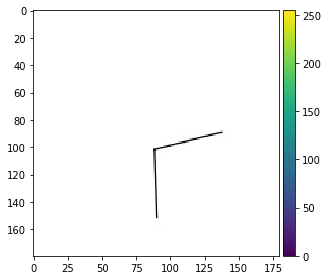

真实角度: 103.0
预测角度: 105.01120805740356


In [174]:
#评估结果

ix = random.randint(0,int(X_train.shape[0]*0.9))
imshow(X_train[ix])
plt.show()
print('真实角度:',Y_train[ix]*180)
print('预测角度:',preds_train[ix][0]*180)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


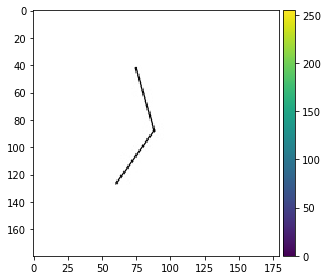

真实角度: 129.0
预测角度: 124.83935236930847


In [176]:
#验证集的情况
ix = random.randint(0,len(preds_val))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
print('真实角度:',Y_train[int(X_train.shape[0]*0.9):][ix]*180)
print('预测角度:',preds_val[ix][0]*180)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


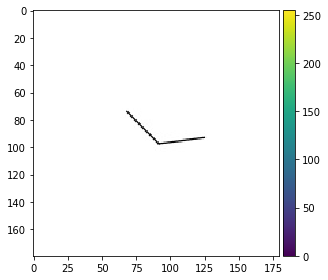

真实角度: 125.99999999999999
预测角度: 121.9808578491211


In [177]:
#测试集的情况
# ix = 75
ix = random.randint(0,len(preds_test))
imshow(X_test[ix])
plt.show()
print('真实角度:',Y_test[ix]*180)
print('预测角度:',preds_test[ix][0]*180)

## 评估测试集的准确度

In [178]:
import pandas as pd


In [179]:
angle_comp = pd.DataFrame({'real_angle':Y_test*180, 'pred_angle':np.array([i[0] for i in preds_test])*180})
print(len(angle_comp[(angle_comp['pred_angle']-angle_comp['real_angle']).abs() < 10])/len(angle_comp))

0.942


In [160]:
angle_comp

,pred_angle,real_angle
0,112.238052,109.0
1,81.066261,77.0
2,128.213577,134.0
3,78.875076,74.0
4,131.454590,130.0
5,135.483429,138.0
6,163.905396,173.0
7,18.372704,15.0
8,125.145164,126.0
9,145.632767,145.0
